<p style="background-color: #FFFF; font-family: Times New Roman; 
color: black; font-size: 200%; text-align: center; 
border-radius: 15px 15px; padding: 15px;">
    <strong>Import Libraries</strong>
</p>




In [1]:
# import Libraries
# Plan
import pandas as pd 
import numpy as np 
from scipy.stats import chi2_contingency
from lifelines import KaplanMeierFitter
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import joblib 

<p style="background-color: #FFFF; font-family: Times New Roman; 
color: black; font-size: 200%; text-align: center; 
border-radius: 15px 15px; padding: 15px;">
    <strong># Prepare Data</strong>
</p>

In [2]:
# Replace missing values with NaN
nulls_values = ['','Other','TBD','Not tested','Not done','N/A - disease not classifiable','unknown dose','No drugs reported','N/A, F(pre-TED) not submitted']
data_train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv" , na_values=nulls_values)
data_test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")

<p style="background-color: #FFFF; font-family: Times New Roman; 
color: black; font-size: 250%; text-align: center; 
border-radius: 15px 15px; padding: 15px;">
    <strong>Analyze</strong>
</p>

In [3]:
# Show Data
print(data_train.shape)

(28800, 60)


In [4]:
# Info 
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28374 non-null  object 
 2   psych_disturb           26592 non-null  object 
 3   cyto_score              18832 non-null  object 
 4   diabetes                26540 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26480 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26748 non-null  object 
 13  pulm_severe             26485 non-null  object 
 14  prim_disease_hct        28800 non-null

In [5]:
# Check if there are duplicate rows?
print(data_train.duplicated().sum())

0


In [6]:
#Check if there are any missing values? 
missing_values = data_train.isna().sum()
print(missing_values)

ID                            0
dri_score                   426
psych_disturb              2208
cyto_score                 9968
diabetes                   2260
hla_match_c_high           4620
hla_high_res_8             5829
tbi_status                    0
arrhythmia                 2320
hla_low_res_6              3270
graft_type                    0
vent_hist                   259
renal_issue                2052
pulm_severe                2315
prim_disease_hct              0
hla_high_res_6             5284
cmv_status                  634
hla_high_res_10            7163
hla_match_dqb1_high        5199
tce_imm_match             11133
hla_nmdp_6                 4197
hla_match_c_low            2800
rituximab                  2148
hla_match_drb1_low         2643
hla_match_dqb1_low         4194
prod_type                     0
cyto_score_detail         13111
conditioning_intensity     5311
ethnicity                   587
year_hct                      0
obesity                    1877
mrd_hct 

<function matplotlib.pyplot.show(close=None, block=None)>

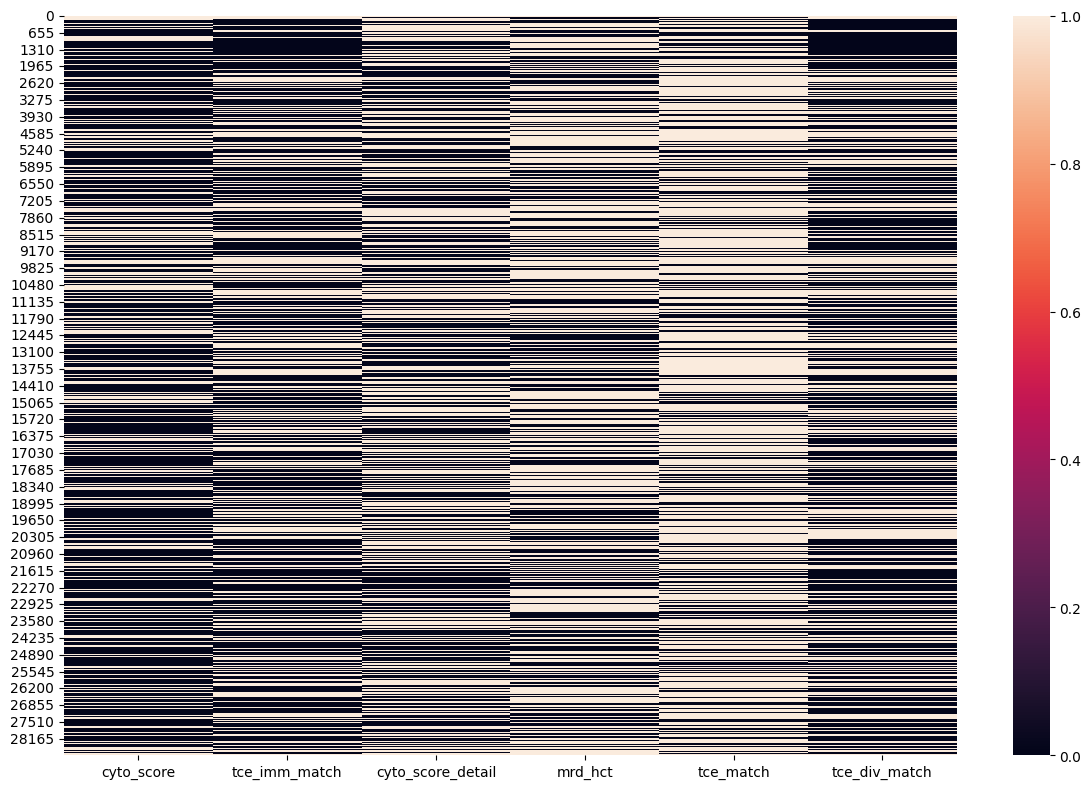

In [7]:
missing_columns = missing_values[missing_values > 9000].index

plt.figure(figsize=(12,8))
sns.heatmap(data_train[missing_columns].isnull(), cbar=True)
 
plt.tight_layout()
plt.show

In [8]:
# Using OrdinalEncoder to convert categorical text values into numeric values for each column.
def ordinalencoder_data(data):

    # Select the categorical columns (object type) from the dataframe
    categorical_cols = data.select_dtypes(include=['object']).columns

    # Create a mask to identify missing values (NaN) in the categorical columns
    mask = data[categorical_cols].isna()

    # Fill missing values with the string 'missing' to ensure no NaN values before encoding
    temp_data = data[categorical_cols].fillna('missing')

    # Initialize the OrdinalEncoder, which will convert categorical values to numerical labels
    oe = OrdinalEncoder()

    # Fit the encoder to the data and transform the categorical columns into numerical labels
    encoded_data = oe.fit_transform(temp_data)

    # Convert the encoded data to a DataFrame, keeping the original column names and specifying the dtype as 'Int64'
    encoded_series = pd.DataFrame(encoded_data, columns=categorical_cols, dtype='Int64')

    # Restore the missing values (NaN) in the original positions, using pd.NA to indicate missing values
    encoded_series[mask] = pd.NA

    # Update the original dataframe with the encoded columns while preserving the missing value positions
    data[categorical_cols] = encoded_series

    return data

In [9]:
# Apply ordinal encoding to the training and test datasets  
data_train = ordinalencoder_data(data_train)
data_test = ordinalencoder_data(data_test)

In [10]:
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28374 non-null  Int64  
 2   psych_disturb           26592 non-null  Int64  
 3   cyto_score              18832 non-null  Int64  
 4   diabetes                26540 non-null  Int64  
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  Int64  
 8   arrhythmia              26480 non-null  Int64  
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  Int64  
 11  vent_hist               28541 non-null  Int64  
 12  renal_issue             26748 non-null  Int64  
 13  pulm_severe             26485 non-null  Int64  
 14  prim_disease_hct        28800 non-null

In [11]:
# Fill missing values in the columns selected for analysis
def fillna_data(data):

    # Save the original data types of the columns in a copy to refer back to after imputation
    original_dtypes = data.dtypes.copy()

    # Initialize the IterativeImputer to fill missing values using multiple imputation iterations
    imputer = SimpleImputer(strategy='most_frequent')

    # Apply the imputer to the data and perform the imputation
    imputer_data = imputer.fit_transform(data)

    # Convert the imputed data back into a DataFrame with the original column names
    data = pd.DataFrame(imputer_data, columns=data.columns)

    # Convert columns that were originally of type 'int64' or 'Int64' back to integer type after imputation
    data = data.apply(lambda col: col.astype(int) if original_dtypes[col.name] in ['int64','Int64'] else round(col , 1))

    return data

In [12]:
# Fill missing values in the training and test datasets  
data_train = fillna_data(data_train)
data_test = fillna_data(data_test)

In [13]:
# Calculate and print the total number of missing values per column (if needed) after filling
missing_values = data_train.isna().sum()
print(f"Missing values filling: {missing_values}")

Missing values filling: ID                        0
dri_score                 0
psych_disturb             0
cyto_score                0
diabetes                  0
hla_match_c_high          0
hla_high_res_8            0
tbi_status                0
arrhythmia                0
hla_low_res_6             0
graft_type                0
vent_hist                 0
renal_issue               0
pulm_severe               0
prim_disease_hct          0
hla_high_res_6            0
cmv_status                0
hla_high_res_10           0
hla_match_dqb1_high       0
tce_imm_match             0
hla_nmdp_6                0
hla_match_c_low           0
rituximab                 0
hla_match_drb1_low        0
hla_match_dqb1_low        0
prod_type                 0
cyto_score_detail         0
conditioning_intensity    0
ethnicity                 0
year_hct                  0
obesity                   0
mrd_hct                   0
in_vivo_tcd               0
tce_match                 0
hla_match_a_high        

In [14]:
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28800 non-null  int64  
 2   psych_disturb           28800 non-null  int64  
 3   cyto_score              28800 non-null  int64  
 4   diabetes                28800 non-null  int64  
 5   hla_match_c_high        28800 non-null  float64
 6   hla_high_res_8          28800 non-null  float64
 7   tbi_status              28800 non-null  int64  
 8   arrhythmia              28800 non-null  int64  
 9   hla_low_res_6           28800 non-null  float64
 10  graft_type              28800 non-null  int64  
 11  vent_hist               28800 non-null  int64  
 12  renal_issue             28800 non-null  int64  
 13  pulm_severe             28800 non-null  int64  
 14  prim_disease_hct        28800 non-null

In [15]:
# Statistical Summary of the Data
print(data_train.describe())

                 ID     dri_score  psych_disturb    cyto_score      diabetes  \
count  28800.000000  28800.000000   28800.000000  28800.000000  28800.000000   
mean   14399.500000      3.408021       0.124549      2.221250      0.150660   
std     8313.988213      2.710010       0.330212      1.114635      0.357723   
min        0.000000      0.000000       0.000000      0.000000      0.000000   
25%     7199.750000      2.000000       0.000000      1.000000      0.000000   
50%    14399.500000      2.000000       0.000000      3.000000      0.000000   
75%    21599.250000      6.000000       0.000000      3.000000      0.000000   
max    28799.000000      9.000000       1.000000      3.000000      1.000000   

       hla_match_c_high  hla_high_res_8    tbi_status    arrhythmia  \
count      28800.000000    28800.000000  28800.000000  28800.000000   
mean           1.802292        7.104132      0.917604      0.044340   
std            0.405107        1.468144      1.796048      0.20585

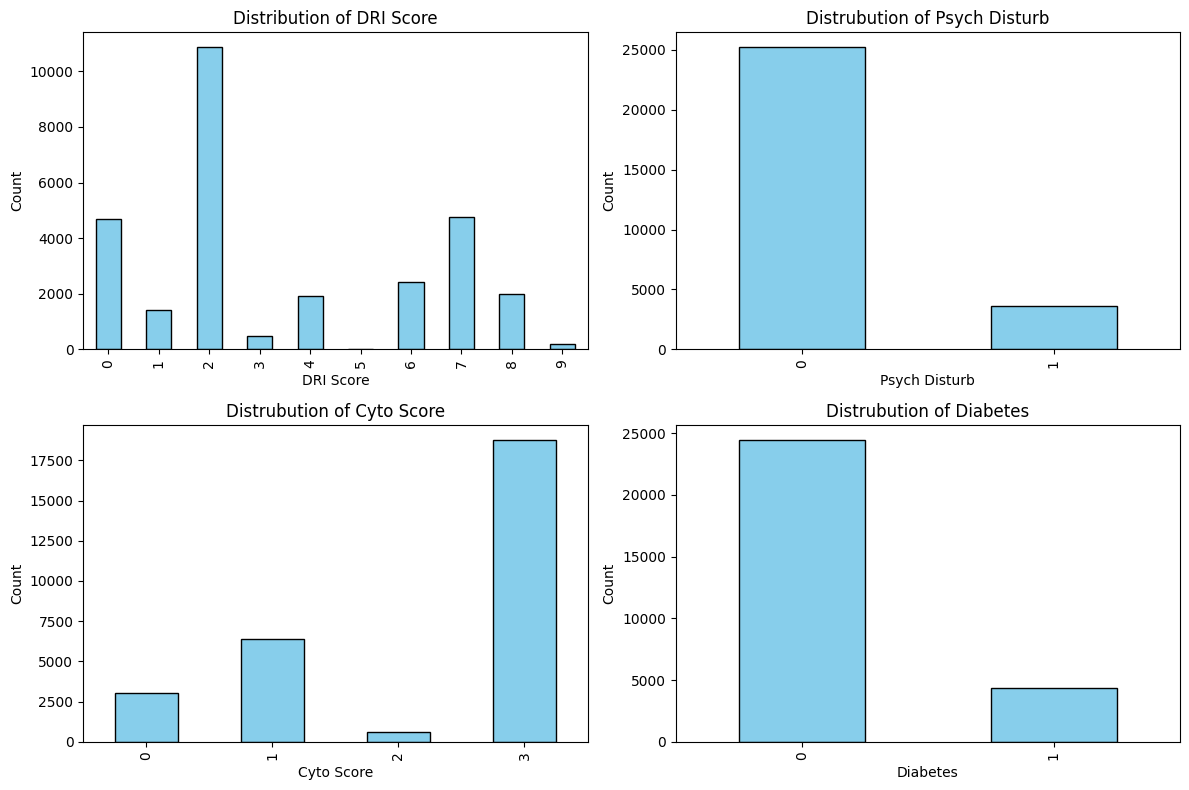

In [16]:
# What is the distribution of the dri_score and psych_disturb and cyto_score and diabetes ?

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

dri_score_counts = data_train['dri_score'].value_counts().sort_index()

dri_score_counts.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distribution of DRI Score")
plt.xlabel("DRI Score")
plt.ylabel("Count")

plt.subplot(2,2,2)

psych_disturb = data_train['psych_disturb'].value_counts().sort_index()

psych_disturb.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distrubution of Psych Disturb")
plt.xlabel("Psych Disturb")
plt.ylabel("Count")

plt.subplot(2,2,3)

cyto_score = data_train['cyto_score'].value_counts().sort_index()

cyto_score.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distrubution of Cyto Score")
plt.xlabel("Cyto Score")
plt.ylabel("Count")

plt.subplot(2,2,4)

diabetes = data_train['diabetes'].value_counts().sort_index()

diabetes.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distrubution of Diabetes")
plt.xlabel("Diabetes")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

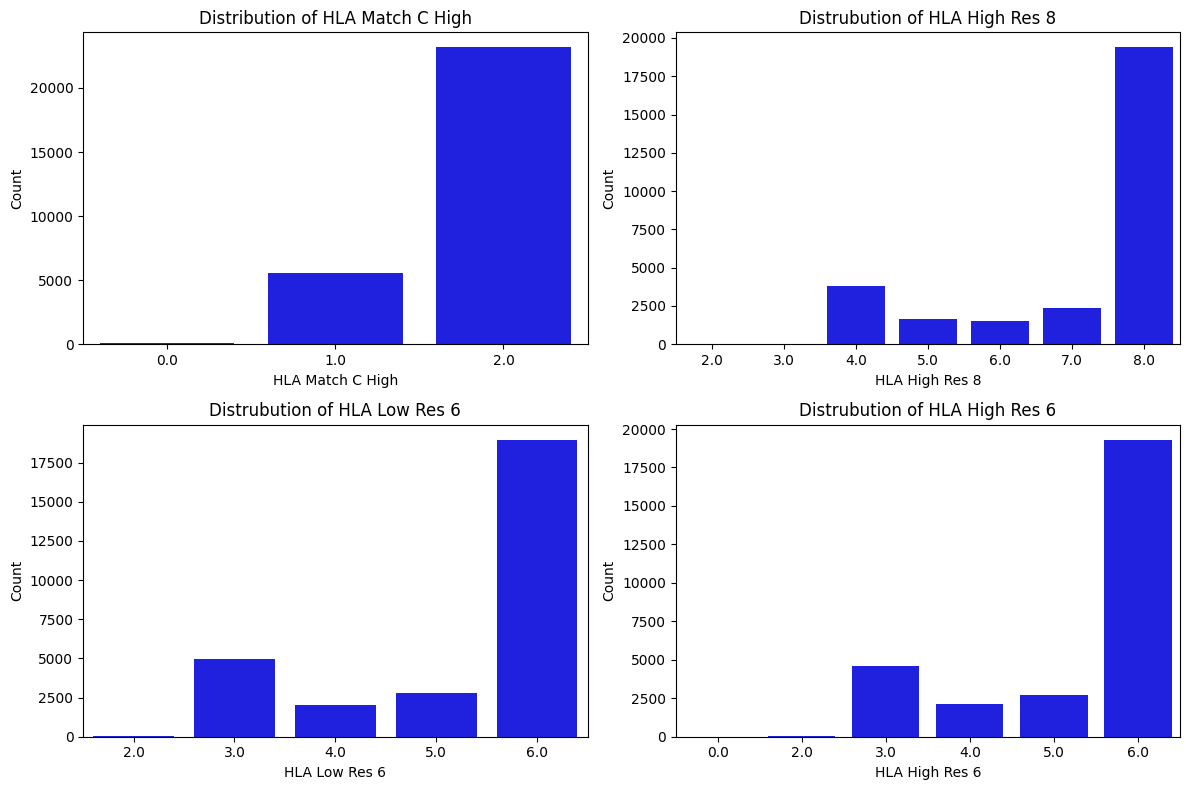

In [17]:
# What is the distribution of the hla_match_c_high and hla_high_res_8 and hla_low_res_6 and hla_high_res_6 ?

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

sns.countplot(data=data_train , x='hla_match_c_high' , color='blue')
plt.title('Distribution of HLA Match C High')
plt.xlabel('HLA Match C High')
plt.ylabel('Count')


plt.subplot(2,2,2)

sns.countplot(data=data_train , x='hla_high_res_8' , color='blue')
plt.title('Distrubution of HLA High Res 8')
plt.xlabel("HLA High Res 8")
plt.ylabel("Count")

plt.subplot(2,2,3)

sns.countplot(data=data_train , x='hla_low_res_6' , color='blue')
plt.title("Distrubution of HLA Low Res 6")
plt.xlabel("HLA Low Res 6")
plt.ylabel("Count")

plt.subplot(2,2,4)

sns.countplot(data=data_train , x='hla_high_res_6' , color='blue')
plt.title('Distrubution of HLA High Res 6')
plt.xlabel("HLA High Res 6")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

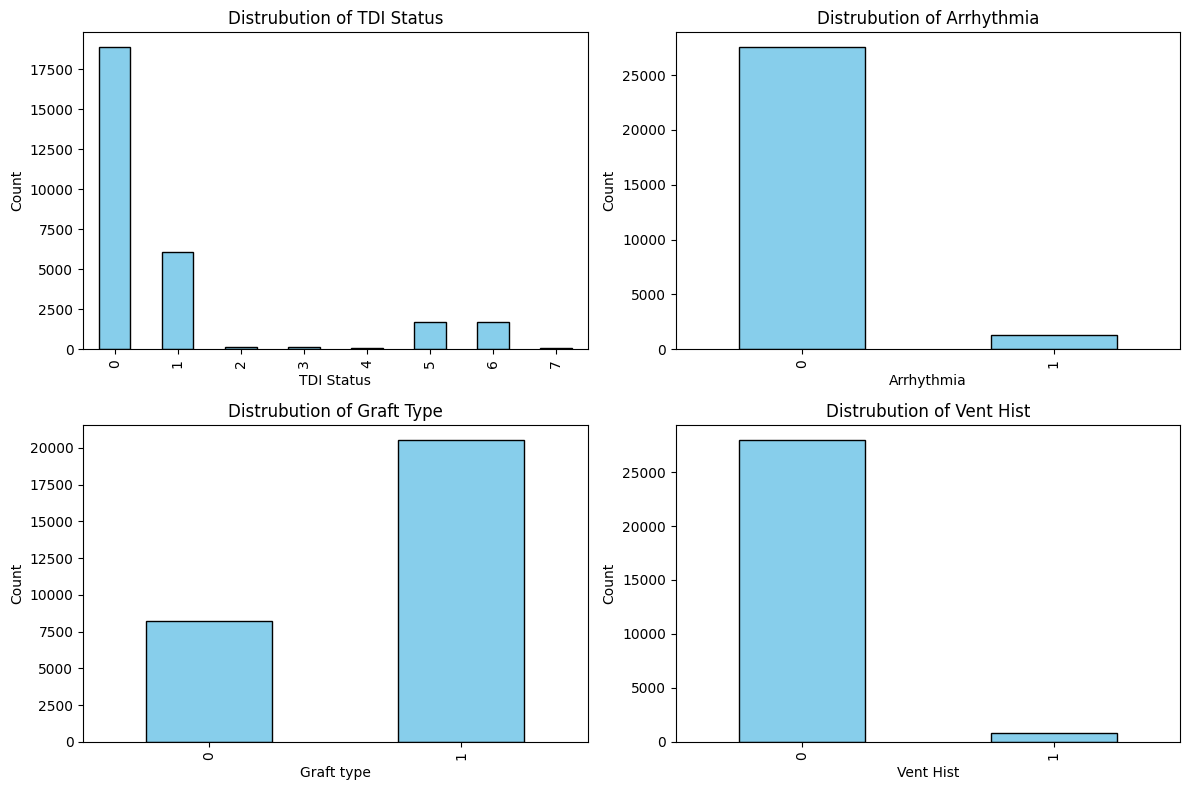

In [18]:
# What is the distribution of the tbi_status and arrhythmia and graft_type and vent_hist ?

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

tbi_status = data_train['tbi_status'].value_counts().sort_index()

tbi_status.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distrubution of TDI Status")
plt.xlabel("TDI Status")
plt.ylabel("Count")

plt.subplot(2,2,2)

arrhythmia = data_train['arrhythmia'].value_counts().sort_index()

arrhythmia.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distrubution of Arrhythmia")
plt.xlabel("Arrhythmia")
plt.ylabel("Count")

plt.subplot(2,2,3)

graft_type = data_train['graft_type'].value_counts().sort_index()

graft_type.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distrubution of Graft Type")
plt.xlabel("Graft type")
plt.ylabel("Count")

plt.subplot(2,2,4)

vent_hist = data_train['vent_hist'].value_counts().sort_index()

vent_hist.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distrubution of Vent Hist")
plt.xlabel("Vent Hist")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


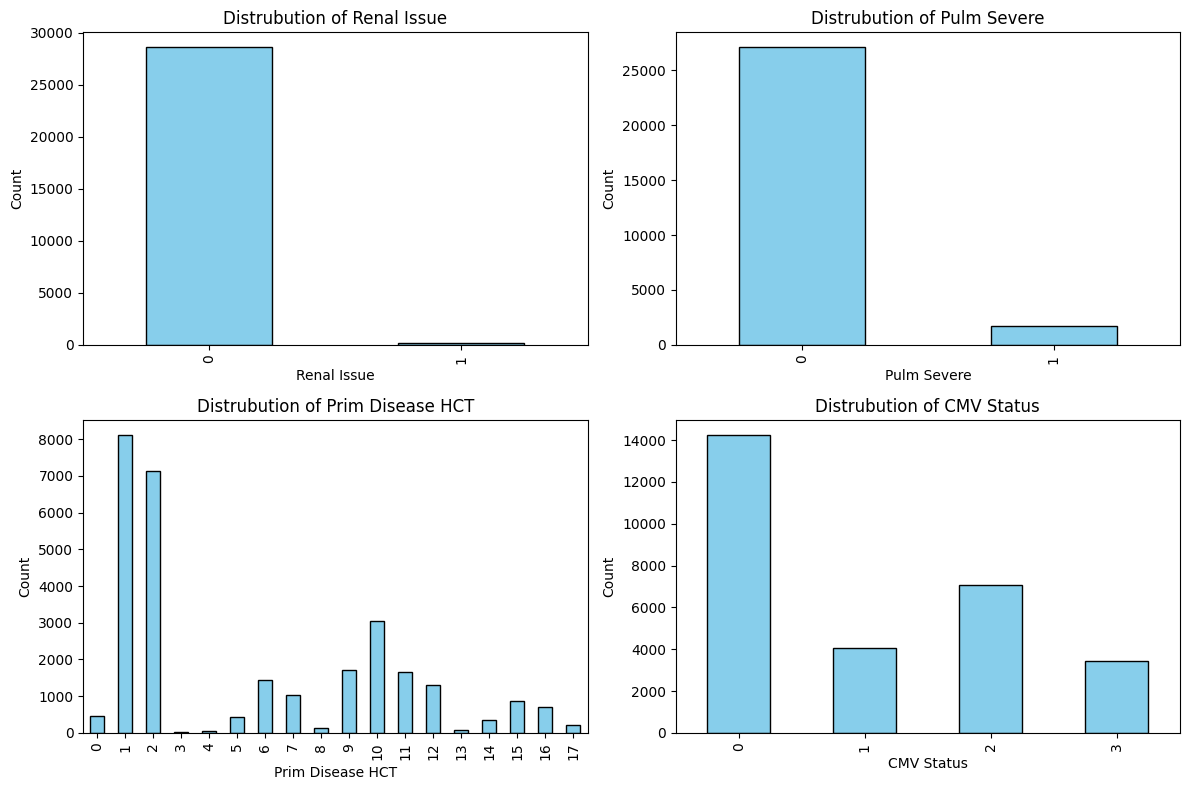

In [19]:
# What is the distribution of the renal_issue and pulm_severe and prim_disease_hct and cmv_status ?
        
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

renal_issue = data_train['renal_issue'].value_counts().sort_index()

renal_issue.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distrubution of Renal Issue")
plt.xlabel("Renal Issue")
plt.ylabel("Count")

plt.subplot(2,2,2)

pulm_severe = data_train['pulm_severe'].value_counts().sort_index()

pulm_severe.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distrubution of Pulm Severe")
plt.xlabel("Pulm Severe")
plt.ylabel("Count")

plt.subplot(2,2,3)

prim_disease_hct = data_train['prim_disease_hct'].value_counts().sort_index()

prim_disease_hct.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distrubution of Prim Disease HCT")
plt.xlabel("Prim Disease HCT")
plt.ylabel("Count")

plt.subplot(2,2,4)

cmv_status = data_train['cmv_status'].value_counts().sort_index()

cmv_status.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distrubution of CMV Status")
plt.xlabel("CMV Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

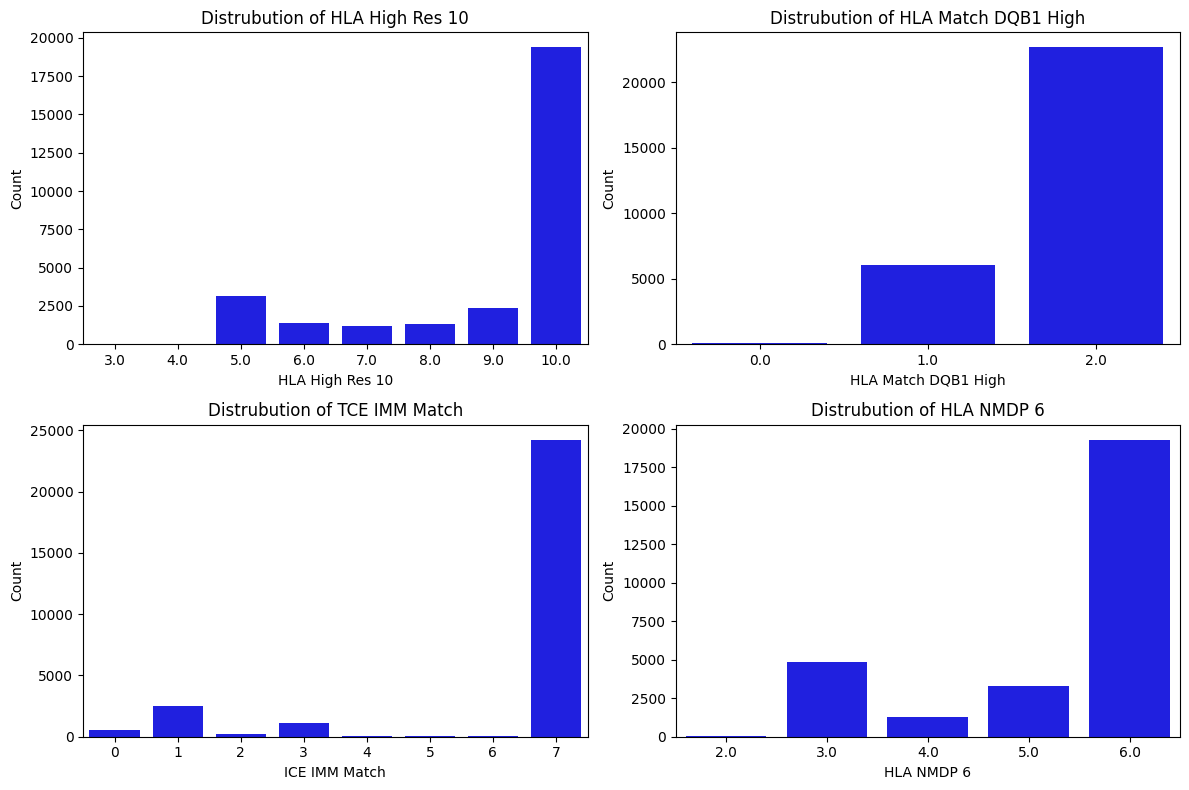

In [20]:
# What is the distribution of the hla_high_res_10 and hla_match_dqb1_high and tce_imm_match and hla_nmdp_6 ?

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

sns.countplot(data=data_train , x='hla_high_res_10' , color='blue')
plt.title('Distrubution of HLA High Res 10')
plt.xlabel("HLA High Res 10")
plt.ylabel("Count")

plt.subplot(2,2,2)

sns.countplot(data=data_train , x='hla_match_dqb1_high' , color='blue')
plt.title('Distrubution of HLA Match DQB1 High')
plt.xlabel("HLA Match DQB1 High")
plt.ylabel("Count")

plt.subplot(2,2,3)

sns.countplot(data=data_train , x='tce_imm_match' , color='blue')
plt.title('Distrubution of TCE IMM Match')
plt.xlabel("ICE IMM Match")
plt.ylabel("Count")

plt.subplot(2,2,4)

sns.countplot(data=data_train , x='hla_nmdp_6' , color='blue')
plt.title('Distrubution of HLA NMDP 6')
plt.xlabel("HLA NMDP 6")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


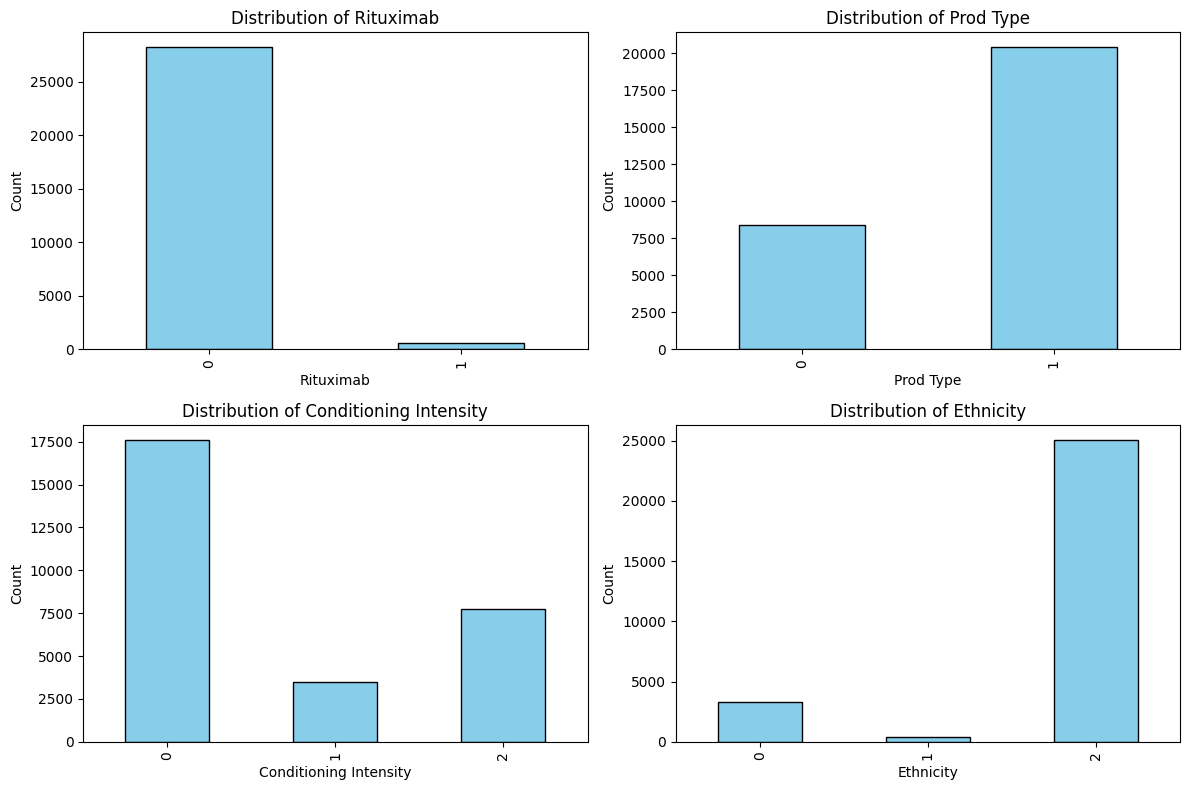

In [21]:
# What is the distribution of the rituximab  and prod_type and conditioning_intensity and ethnicity
        
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

rituximab = data_train['rituximab'].value_counts().sort_index()

rituximab.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distribution of Rituximab")
plt.xlabel("Rituximab")
plt.ylabel("Count")

plt.subplot(2,2,2)

prod_type = data_train['prod_type'].value_counts().sort_index()

prod_type.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distribution of Prod Type")
plt.xlabel("Prod Type")
plt.ylabel("Count")

plt.subplot(2,2,3)

conditioning_intensity = data_train['conditioning_intensity'].value_counts().sort_index()

conditioning_intensity.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distribution of Conditioning Intensity")
plt.xlabel("Conditioning Intensity")
plt.ylabel("Count")

plt.subplot(2,2,4)

ethnicity = data_train['ethnicity'].value_counts().sort_index()

ethnicity.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distribution of Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Count")

plt.tight_layout()
plt.show()



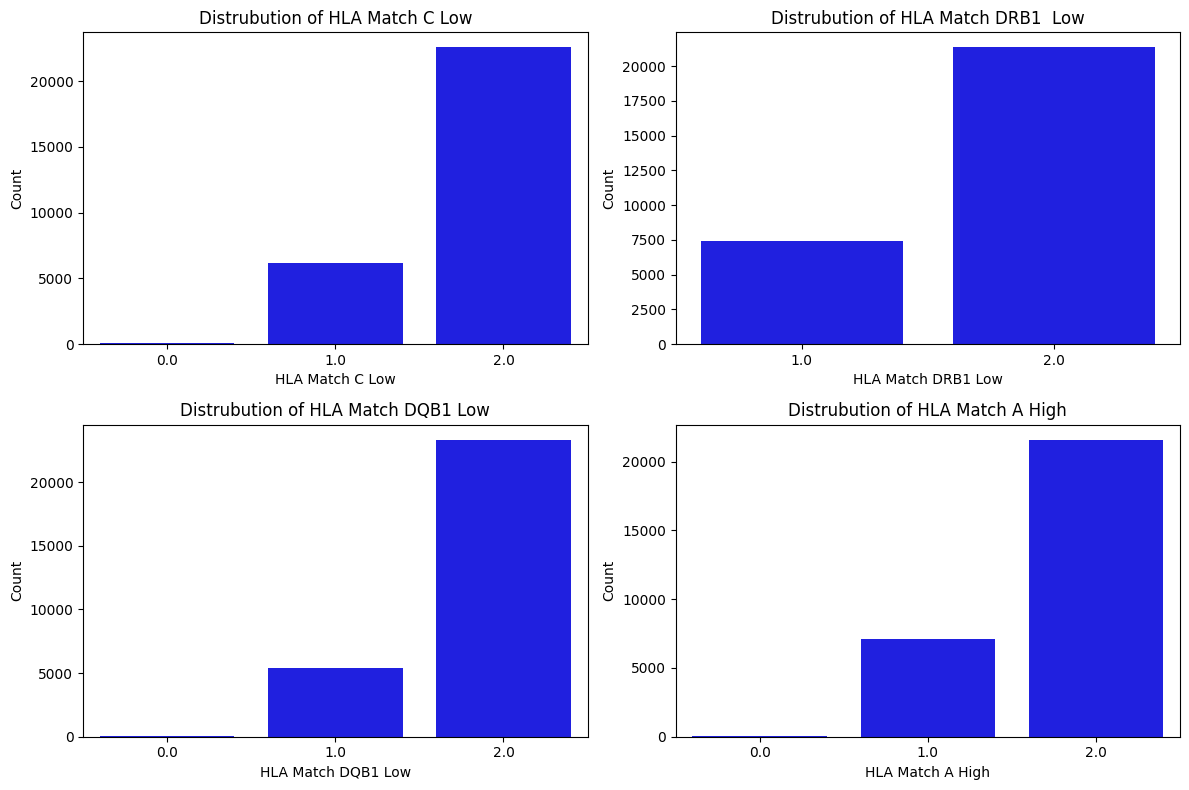

In [22]:
# What is the distribution of the hla_match_c_low and  hla_match_drb1_low and hla_match_dqb1_low and hla_match_a_high ?
        
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

sns.countplot(data=data_train , x='hla_match_c_low' , color='blue')
plt.title('Distrubution of HLA Match C Low')
plt.xlabel("HLA Match C Low")
plt.ylabel("Count")

plt.subplot(2,2,2)

sns.countplot(data=data_train , x='hla_match_drb1_low' , color='blue')
plt.title('Distrubution of HLA Match DRB1  Low')
plt.xlabel("HLA Match DRB1 Low")
plt.ylabel("Count")

plt.subplot(2,2,3)

sns.countplot(data=data_train , x='hla_match_dqb1_low' , color='blue')
plt.title('Distrubution of HLA Match DQB1 Low')
plt.xlabel("HLA Match DQB1 Low")
plt.ylabel("Count")

plt.subplot(2,2,4)

sns.countplot(data=data_train , x='hla_match_a_high' , color='blue')
plt.title('Distrubution of HLA Match A High')
plt.xlabel("HLA Match A High")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


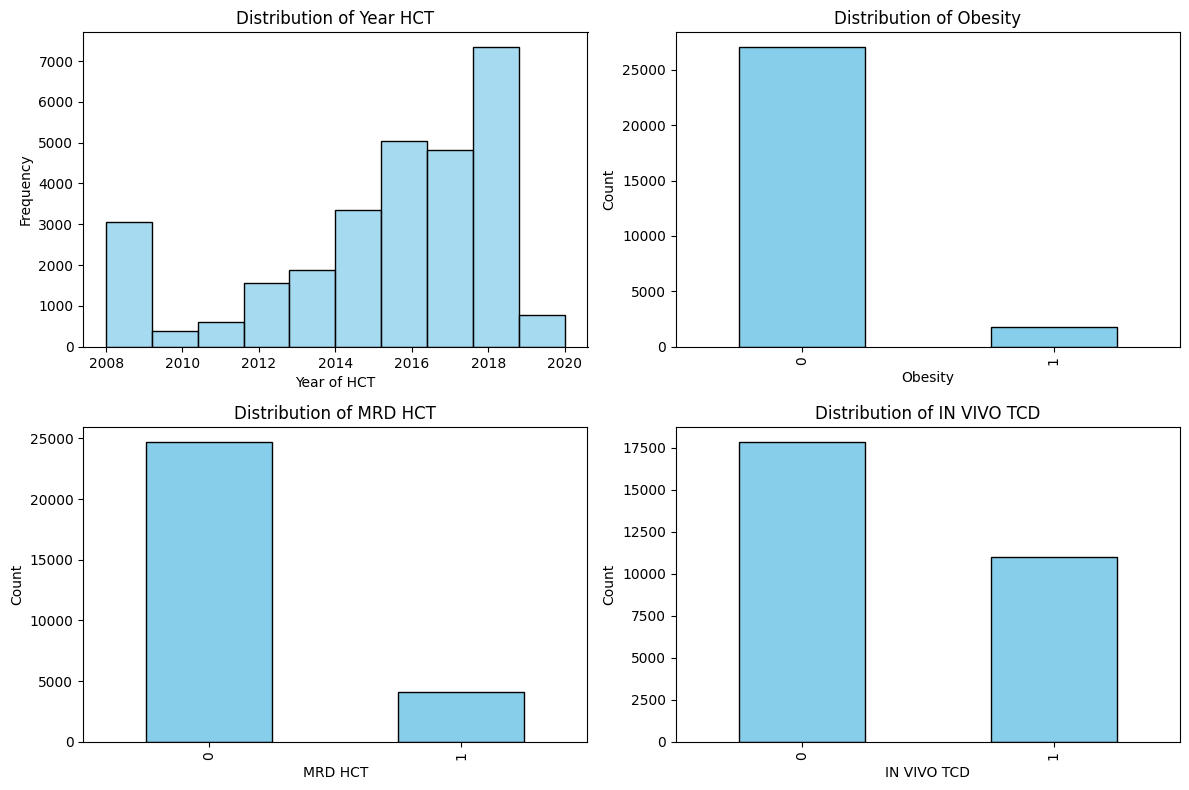

In [23]:
# What is the distribution of the year_hct and obesity and mrd_hct and in_vivo_tcd ?

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

sns.histplot(data=data_train['year_hct'] , bins=10 , kde=False , color='skyblue')
plt.title('Distribution of Year HCT')
plt.xlabel('Year of HCT')
plt.ylabel('Frequency')

plt.subplot(2,2,2)

obesity = data_train['obesity'].value_counts().sort_index()

obesity.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distribution of Obesity")
plt.xlabel("Obesity")
plt.ylabel("Count")

plt.subplot(2,2,3)

mrd_hct = data_train['mrd_hct'].value_counts().sort_index()

mrd_hct.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distribution of MRD HCT")
plt.xlabel("MRD HCT")
plt.ylabel("Count")

plt.subplot(2,2,4)

in_vivo_tcd = data_train['in_vivo_tcd'].value_counts().sort_index()

in_vivo_tcd.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distribution of IN VIVO TCD")
plt.xlabel("IN VIVO TCD")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


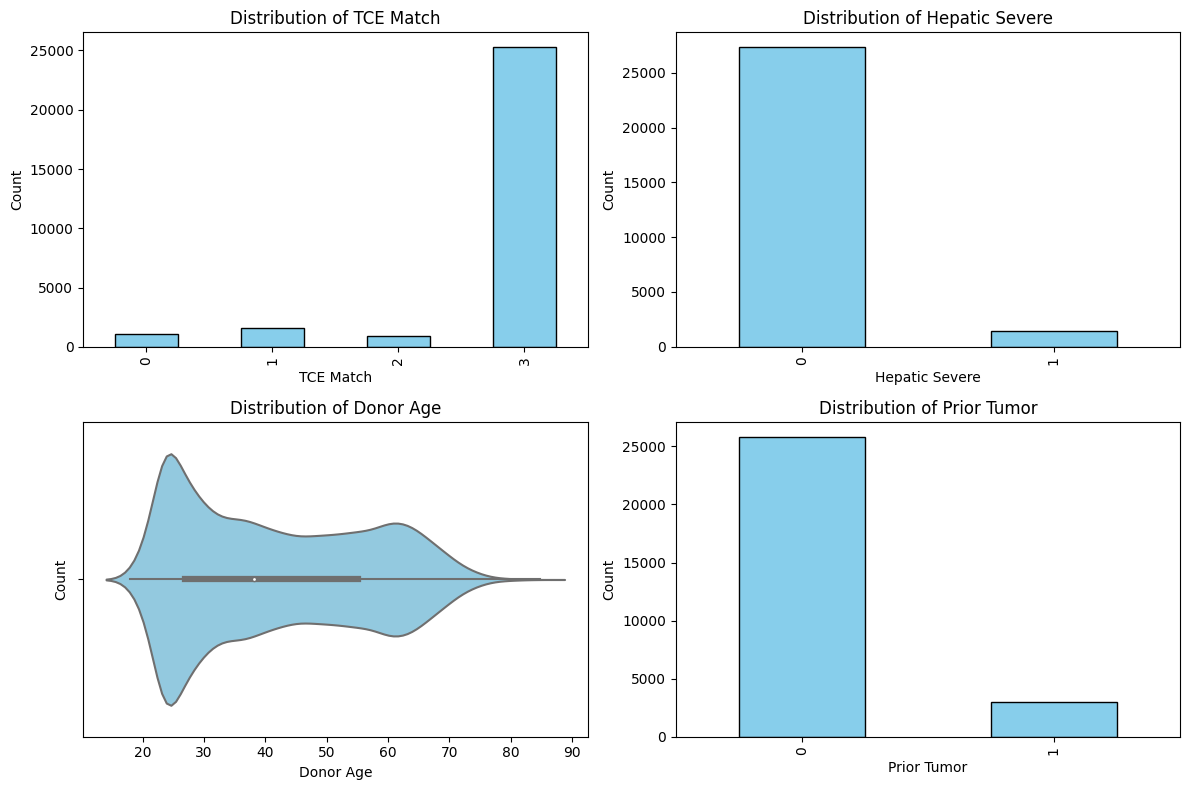

In [24]:
# What is the distribution of the tce_match and hepatic_severe and donor_age and prior_tumor ?

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

tce_match = data_train['tce_match'].value_counts().sort_index() 

tce_match.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distribution of TCE Match")
plt.xlabel("TCE Match")
plt.ylabel("Count")

plt.subplot(2,2,2)

hepatic_severe = data_train['hepatic_severe'].value_counts().sort_index()
hepatic_severe.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distribution of Hepatic Severe")
plt.xlabel("Hepatic Severe")
plt.ylabel("Count")

plt.subplot(2,2,3)

sns.violinplot(x=data_train['donor_age'] , color='skyblue')
plt.title("Distribution of Donor Age")
plt.xlabel("Donor Age")
plt.ylabel("Count")

plt.subplot(2,2,4)

prior_tumor = data_train['prior_tumor'].value_counts().sort_index()
prior_tumor.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title("Distribution of Prior Tumor")
plt.xlabel("Prior Tumor")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

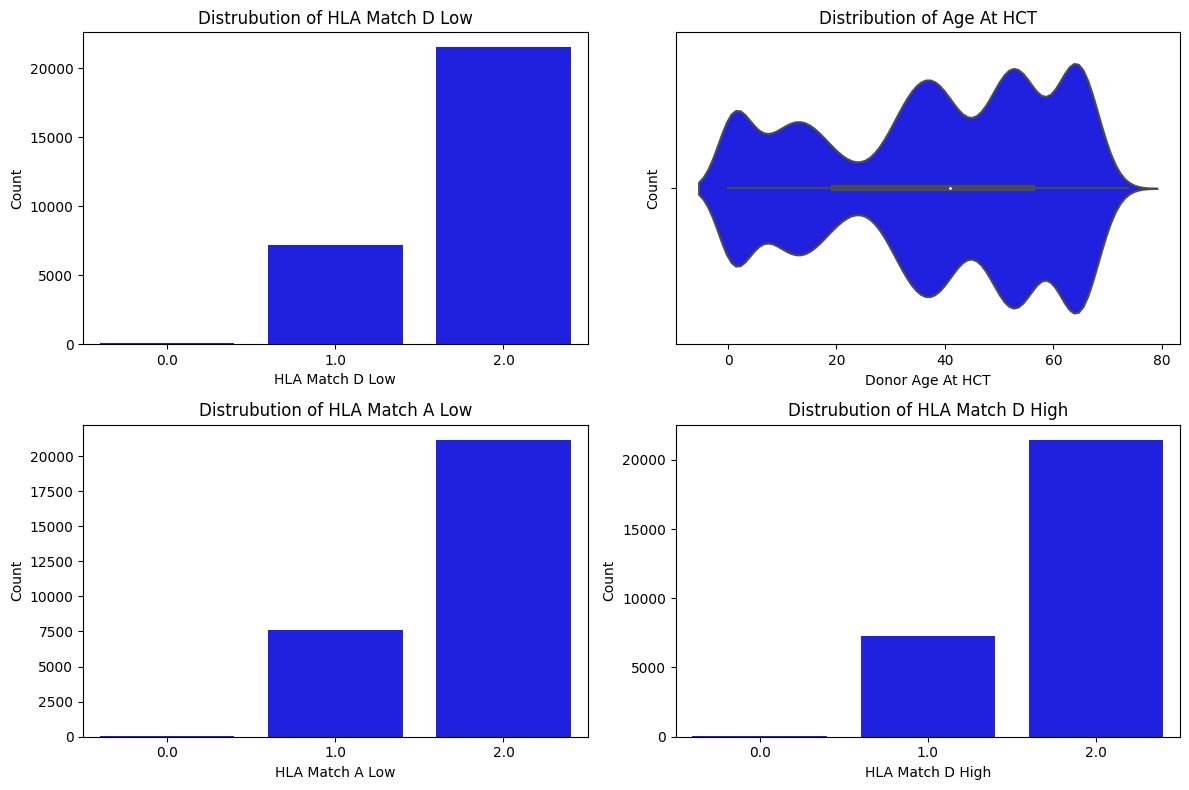

In [25]:
# What is the distribution of the hla_match_b_low and age_at_hct and hla_match_a_low and hla_match_b_high ?
        
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

sns.countplot(data=data_train , x='hla_match_b_low' , color='blue')
plt.title('Distrubution of HLA Match D Low')
plt.xlabel("HLA Match D Low")
plt.ylabel("Count")

plt.subplot(2,2,2)

sns.violinplot(x=data_train['age_at_hct'] , color='blue')
plt.title("Distribution of Age At HCT")
plt.xlabel("Donor Age At HCT")
plt.ylabel("Count")

plt.subplot(2,2,3)

sns.countplot(data=data_train , x='hla_match_a_low' , color='blue')
plt.title('Distrubution of HLA Match A Low')
plt.xlabel("HLA Match A Low")
plt.ylabel("Count")

plt.subplot(2,2,4)

sns.countplot(data=data_train , x='hla_match_b_high' , color='blue')
plt.title('Distrubution of HLA Match D High')
plt.xlabel("HLA Match D High")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


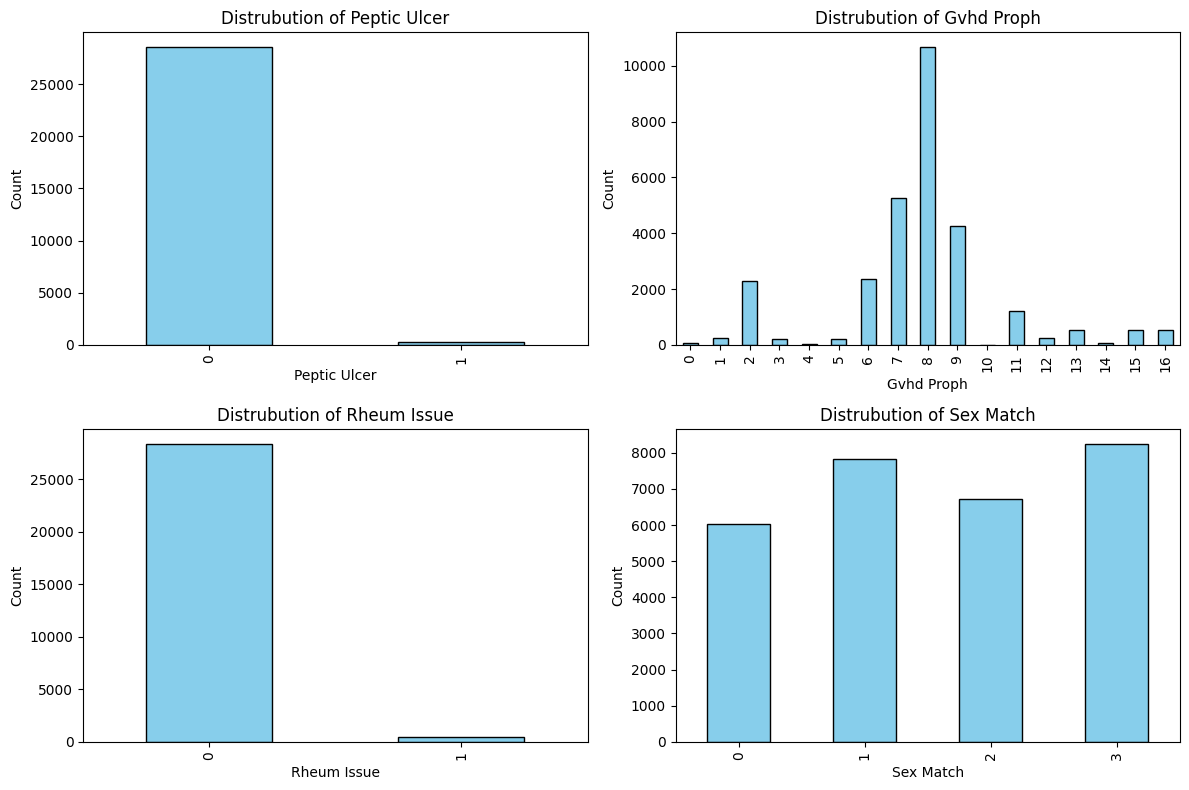

In [26]:
# What is the distribution of the peptic_ulcer and gvhd_proph and rheum_issue and sex_match ?
        
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

peptic_ulcer = data_train['peptic_ulcer'].value_counts().sort_index()

peptic_ulcer.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title('Distrubution of Peptic Ulcer')
plt.xlabel("Peptic Ulcer")
plt.ylabel("Count")

plt.subplot(2,2,2)

gvhd_proph = data_train['gvhd_proph'].value_counts().sort_index()

gvhd_proph.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title('Distrubution of Gvhd Proph')
plt.xlabel("Gvhd Proph")
plt.ylabel("Count")

plt.subplot(2,2,3)

rheum_issue = data_train['rheum_issue'].value_counts()

rheum_issue.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title('Distrubution of Rheum Issue')
plt.xlabel("Rheum Issue")
plt.ylabel("Count")

plt.subplot(2,2,4)

sex_match = data_train['sex_match'].value_counts().sort_index()

sex_match.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title('Distrubution of Sex Match')
plt.xlabel("Sex Match")
plt.ylabel("Count")

plt.tight_layout()
plt.show()
        

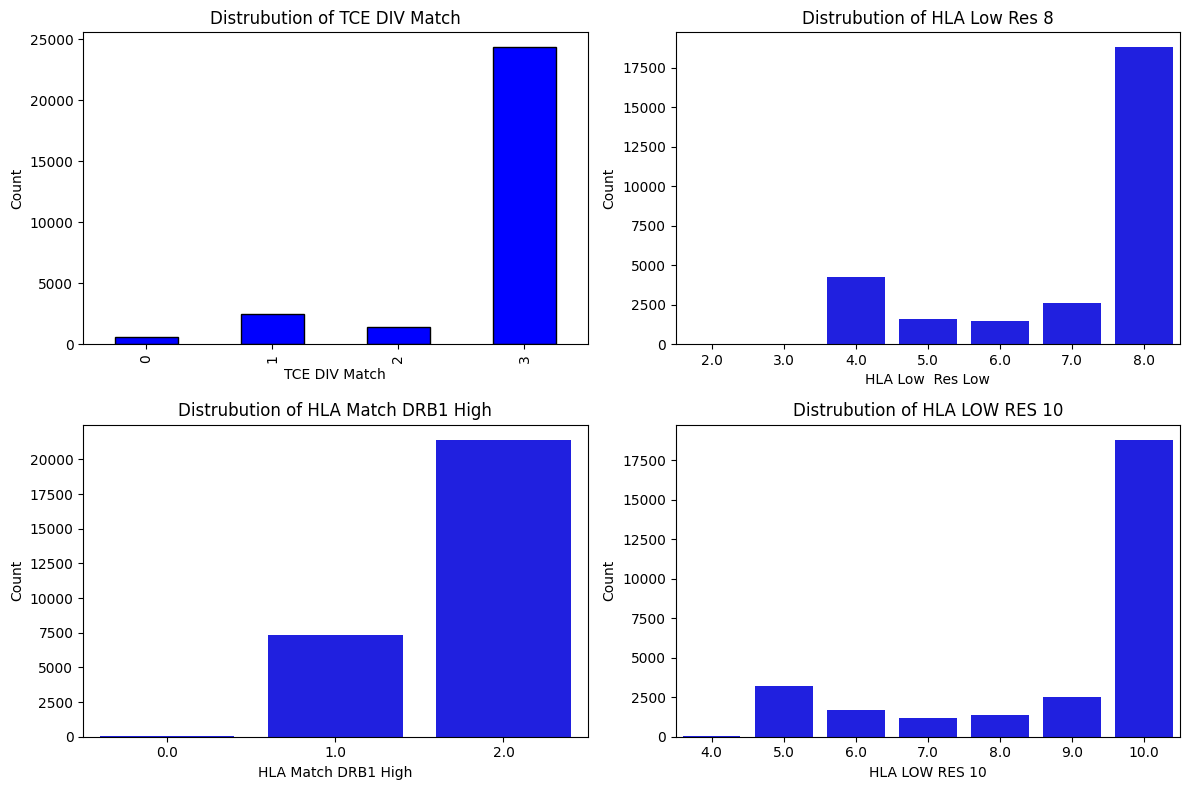

In [27]:
# What is the distribution of the tce_div_match and hla_low_res_8 and hla_match_drb1_high hla_low_res_10 ?

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

tce_div_match = data_train['tce_div_match'].value_counts().sort_index()
tce_div_match.plot(kind='bar' , color='blue' , edgecolor='black')
plt.title('Distrubution of TCE DIV Match')
plt.xlabel("TCE DIV Match")
plt.ylabel("Count")

plt.subplot(2,2,2)

sns.countplot(data=data_train , x='hla_low_res_8' , color='blue')
plt.title('Distrubution of HLA Low Res 8')
plt.xlabel("HLA Low  Res Low")
plt.ylabel("Count")

plt.subplot(2,2,3)

sns.countplot(data=data_train , x='hla_match_drb1_high' , color='blue')
plt.title('Distrubution of HLA Match DRB1 High')
plt.xlabel("HLA Match DRB1 High")
plt.ylabel("Count")

plt.subplot(2,2,4)

sns.countplot(data=data_train , x='hla_low_res_10' , color='blue')
plt.title('Distrubution of HLA LOW RES 10')
plt.xlabel("HLA LOW RES 10")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

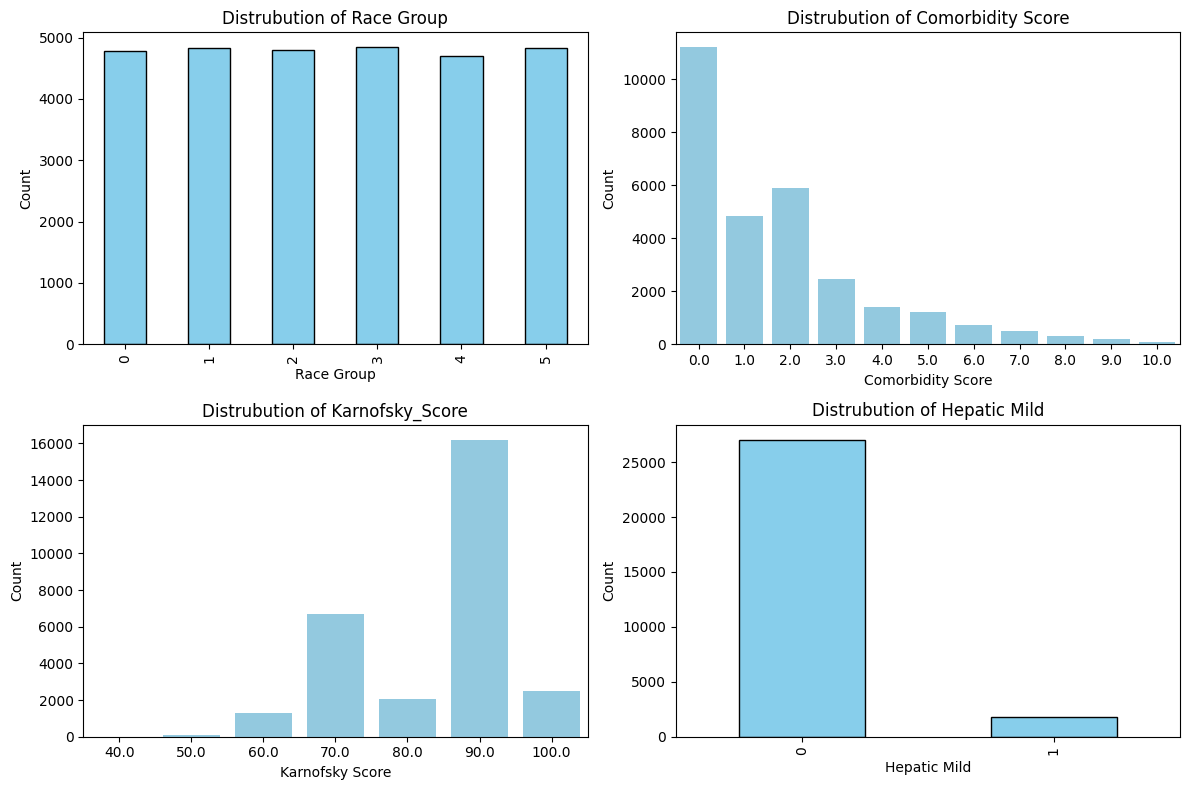

In [28]:
# What is the distribution of the race_group and comorbidity_score and karnofsky_score and hepatic_mild ?

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

race_group = data_train['race_group'].value_counts().sort_index()

race_group.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title('Distrubution of Race Group')
plt.xlabel("Race Group")
plt.ylabel("Count")

plt.subplot(2,2,2)

sns.countplot(data=data_train , x='comorbidity_score' , color='skyblue')
plt.title('Distrubution of Comorbidity Score')
plt.xlabel("Comorbidity Score")
plt.ylabel("Count")

plt.subplot(2,2,3)

sns.countplot(data=data_train , x='karnofsky_score' , color='skyblue')
plt.title('Distrubution of Karnofsky_Score')
plt.xlabel("Karnofsky Score")
plt.ylabel("Count")

plt.subplot(2,2,4)

hepatic_mild = data_train['hepatic_mild'].value_counts().sort_index()

hepatic_mild.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title('Distrubution of Hepatic Mild')
plt.xlabel("Hepatic Mild")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

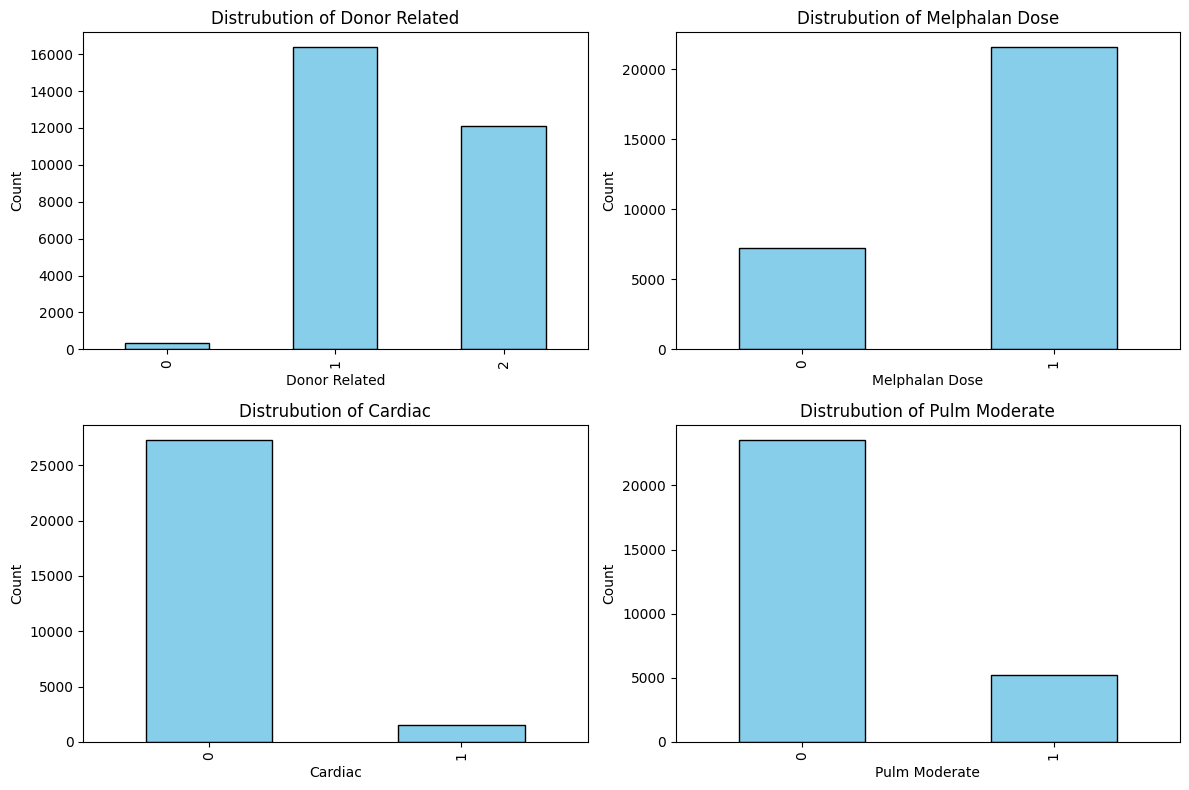

In [29]:
# What is the distribution of the donor_related and melphalan_dose and cardiac and pulm_moderate ?

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

donor_related = data_train['donor_related'].value_counts().sort_index()

donor_related.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title('Distrubution of Donor Related')
plt.xlabel("Donor Related")
plt.ylabel("Count")

plt.subplot(2,2,2)

melphalan_dose = data_train['melphalan_dose'].value_counts().sort_index()

melphalan_dose.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title('Distrubution of Melphalan Dose')
plt.xlabel("Melphalan Dose")
plt.ylabel("Count")

plt.subplot(2,2,3)

cardiac = data_train['cardiac'].value_counts().sort_index()

cardiac.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title('Distrubution of Cardiac')
plt.xlabel("Cardiac")
plt.ylabel("Count")

plt.subplot(2,2,4)

pulm_moderate = data_train['pulm_moderate'].value_counts().sort_index()

pulm_moderate.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title('Distrubution of Pulm Moderate')
plt.xlabel("Pulm Moderate")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


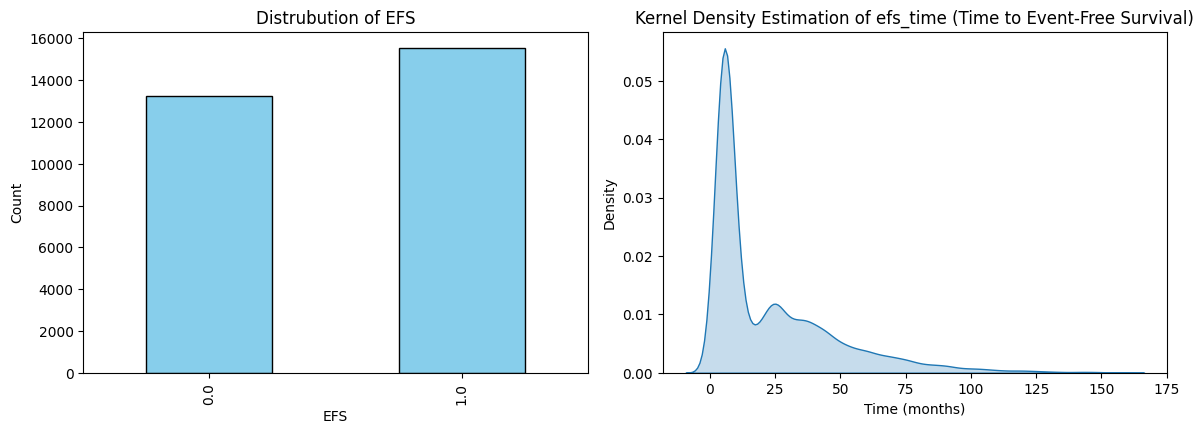

In [30]:

# What is the distribution of the efs and efs_time ?

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)

efs = data_train['efs'].value_counts().sort_index()

efs.plot(kind='bar' , color='skyblue' , edgecolor='black')
plt.title('Distrubution of EFS')
plt.xlabel("EFS")
plt.ylabel("Count")

plt.subplot(2,2,2)

sns.kdeplot(data_train['efs_time'], fill=True)
plt.title('Kernel Density Estimation of efs_time (Time to Event-Free Survival)')
plt.xlabel('Time (months)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [31]:

# 5 - Is there a relationship between the 'dri_score' column and the and the 'efs' or 'efs_time' columns?

# Test Chi-Squared 

# Create a table of frequencies between the two taxonomic columns
contingency_table = pd.crosstab(data_train['dri_score'] , data_train['efs'])


# Apply the chi-square test
chi2_stat , p_value , dof , expected = chi2_contingency(contingency_table)

# print the results 
print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print(f"Expected Frequencies: {expected}")

Chi-squared statistic: 1472.8890156489144
P-value: 1.372859138754e-311
Degrees of freedom: 9
Expected Frequencies: [[2.16572458e+03 2.53527542e+03]
 [6.51421944e+02 7.62578056e+02]
 [5.00406306e+03 5.85793694e+03]
 [2.21594028e+02 2.59405972e+02]
 [8.87297500e+02 1.03870250e+03]
 [4.14625000e+00 4.85375000e+00]
 [1.11810542e+03 1.30889458e+03]
 [2.20165875e+03 2.57734125e+03]
 [9.22770972e+02 1.08022903e+03]
 [9.12175000e+01 1.06782500e+02]]


In [32]:
# Logistic Regression Model using the Logit function ?

# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(dri_score)' , data=data_train).fit()
print(model_logistic.summary())

Optimization terminated successfully.
         Current function value: 0.664129
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28790
Method:                           MLE   Df Model:                            9
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                 0.03757
Time:                        20:25:36   Log-Likelihood:                -19127.
converged:                       True   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.8751      0.032     27.341      0.000       0.812       0.938
C(dri_sc

In [33]:
# Regression Model using the OLS function ?

# Model with categorical variable dri_score
model_ols = ols(formula='efs_time ~ C(dri_score)' , data=data_train).fit()
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     53.95
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           5.14e-98
Time:                        20:25:36   Log-Likelihood:            -1.3310e+05
No. Observations:               28800   AIC:                         2.662e+05
Df Residuals:                   28790   BIC:                         2.663e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            17.3389      0.35

In [34]:
# Function to plot Kaplan-Meier survival curve for any categorical group
def plot_kaplan_meier(group_column , plot_title):

    kaplanmeierfitter = KaplanMeierFitter()

    # Loop through each unique value of the group column
    for group in sorted(data_train[group_column].unique()):
        # Filter the data for the current group
        group_data = data_train[data_train[group_column] == group]
        
        
        # Fit the Kaplan-Meier estimator
        kaplanmeierfitter.fit(group_data['efs_time'], event_observed=group_data['efs'], label=f"{group_column} {group}")
        
        # Plot the survival function
        kaplanmeierfitter.plot_survival_function(ci_show=False)

    # Set the title and labels for the plot
    plt.title(plot_title)
    plt.xlabel("Time(months)")  # Label for the x-axis
    plt.ylabel("Survival Probability")  # Label for the y-axis
    
    # Adjust the layout to avoid clipping
    plt.tight_layout()
    # Save or show the plot
    plt.show()

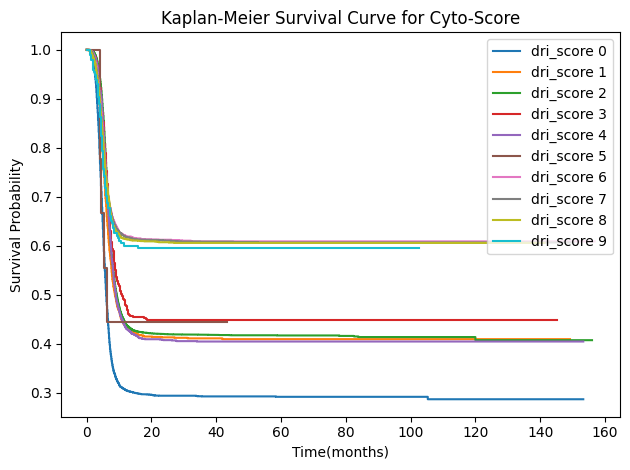

In [35]:
# Plot Kaplan-Meier curve for 'dri_score' column
plot_kaplan_meier('dri_score', 'Kaplan-Meier Survival Curve for Cyto-Score')

In [36]:
# 6-  Is there a relationship between the 'Psych-disturd' column and the 'diabetes'  and 'arrhythmia' 
# and renal-issue' and efs' or 'efs_time' columns?

# This function performs a Chi-squared test of independence between two categorical variables.
def chi2_contingency_test(data1, data2):
    # Create a contingency table using the specified columns from the dataset ('data1' and 'data2').
    contingency_table = pd.crosstab(data_train[data1], data_train[data2])

    # Perform the Chi-squared test using the contingency table.
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

    # Calculate Cramér's V
    n = contingency_table.values.sum()  # Total number of observations
    k = min(contingency_table.shape)  # Use the largest dimension of the table to calculate Cramér's V
    v = np.sqrt(chi2_stat / (n * (k - 1)))

    # Title
    print(f"Title: {data1}")
    # Print the Chi-squared statistic to show the strength of the association.
    print(f"Chi2: {chi2_stat}")
    # Print the p-value to determine the statistical significance of the association.
    print(f"P-value: {p_value}")
    # Print the degrees of freedom used in the test.
    print(f"Degrees of Freedom: {dof}")
    # Print the expected frequencies to compare against the observed frequencies.
    print(f"Expected Frequencies: {expected}")
    # Print Cramér's V to show the strength of the association between the variables.
    print(f"Cramér's V: {v}")


In [37]:
# Test the function with 'Psych-disturd' as the first variable and 'efs' as the second variable.
# This checks if there's a significant association between these two categorical variables.
chi2_contingency_test('psych_disturb', 'efs')


Title: psych_disturb
Chi2: 110.04149575230002
P-value: 9.596080171493675e-26
Degrees of Freedom: 1
Expected Frequencies: [[11615.48902778 13597.51097222]
 [ 1652.51097222  1934.48902778]]
Cramér's V: 0.06181330980603679


In [38]:
# Test the function with 'diabetes' as the first variable and 'efs' as the second variable.
chi2_contingency_test('diabetes' , 'efs')

Title: diabetes
Chi2: 125.1059588336582
P-value: 4.82483696589474e-29
Degrees of Freedom: 1
Expected Frequencies: [[11269.04680556 13191.95319444]
 [ 1998.95319444  2340.04680556]]
Cramér's V: 0.06590870127643592


In [39]:
# Test the function with 'arrhythmia' as the first variable and 'efs' as the second variable.
chi2_contingency_test('arrhythmia' , 'efs')

Title: arrhythmia
Chi2: 54.71867476605665
P-value: 1.3907842466867625e-13
Degrees of Freedom: 1
Expected Frequencies: [[12679.69319444 14843.30680556]
 [  588.30680556   688.69319444]]
Cramér's V: 0.043588461603187176


In [40]:
# Test the function with 'renal-issue' as the first variable and 'efs' as the second variable.
chi2_contingency_test('renal_issue' , 'efs')

Title: renal_issue
Chi2: 9.246902274532673
P-value: 0.002358941221031992
Degrees of Freedom: 1
Expected Frequencies: [[13175.86111111 15424.13888889]
 [   92.13888889   107.86111111]]
Cramér's V: 0.017918509861132303


In [41]:

# Logistic Regression Model using the Logit function ?

# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(psych_disturb) + C(diabetes) + C(arrhythmia) + C(renal_issue)' , data=data_train).fit()
# Print the Model Logistic results
print(model_logistic.summary())

Optimization terminated successfully.
         Current function value: 0.685092
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28795
Method:                           MLE   Df Model:                            4
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                0.007191
Time:                        20:25:38   Log-Likelihood:                -19731.
converged:                       True   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                 1.241e-60
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0467      0.014      3.406      0.001       0.020       0.

In [42]:
# Regression Model using the OLS function ?
# Model with categorical variable dri_score
model_ols = ols(formula='efs_time ~ C(psych_disturb) + C(diabetes) + C(arrhythmia) + (renal_issue)' , data=data_train).fit()
# print the model OLS results
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     49.96
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           5.75e-42
Time:                        20:25:38   Log-Likelihood:            -1.3324e+05
No. Observations:               28800   AIC:                         2.665e+05
Df Residuals:                   28795   BIC:                         2.665e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                24.42

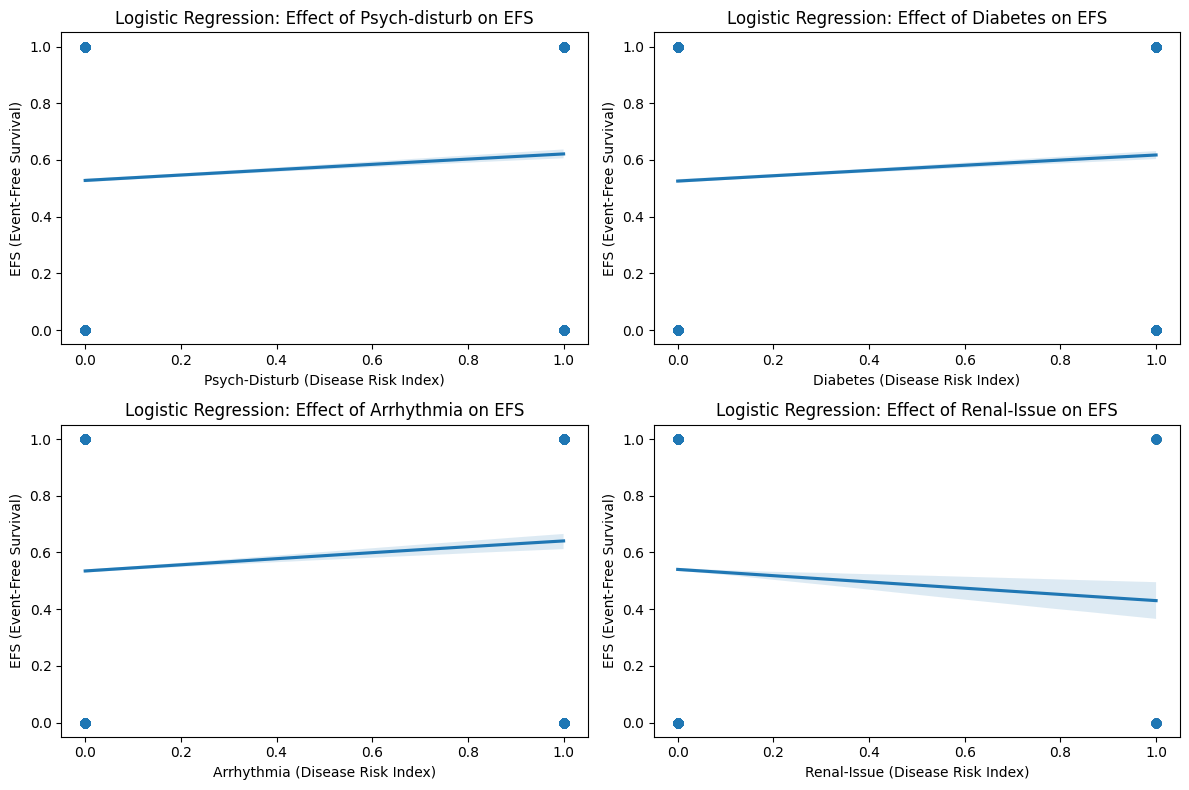

In [43]:
# Set the figure size for the plot to make it larger and more readable
plt.figure(figsize=(12,8))

# First subplot: Logistic regression plot for 'psych_disturb' vs 'efs'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='psych_disturb' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Psych-disturb on EFS")  # Title of the plot
plt.xlabel("Psych-Disturb (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Second subplot: Logistic regression plot for 'diabetes' vs 'efs'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='diabetes' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Diabetes on EFS")  # Title of the plot
plt.xlabel("Diabetes (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'arrhythmia' vs 'efs'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='arrhythmia' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Arrhythmia on EFS")  # Title of the plot
plt.xlabel("Arrhythmia (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'renal_issue' vs 'efs'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='renal_issue' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Renal-Issue on EFS")  # Title of the plot
plt.xlabel("Renal-Issue (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()


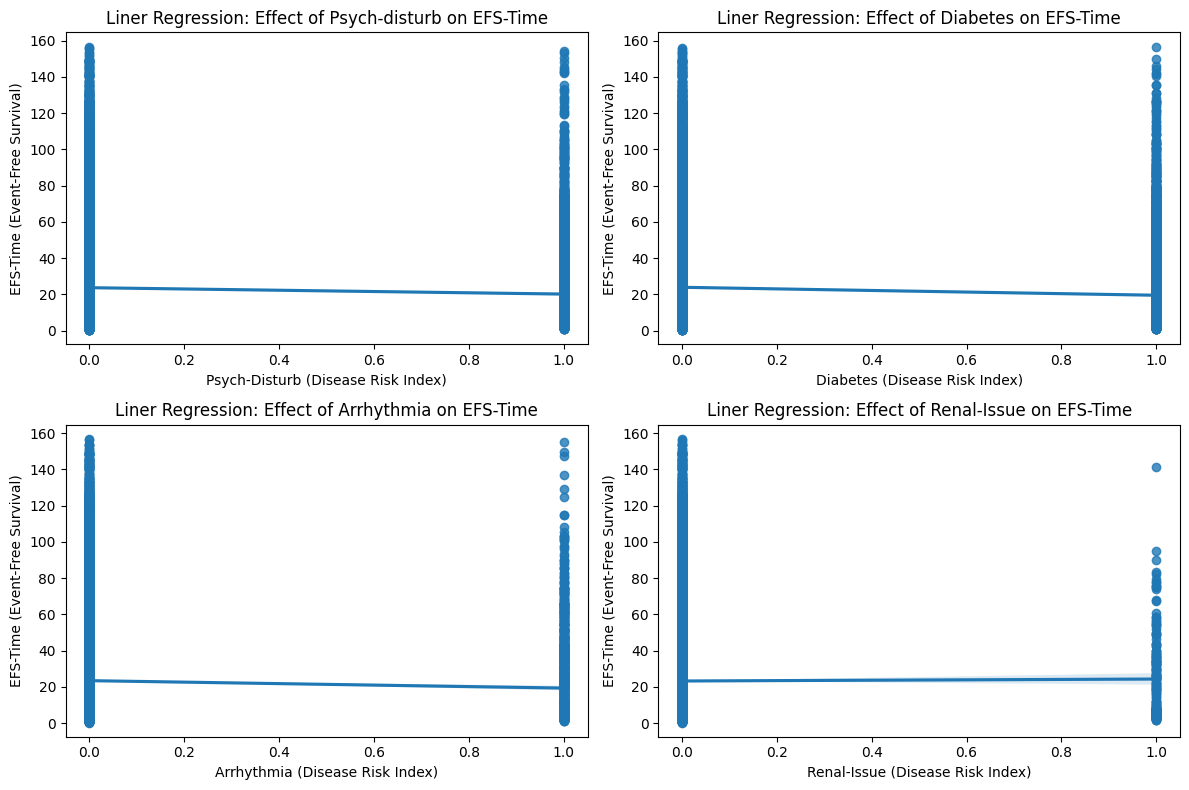

In [44]:
# Set the figure size for the plot to make it larger and more readable
plt.figure(figsize=(12,8))

# First subplot: Liner regression plot for 'psych_disturb' vs 'efs-time'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1) 

sns.regplot(x='psych_disturb' , y='efs_time' , data=data_train , logistic=False)  # Liner regression plot
# Set title and axis labels for this plot
plt.title("Liner Regression: Effect of Psych-disturb on EFS-Time")  # Title of the plot
plt.xlabel("Psych-Disturb (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Second subplot: Liner regression plot for 'diabetes' vs 'efs-time'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='diabetes' , y='efs_time' , data=data_train , logistic=False)  # Liner regression plot
# Set title and axis labels for this plot
plt.title("Liner Regression: Effect of Diabetes on EFS-Time")  # Title of the plot
plt.xlabel("Diabetes (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label


# Third subplot: Liner regression plot for 'arrhythmia' vs 'efs-time'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='arrhythmia' , y='efs_time' , data=data_train , logistic=False)  # Liner regression plot
# Set title and axis labels for this plot
plt.title("Liner Regression: Effect of Arrhythmia on EFS-Time")  # Title of the plot
plt.xlabel("Arrhythmia (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label


# Fourth subplot: Liner regression plot for 'renal_issue' vs 'efs-time'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='renal_issue' , y='efs_time' , data=data_train , logistic=False)  # Liner regression plot
# Set title and axis labels for this plot
plt.title("Liner Regression: Effect of Renal-Issue on EFS-Time")  # Title of the plot
plt.xlabel("Renal-Issue (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label


# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()


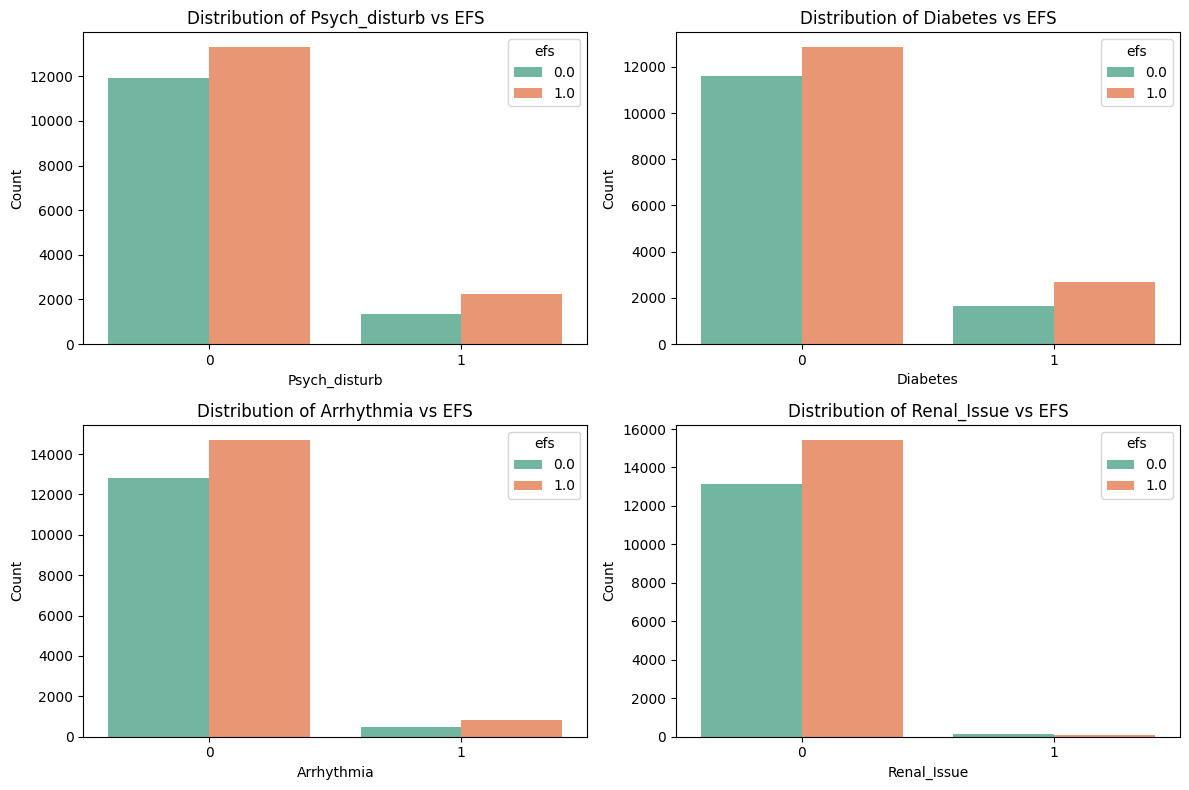

In [45]:
# Set the overall figure sizecc
plt.figure(figsize=(12, 8))

# Plot 1: Psych_disturb vs EFS
plt.subplot(2, 2, 1)
sns.countplot(x='psych_disturb', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Psych_disturb vs EFS")  # Add title for the plot
plt.xlabel("Psych_disturb")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 2: Diabetes vs EFS
plt.subplot(2, 2, 2)
sns.countplot(x='diabetes', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Diabetes vs EFS")  # Add title for the plot
plt.xlabel("Diabetes")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 3: Arrhythmia vs EFS
plt.subplot(2, 2, 3)
sns.countplot(x='arrhythmia', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Arrhythmia vs EFS")  # Add title for the plot
plt.xlabel("Arrhythmia")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: Renal_issue vs EFS
plt.subplot(2, 2, 4)
sns.countplot(x='renal_issue', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Renal_Issue vs EFS")  # Add title for the plot
plt.xlabel("Renal_Issue")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()

In [46]:
# 7-  Is there a relationship between the 'cyto_score' column and the 'tbi_status' 
# and 'graft_type' and 'vent_hist' and  'efs' or 'efs_time' columns?
# Logistic Regression Model using the Logit function ?

# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(cyto_score) + C(tbi_status) + C(graft_type) + C(vent_hist)' , data=data_train).fit()

# Print the Model Logistic results
print(model_logistic.summary())

Optimization terminated successfully.
         Current function value: 0.661593
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28787
Method:                           MLE   Df Model:                           12
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                 0.04125
Time:                        20:27:18   Log-Likelihood:                -19054.
converged:                       True   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4636      0.045    -10.317      0.000      -0.552      -0.376
C(cyt

In [47]:
# Model with categorical variable dri_score
model_ols = ols(formula='efs_time ~ C(cyto_score) + C(tbi_status) + C(graft_type) + (vent_hist)' , data=data_train).fit()
# print the model OLS results
print(model_ols.summary())


                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     60.52
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          8.50e-146
Time:                        20:27:19   Log-Likelihood:            -1.3298e+05
No. Observations:               28800   AIC:                         2.660e+05
Df Residuals:                   28787   BIC:                         2.661e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             29.1978      0

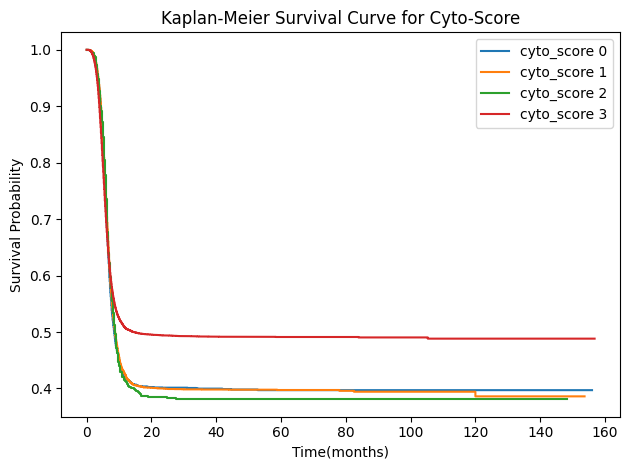

In [48]:
# Plot Kaplan-Meier curve for 'cyto_score' column
plot_kaplan_meier('cyto_score', 'Kaplan-Meier Survival Curve for Cyto-Score')

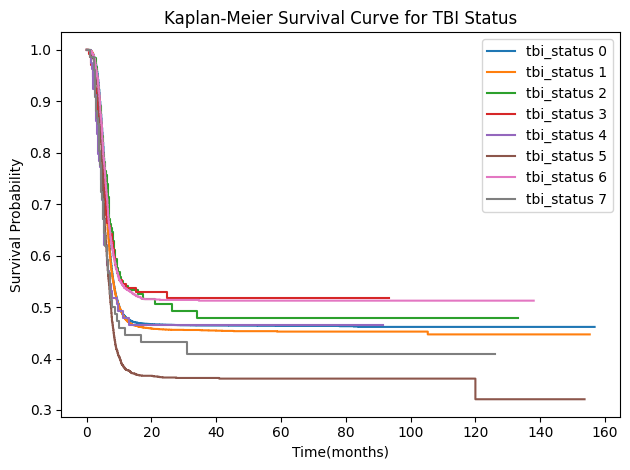

In [49]:
# Plot Kaplan-Meier curve for 'tbi_status' column
plot_kaplan_meier('tbi_status' , 'Kaplan-Meier Survival Curve for TBI Status')

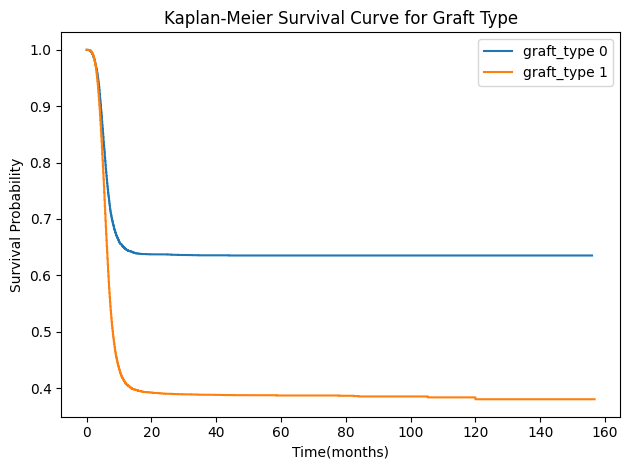

In [50]:
# plot Kaplan-Meier curve for 'graft_type' column
plot_kaplan_meier('graft_type' , 'Kaplan-Meier Survival Curve for Graft Type')

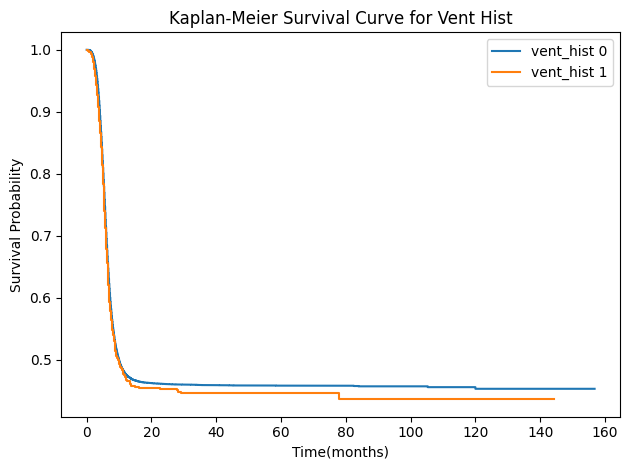

In [51]:
# plot Kaplan-Meier curve for 'vent_hist' column
plot_kaplan_meier('vent_hist' , 'Kaplan-Meier Survival Curve for Vent Hist')

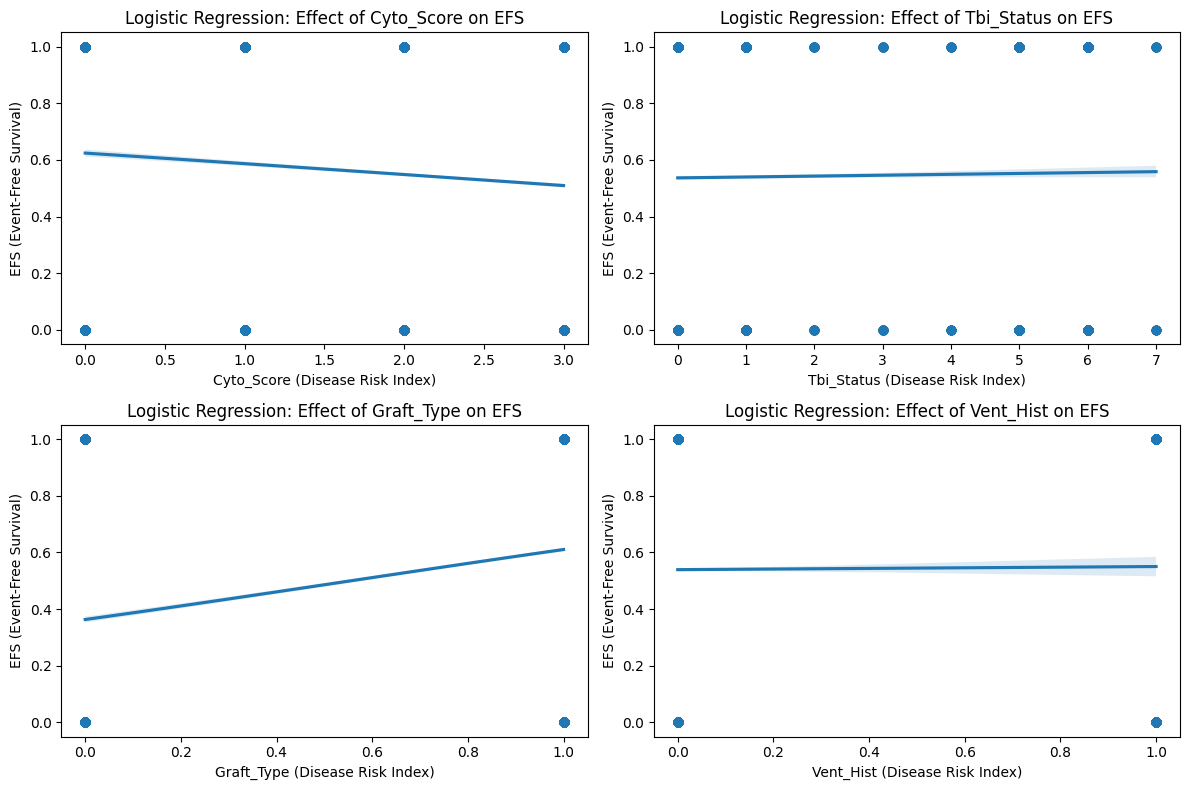

In [52]:
plt.figure(figsize=(12,8))

# First subplot: Logistic regression plot for 'cyto_score' vs 'efs'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='cyto_score' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Cyto_Score on EFS")  # Title of the plot
plt.xlabel("Cyto_Score (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Second subplot: Logistic regression plot for 'tbi_status' vs 'efs'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='tbi_status' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Tbi_Status on EFS")  # Title of the plot
plt.xlabel("Tbi_Status (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'graft_type' vs 'efs'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='graft_type' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Graft_Type on EFS")  # Title of the plot
plt.xlabel("Graft_Type (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'vent_hist' vs 'efs'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='vent_hist' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Vent_Hist on EFS")  # Title of the plot
plt.xlabel("Vent_Hist (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

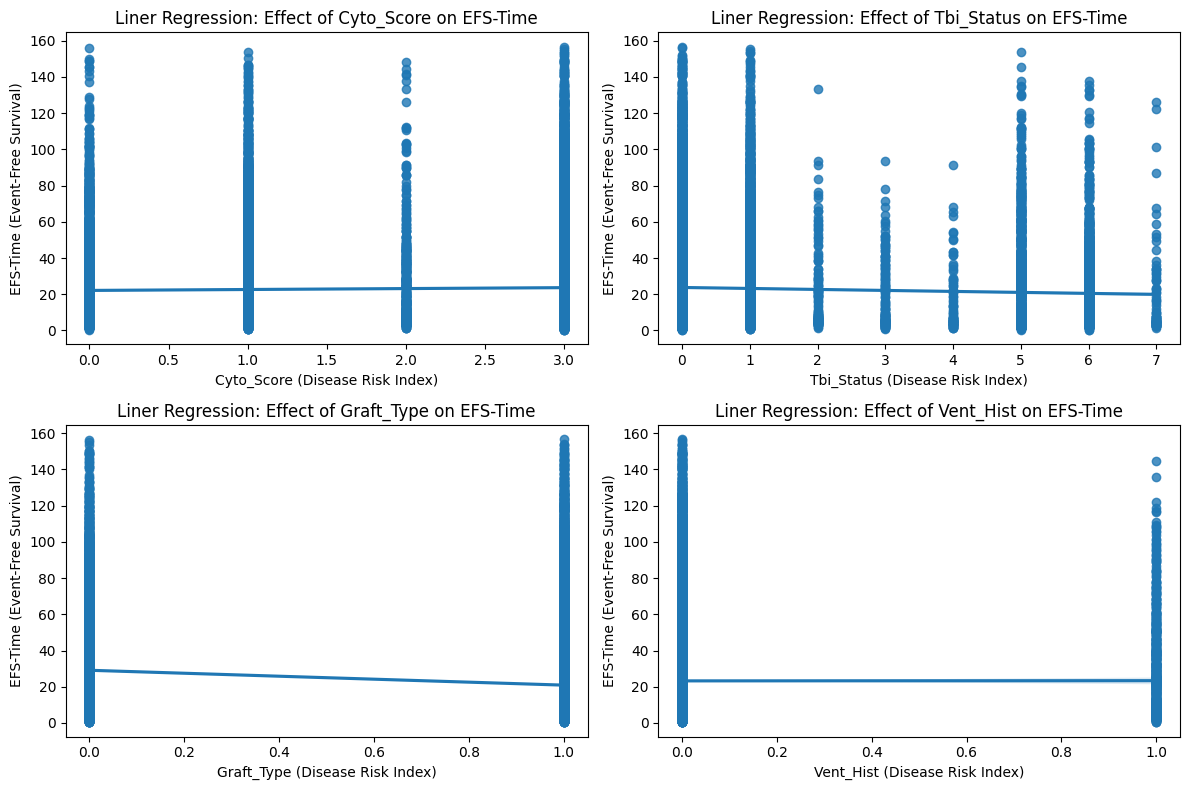

In [53]:
# Set the figure size for the plot to make it larger and more readable
plt.figure(figsize=(12,8))

# First subplot: Liner regression plot for 'cyto_score' vs 'efs-time'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1) 

sns.regplot(x='cyto_score' , y='efs_time' , data=data_train , logistic=False)  # Liner regression plot
# Set title and axis labels for this plot
plt.title("Liner Regression: Effect of Cyto_Score on EFS-Time")  # Title of the plot
plt.xlabel("Cyto_Score (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Second subplot: Liner regression plot for 'tbi_status' vs 'efs-time'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='tbi_status' , y='efs_time' , data=data_train , logistic=False)  # Liner regression plot
# Set title and axis labels for this plot
plt.title("Liner Regression: Effect of Tbi_Status on EFS-Time")  # Title of the plot
plt.xlabel("Tbi_Status (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label


# Third subplot: Liner regression plot for 'graft_type' vs 'efs-time'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='graft_type' , y='efs_time' , data=data_train , logistic=False)  # Liner regression plot
# Set title and axis labels for this plot
plt.title("Liner Regression: Effect of Graft_Type on EFS-Time")  # Title of the plot
plt.xlabel("Graft_Type (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label


# Fourth subplot: Liner regression plot for 'vent_hist' vs 'efs-time'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='vent_hist' , y='efs_time' , data=data_train , logistic=False)  # Liner regression plot
# Set title and axis labels for this plot
plt.title("Liner Regression: Effect of Vent_Hist on EFS-Time")  # Title of the plot
plt.xlabel("Vent_Hist (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label


# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

In [54]:
# Test the function with 'cyto_score' as the first variable and 'efs' as the second variable.
# This checks if there's a significant association between these two categorical variables.
chi2_contingency_test('cyto_score', 'efs')


Title: cyto_score
Chi2: 237.76477523956845
P-value: 2.896436862069588e-51
Degrees of Freedom: 3
Expected Frequencies: [[ 1387.15097222  1623.84902778]
 [ 2937.38777778  3438.61222222]
 [  296.22652778   346.77347222]
 [ 8647.23472222 10122.76527778]]
Cramér's V: 0.09086100022828834


In [55]:

# Test the function with 'tbi_status' as the first variable and 'efs' as the second variable.
chi2_contingency_test('tbi_status' , 'efs')

Title: tbi_status
Chi2: 92.45486618938138
P-value: 3.872202121618803e-17
Degrees of Freedom: 7
Expected Frequencies: [[ 8689.15791667 10171.84208333]
 [ 2812.07888889  3291.92111111]
 [   54.82263889    64.17736111]
 [   61.73305556    72.26694444]
 [   36.39486111    42.60513889]
 [  795.61930556   931.38069444]
 [  783.18055556   916.81944444]
 [   35.01277778    40.98722222]]
Cramér's V: 0.056658965833780627


In [56]:

# Test the function with 'graft_type' as the first variable and 'efs' as the second variable.
chi2_contingency_test('graft_type' , 'efs')

Title: graft_type
Chi2: 1444.9030377356244
P-value: 0.0
Degrees of Freedom: 1
Expected Frequencies: [[ 3802.57194444  4451.42805556]
 [ 9465.42805556 11080.57194444]]
Cramér's V: 0.22398715223382856


In [57]:

# Test the function with 'vent_hist' as the first variable and 'efs' as the second variable.
chi2_contingency_test('vent_hist' , 'efs')

Title: vent_hist
Chi2: 0.3454901927352513
P-value: 0.5566771922677142
Degrees of Freedom: 1
Expected Frequencies: [[12890.23055556 15089.76944444]
 [  377.76944444   442.23055556]]
Cramér's V: 0.0034635512480331197


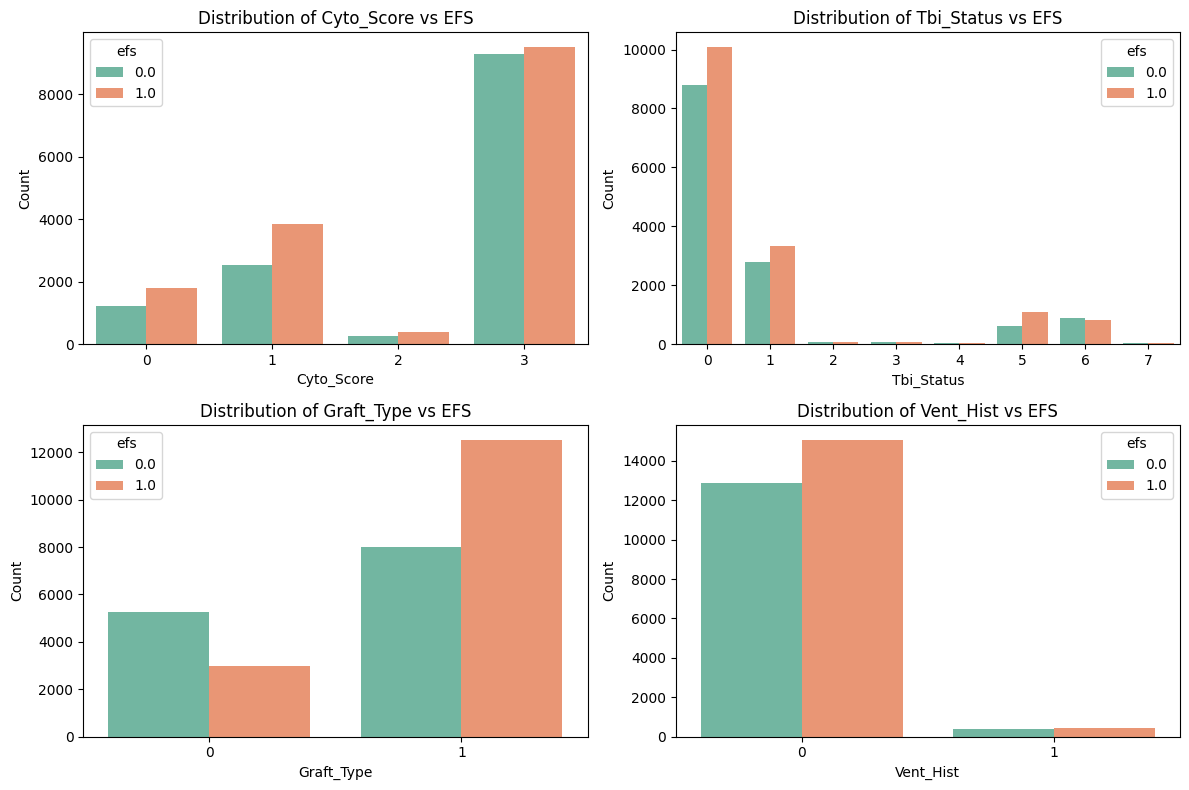

In [58]:
# Set the overall figure size
plt.figure(figsize=(12, 8))

# Plot 1: Cyto-Score vs EFS
plt.subplot(2, 2, 1)
sns.countplot(x='cyto_score', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Cyto_Score vs EFS")  # Add title for the plot
plt.xlabel("Cyto_Score")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 2: Tbi_Status vs EFS
plt.subplot(2, 2, 2)
sns.countplot(x='tbi_status', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Tbi_Status vs EFS")  # Add title for the plot
plt.xlabel("Tbi_Status")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 3: Graft_Type vs EFS
plt.subplot(2, 2, 3)
sns.countplot(x='graft_type', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Graft_Type vs EFS")  # Add title for the plot
plt.xlabel("Graft_Type")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: Vent_Hist vs EFS
plt.subplot(2, 2, 4)
sns.countplot(x='vent_hist', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Vent_Hist vs EFS")  # Add title for the plot
plt.xlabel("Vent_Hist")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()

In [59]:

# 8- Is there a relationship between the 'hla_match_c_high' column and 'hla_match_dqb1_high' and 
# 'hla_match_c_low' and 'hla_match_drb1_low'  the 'efs' or 'efs_time' columns?

# Test the function with 'hla_match_c_high' as the first variable and 'efs' as the second variable.
# This checks if there's a significant association between these two categorical variables.
chi2_contingency_test('hla_match_c_high', 'efs')

Title: hla_match_c_high
Chi2: 29.106021512446713
P-value: 4.783080977051506e-07
Degrees of Freedom: 2
Expected Frequencies: [[   36.39486111    42.60513889]
 [ 2550.40444444  2985.59555556]
 [10681.20069444 12503.79930556]]
Cramér's V: 0.031790340466247846


In [60]:
# Test the function with 'hla_match_dqb1_high' as the first variable and 'efs' as the second variable.
chi2_contingency_test('hla_match_dqb1_high' , 'efs')

Title: hla_match_dqb1_high
Chi2: 59.57134826773729
P-value: 1.1594341391868617e-13
Degrees of Freedom: 2
Expected Frequencies: [[   35.47347222    41.52652778]
 [ 2789.96555556  3266.03444444]
 [10442.56097222 12224.43902778]]
Cramér's V: 0.045480211000277555


In [61]:
# Test the function with 'hla_match_c_low' as the first variable and 'efs' as the second variable.
chi2_contingency_test('hla_match_c_low' , 'efs')

Title: hla_match_c_low
Chi2: 9.056070044025814
P-value: 0.010801880690392628
Degrees of Freedom: 2
Expected Frequencies: [[   36.39486111    42.60513889]
 [ 2828.20319444  3310.79680556]
 [10403.40194444 12178.59805556]]
Cramér's V: 0.017732650014272378


In [62]:
# Test the function with 'hla_match_drb1_low' as the first variable and 'efs' as the second variable.
chi2_contingency_test('hla_match_drb1_low' , 'efs')

Title: hla_match_drb1_low
Chi2: 111.27818205825358
P-value: 5.1424026760874303e-26
Degrees of Freedom: 1
Expected Frequencies: [[ 3430.79152778  4016.20847222]
 [ 9837.20847222 11515.79152778]]
Cramér's V: 0.06215967958340505


In [63]:
# Logistic Regression Model using the Logit function ?

# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(hla_match_c_high) + C(hla_match_dqb1_high) + C(hla_match_c_low) + C(hla_match_drb1_low)' , data=data_train).fit()

# Print the Model Logistic results
print(model_logistic.summary())

Optimization terminated successfully.
         Current function value: 0.687261
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28792
Method:                           MLE   Df Model:                            7
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                0.004048
Time:                        20:28:58   Log-Likelihood:                -19793.
converged:                       True   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                 2.062e-31
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.2711      0.389     -0.697      0.

In [64]:
# Regression Model using the OLS function ?
model_ols = ols(formula='efs_time ~ C(hla_match_c_high) + C(hla_match_dqb1_high) + C(hla_match_c_low) + (hla_match_drb1_low)' , data=data_train).fit()
# print the model OLS results
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     10.82
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           1.05e-13
Time:                        20:28:59   Log-Likelihood:            -1.3330e+05
No. Observations:               28800   AIC:                         2.666e+05
Df Residuals:                   28792   BIC:                         2.667e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

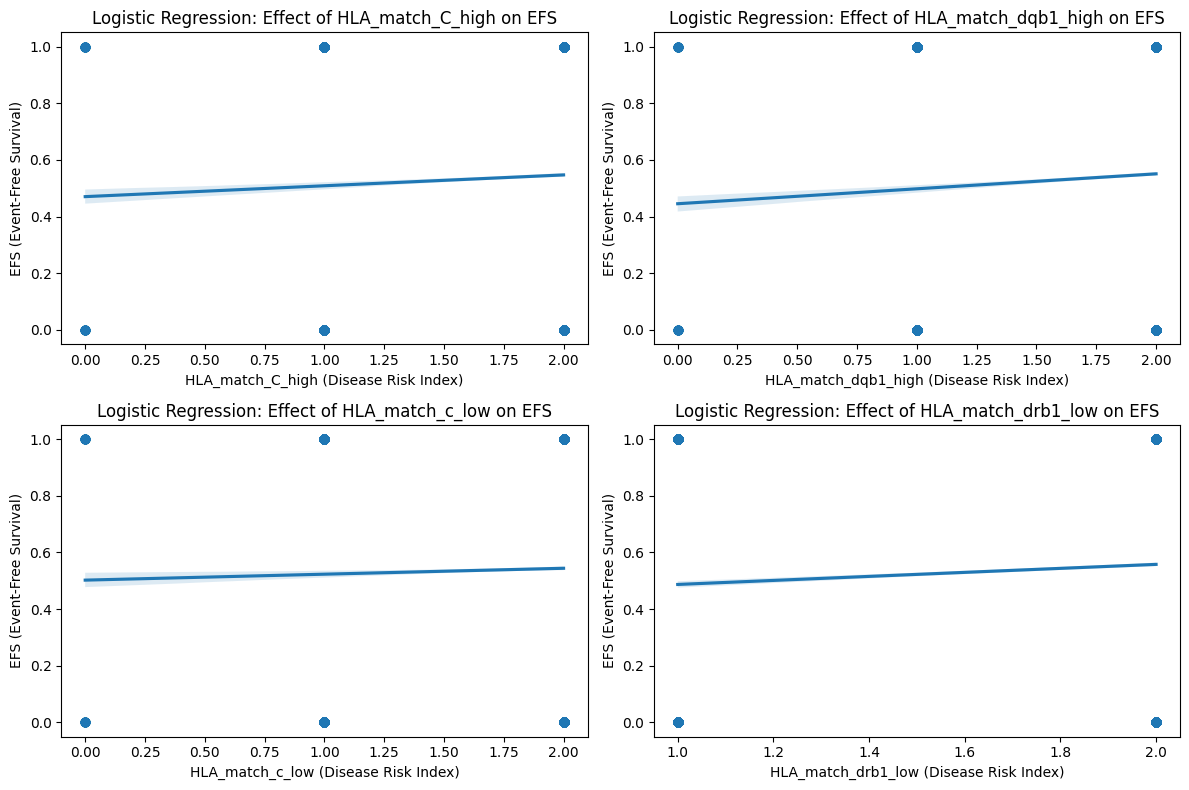

In [65]:
plt.figure(figsize=(12,8))

# First subplot: Logistic regression plot for 'hla_match_c_high' vs 'efs'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='hla_match_c_high' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_match_C_high on EFS")  # Title of the plot
plt.xlabel("HLA_match_C_high (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Second subplot: Logistic regression plot for 'hla_match_dqb1_high' vs 'efs'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='hla_match_dqb1_high' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_match_dqb1_high on EFS")  # Title of the plot
plt.xlabel("HLA_match_dqb1_high (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'hla_match_c_low' vs 'efs'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='hla_match_c_low' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_match_c_low on EFS")  # Title of the plot
plt.xlabel("HLA_match_c_low (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'hla_match_drb1_low' vs 'efs'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='hla_match_drb1_low' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_match_drb1_low on EFS")  # Title of the plot
plt.xlabel("HLA_match_drb1_low (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

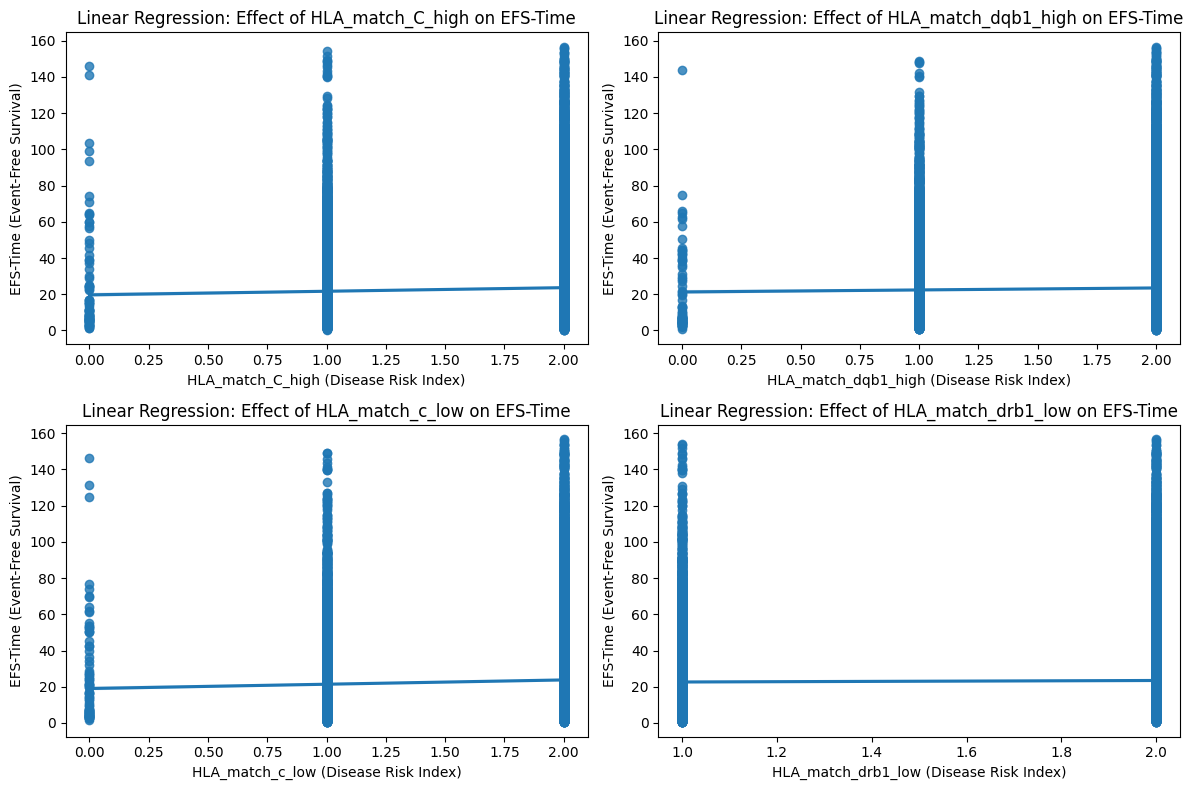

In [66]:
plt.figure(figsize=(12,8))

# First subplot: Linear regression plot for 'hla_match_c_high' vs 'efs-time'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='hla_match_c_high' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_match_C_high on EFS-Time")  # Title of the plot
plt.xlabel("HLA_match_C_high (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Second subplot: Liner regression plot for 'hla_match_dqb1_high' vs 'efs-time'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='hla_match_dqb1_high' , y='efs_time' , data=data_train , logistic=False)  # Linear  regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_match_dqb1_high on EFS-Time")  # Title of the plot
plt.xlabel("HLA_match_dqb1_high (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Third subplot: Liner regression plot for 'hla_match_c_low' vs 'efs-time'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='hla_match_c_low' , y='efs_time' , data=data_train , logistic=False)  # Linear  regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_match_c_low on EFS-Time")  # Title of the plot
plt.xlabel("HLA_match_c_low (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Liner regression plot for 'hla_match_drb1_low' vs 'efs_time'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='hla_match_drb1_low' , y='efs_time' , data=data_train , logistic=False)  # Linear  regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_match_drb1_low on EFS-Time")  # Title of the plot
plt.xlabel("HLA_match_drb1_low (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()



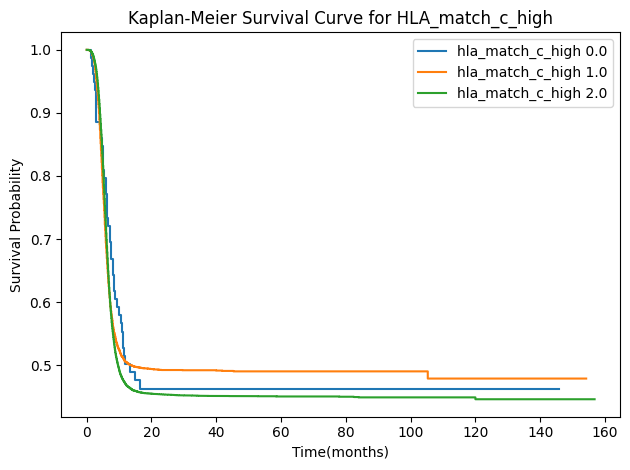

In [67]:

# Plot Kaplan-Meier curve for 'hla_match_c_high' column
plot_kaplan_meier('hla_match_c_high','Kaplan-Meier Survival Curve for HLA_match_c_high')

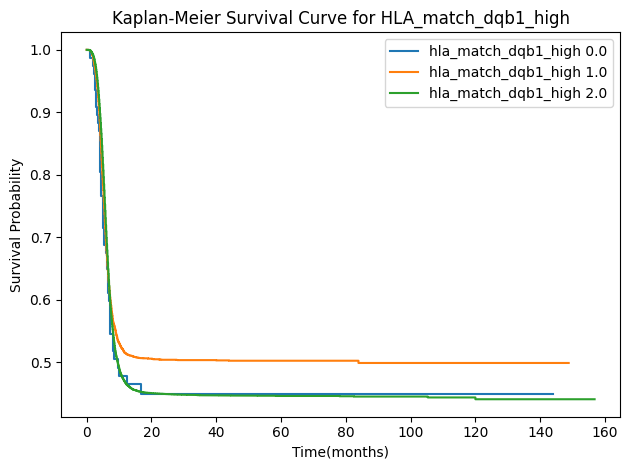

In [68]:
# Plot Kaplan-Meier curve for 'hla_match_dqb1_high' column
plot_kaplan_meier('hla_match_dqb1_high', 'Kaplan-Meier Survival Curve for HLA_match_dqb1_high')

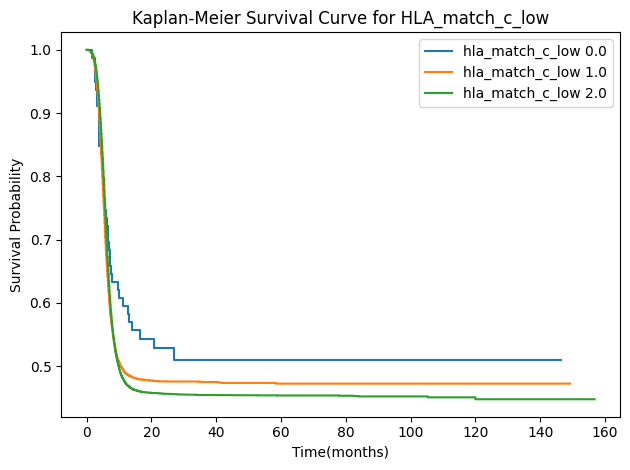

In [69]:
# Plot Kaplan-Meier curve for 'hla_match_c_low' column
plot_kaplan_meier('hla_match_c_low','Kaplan-Meier Survival Curve for HLA_match_c_low')

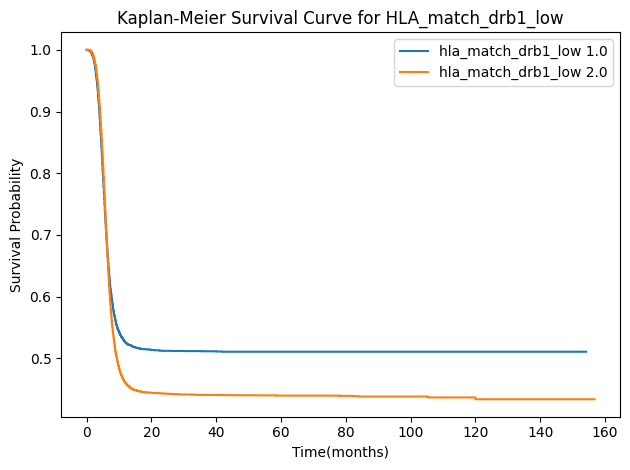

In [70]:

# Plot Kaplan-Meier curve for 'hla_match_drb1_low' column
plot_kaplan_meier('hla_match_drb1_low','Kaplan-Meier Survival Curve for HLA_match_drb1_low')

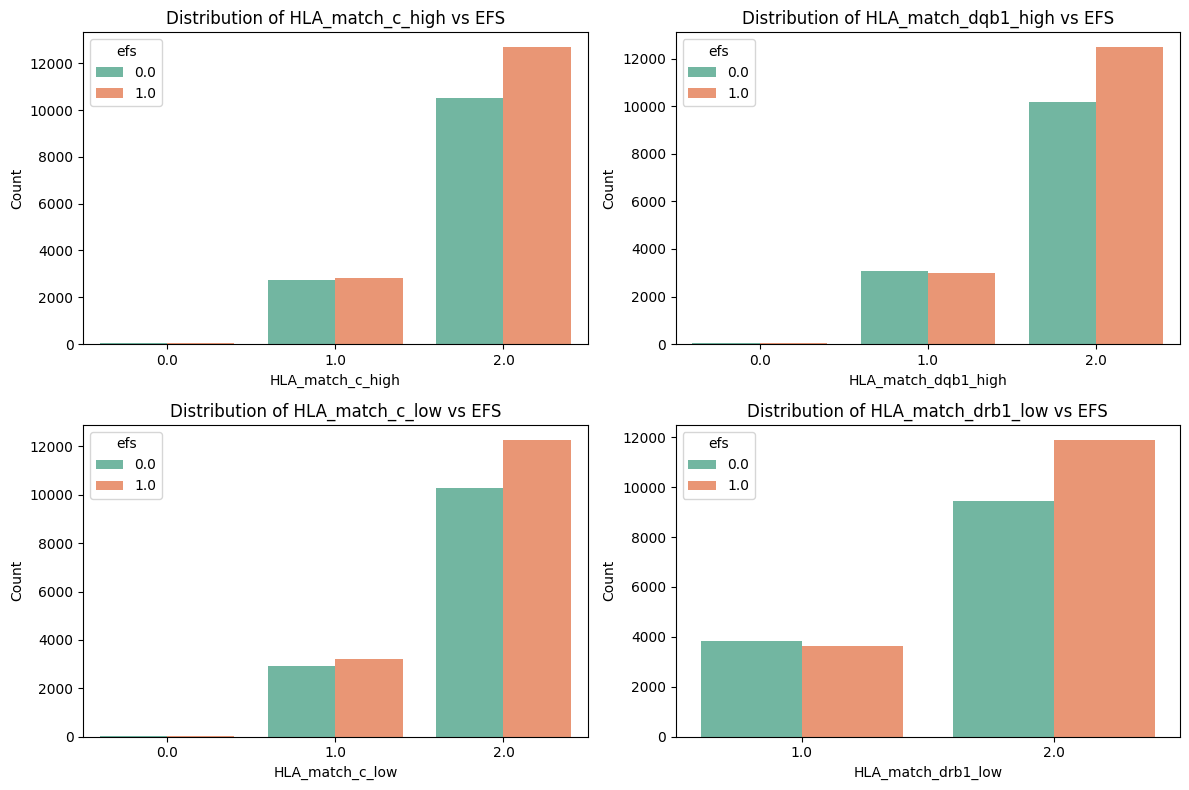

In [71]:
# Set the overall figure size
plt.figure(figsize=(12, 8))

# Plot 1: Hla_Match_c_High vs EFS
plt.subplot(2, 2, 1)
sns.countplot(x='hla_match_c_high', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_match_c_high vs EFS")  # Add title for the plot
plt.xlabel("HLA_match_c_high")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 2: Hla_Match_Dqb1_High vs EFS
plt.subplot(2, 2, 2)
sns.countplot(x='hla_match_dqb1_high', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_match_dqb1_high vs EFS")  # Add title for the plot
plt.xlabel("HLA_match_dqb1_high")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 3: Hla_Match_c_Low vs EFS
plt.subplot(2, 2, 3)
sns.countplot(x='hla_match_c_low', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_match_c_low vs EFS")  # Add title for the plot
plt.xlabel("HLA_match_c_low")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: hla_Match_Drb1_Low vs EFS
plt.subplot(2, 2, 4)
sns.countplot(x='hla_match_drb1_low', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_match_drb1_low vs EFS")  # Add title for the plot
plt.xlabel("HLA_match_drb1_low")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()


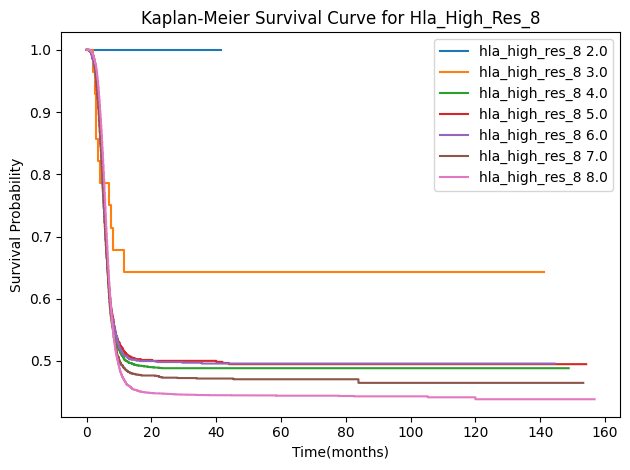

In [72]:
# Plot Kaplan-Meier curve for 'hla_high_res_8' column
plot_kaplan_meier('hla_high_res_8', 'Kaplan-Meier Survival Curve for Hla_High_Res_8')

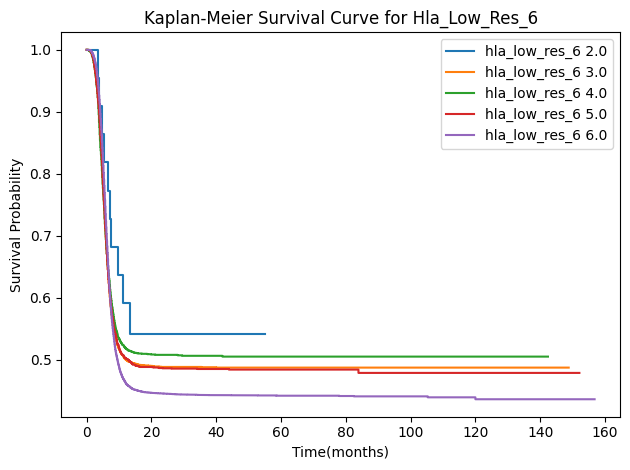

In [73]:
# Plot Kaplan-Meier curve for 'hla_low_res_6' column
plot_kaplan_meier('hla_low_res_6', 'Kaplan-Meier Survival Curve for Hla_Low_Res_6')

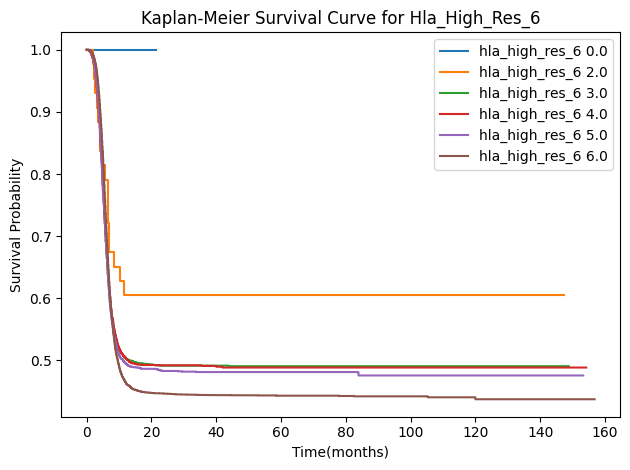

In [74]:
# plot Kaplan-Meier curve for 'hla_high_res_6' column
plot_kaplan_meier('hla_high_res_6' , 'Kaplan-Meier Survival Curve for Hla_High_Res_6')

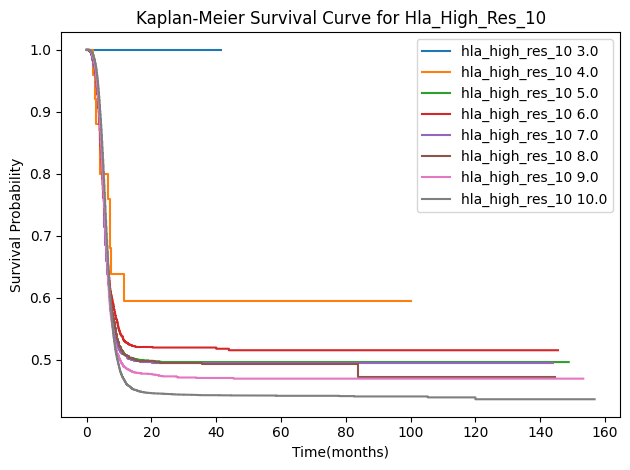

In [75]:
# plot Kaplan-Meier curve for 'hla_high_res_10' column
plot_kaplan_meier('hla_high_res_10' , 'Kaplan-Meier Survival Curve for Hla_High_Res_10')

In [76]:
# Logistic Regression Model using the Logit function ?

# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(hla_high_res_8) + C(hla_low_res_6) + C(hla_high_res_6) + C(hla_high_res_10)' , data=data_train).fit()

# Print the Model Logistic results
print(model_logistic.summary())

         Current function value: 0.688168
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28777
Method:                           MLE   Df Model:                           22
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                0.002734
Time:                        20:30:39   Log-Likelihood:                -19819.
converged:                      False   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                 1.912e-13
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -37.1973        nan        nan        nan         nan         nan
C(hla_high_res_8)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [77]:
# Regression Model using the OLS function ?
model_ols = ols(formula='efs_time ~ C(hla_high_res_8) + C(hla_low_res_6) + C(hla_high_res_6) + (hla_high_res_10)' , data=data_train).fit()
# print the model OLS results
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.557
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           3.16e-09
Time:                        20:30:40   Log-Likelihood:            -1.3330e+05
No. Observations:               28800   AIC:                         2.666e+05
Df Residuals:                   28783   BIC:                         2.668e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

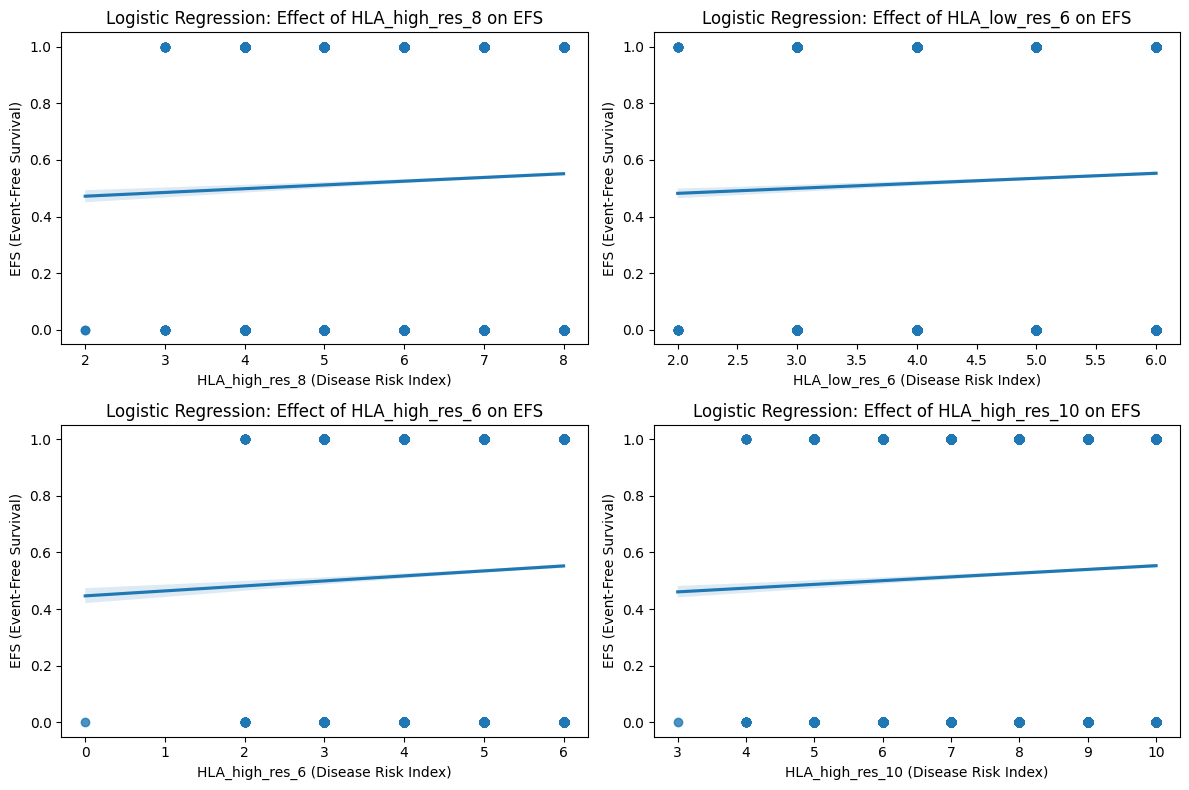

In [78]:
plt.figure(figsize=(12,8))

# First subplot: Logistic regression plot for 'hla_high_res_8' vs 'efs'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='hla_high_res_8' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_high_res_8 on EFS")  # Title of the plot
plt.xlabel("HLA_high_res_8 (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Second subplot: Logistic regression plot for 'hla_low_res_6' vs 'efs'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='hla_low_res_6' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_low_res_6 on EFS")  # Title of the plot
plt.xlabel("HLA_low_res_6 (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'hla_high_res_6' vs 'efs'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='hla_high_res_6' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_high_res_6 on EFS")  # Title of the plot
plt.xlabel("HLA_high_res_6 (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'hla_high_res_10' vs 'efs'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='hla_high_res_10' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_high_res_10 on EFS")  # Title of the plot
plt.xlabel("HLA_high_res_10 (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()


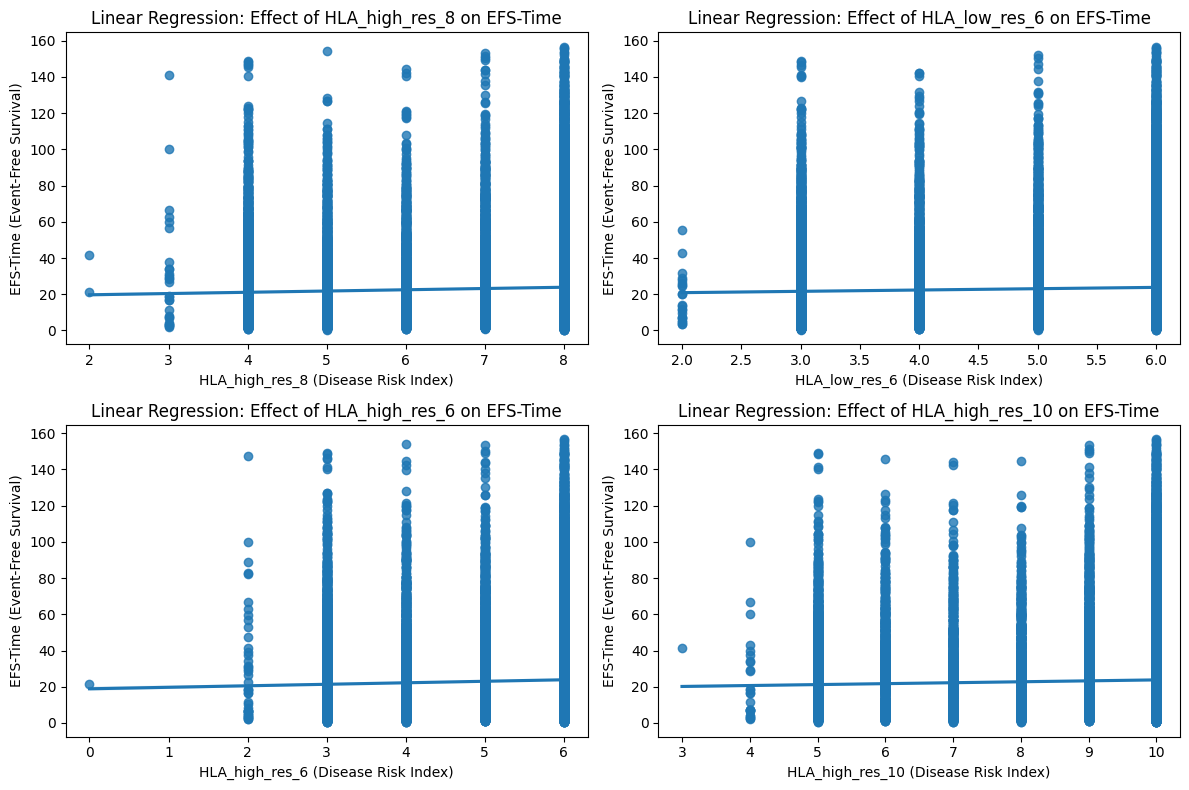

In [79]:
plt.figure(figsize=(12,8))

# First subplot: Linear regression plot for 'hla_high_res_8' vs 'efs_time'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='hla_high_res_8' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_high_res_8 on EFS-Time")  # Title of the plot
plt.xlabel("HLA_high_res_8 (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Second subplot: Linear regression plot for 'hla_low_res_6' vs 'efs_time'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='hla_low_res_6' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_low_res_6 on EFS-Time")  # Title of the plot
plt.xlabel("HLA_low_res_6 (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Third subplot: Linear regression plot for 'hla_high_res_6' vs 'efs_time'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='hla_high_res_6' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_high_res_6 on EFS-Time")  # Title of the plot
plt.xlabel("HLA_high_res_6 (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Linear regression plot for 'hla_high_res_10' vs 'efs_time'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='hla_high_res_10' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_high_res_10 on EFS-Time")  # Title of the plot
plt.xlabel("HLA_high_res_10 (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()


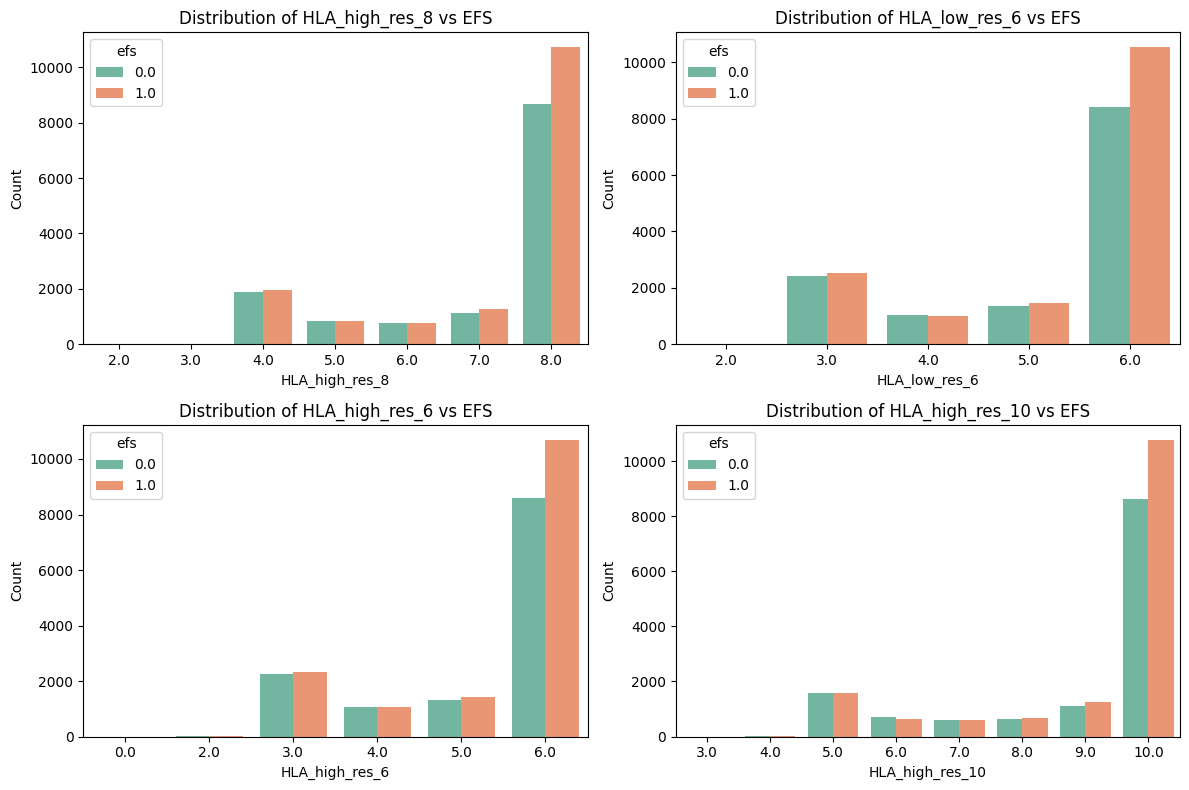

In [80]:
# Set the overall figure size
plt.figure(figsize=(12, 8))

# Plot 1: hla_high_res_8 vs EFS
plt.subplot(2, 2, 1)

sns.countplot(x='hla_high_res_8', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_high_res_8 vs EFS")  # Add title for the plot
plt.xlabel("HLA_high_res_8")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 2: hla_low_res_6 vs EFS
plt.subplot(2, 2, 2)

sns.countplot(x='hla_low_res_6', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_low_res_6 vs EFS")  # Add title for the plot
plt.xlabel("HLA_low_res_6")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 3: hla_high_res_6 vs EFS
plt.subplot(2, 2, 3)

sns.countplot(x='hla_high_res_6', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_high_res_6 vs EFS")  # Add title for the plot
plt.xlabel("HLA_high_res_6")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: hla_high_res_10 vs EFS
plt.subplot(2, 2, 4)

sns.countplot(x='hla_high_res_10', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_high_res_10 vs EFS")  # Add title for the plot
plt.xlabel("HLA_high_res_10")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()

In [81]:
#10- Is there a relationship between the 'pulm_severe' column and 'prim_disease_hct' and 'cmv_status' 
# and 'tce_imm_match'  the 'efs' or 'efs_time' columns?

# Test the function with 'pulm_severe' as the first variable and 'efs' as the second variable.
# This checks if there's a significant association between these two categorical variables.
chi2_contingency_test('pulm_severe', 'efs')

Title: pulm_severe
Chi2: 171.4163421965449
P-value: 3.6293642051641566e-39
Degrees of Freedom: 1
Expected Frequencies: [[12482.05527778 14611.94472222]
 [  785.94472222   920.05527778]]
Cramér's V: 0.07714892304024029


In [82]:
# Test the function with 'prim_disease_hct' as the first variable and 'efs' as the second variable.
chi2_contingency_test('prim_disease_hct' , 'efs')

Title: prim_disease_hct
Chi2: 2161.853494128376
P-value: 0.0
Degrees of Freedom: 17
Expected Frequencies: [[ 206.85180556  242.14819444]
 [3732.54638889 4369.45361111]
 [3287.05486111 3847.94513889]
 [   9.21388889   10.78611111]
 [  24.8775       29.1225    ]
 [ 205.00902778  239.99097222]
 [ 667.54625     781.45375   ]
 [ 471.75111111  552.24888889]
 [  66.34         77.66      ]
 [ 791.93375     927.06625   ]
 [1403.27527778 1642.72472222]
 [ 762.91        893.09      ]
 [ 607.65597222  711.34402778]
 [  38.23763889   44.76236111]
 [ 168.61416667  197.38583333]
 [ 400.34347222  468.65652778]
 [ 328.47513889  384.52486111]
 [  95.36375     111.63625   ]]
Cramér's V: 0.273978753619716


In [83]:
# Test the function with 'cmv_status' as the first variable and 'efs' as the second variable.
chi2_contingency_test('cmv_status' , 'efs')

Title: cmv_status
Chi2: 296.19481295143106
P-value: 6.62676029221056e-64
Degrees of Freedom: 3
Expected Frequencies: [[6555.68194444 7674.31805556]
 [1864.89111111 2183.10888889]
 [3262.17736111 3818.82263889]
 [1585.24958333 1855.75041667]]
Cramér's V: 0.10141273152996685


In [84]:
# Test the function with 'tce_imm_match' as the first variable and 'efs' as the second variable.
chi2_contingency_test('tce_imm_match' , 'efs')

Title: tce_imm_match
Chi2: 19.207488892058528
P-value: 0.0075616133558120665
Degrees of Freedom: 7
Expected Frequencies: [[2.50617778e+02 2.93382222e+02]
 [1.16187139e+03 1.36012861e+03]
 [1.05499028e+02 1.23500972e+02]
 [4.99392778e+02 5.84607222e+02]
 [3.04058333e+01 3.55941667e+01]
 [1.15173611e+01 1.34826389e+01]
 [3.82376389e+01 4.47623611e+01]
 [1.11704582e+04 1.30765418e+04]]
Cramér's V: 0.02582492396195817


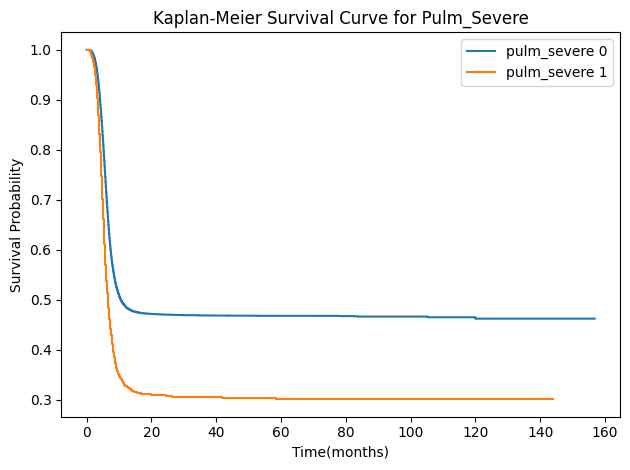

In [85]:
# Plot Kaplan-Meier curve for 'pulm_severe' column
plot_kaplan_meier('pulm_severe', 'Kaplan-Meier Survival Curve for Pulm_Severe')

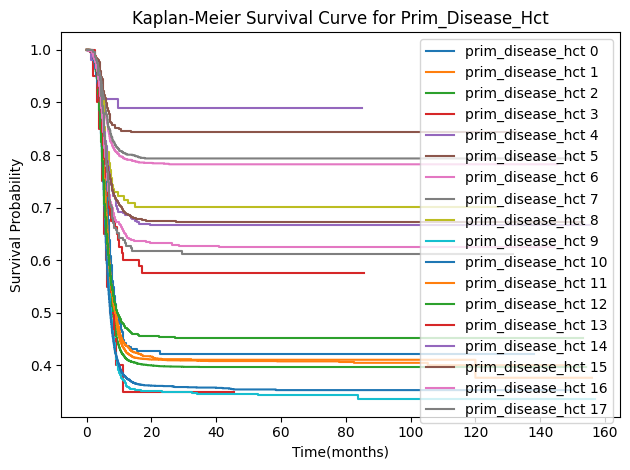

In [86]:
# Plot Kaplan-Meier curve for 'prim_disease_hct' column
plot_kaplan_meier('prim_disease_hct', 'Kaplan-Meier Survival Curve for Prim_Disease_Hct')

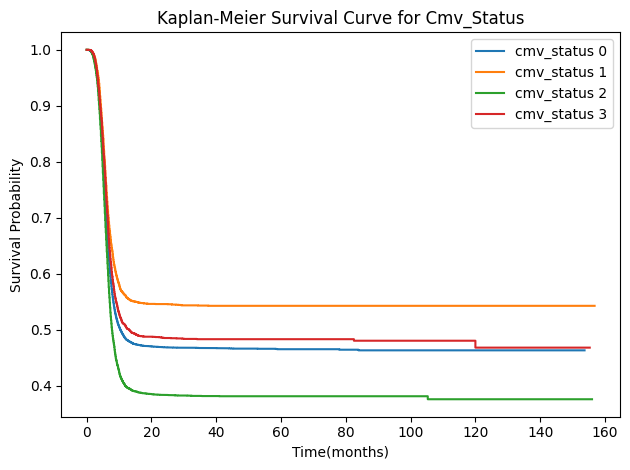

In [87]:
# plot Kaplan-Meier curve for 'cmv_status' column
plot_kaplan_meier('cmv_status' , 'Kaplan-Meier Survival Curve for Cmv_Status')

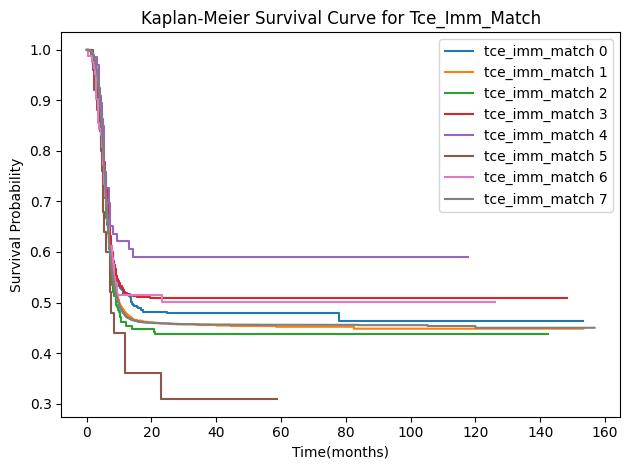

In [88]:
# plot Kaplan-Meier curve for 'tce_imm_match' column
plot_kaplan_meier('tce_imm_match' , 'Kaplan-Meier Survival Curve for Tce_Imm_Match')

In [89]:
# Logistic Regression Model using the Logit function ?
# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(pulm_severe) + C(prim_disease_hct) + C(cmv_status) + C(tce_imm_match)' , data=data_train).fit()

# Print the Model Logistic results
print(model_logistic.summary())

Optimization terminated successfully.
         Current function value: 0.643959
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28771
Method:                           MLE   Df Model:                           28
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                 0.06680
Time:                        20:32:20   Log-Likelihood:                -18546.
converged:                       True   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2451      0.131      1.873      0.061      -0.

In [90]:
# Regression Model using the OLS function ?
model_ols = ols(formula='efs_time ~ C(pulm_severe) + C(prim_disease_hct) + C(cmv_status) + (tce_imm_match)' , data=data_train).fit()

# print the model OLS results
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     62.96
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          7.98e-273
Time:                        20:32:20   Log-Likelihood:            -1.3266e+05
No. Observations:               28800   AIC:                         2.654e+05
Df Residuals:                   28777   BIC:                         2.656e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

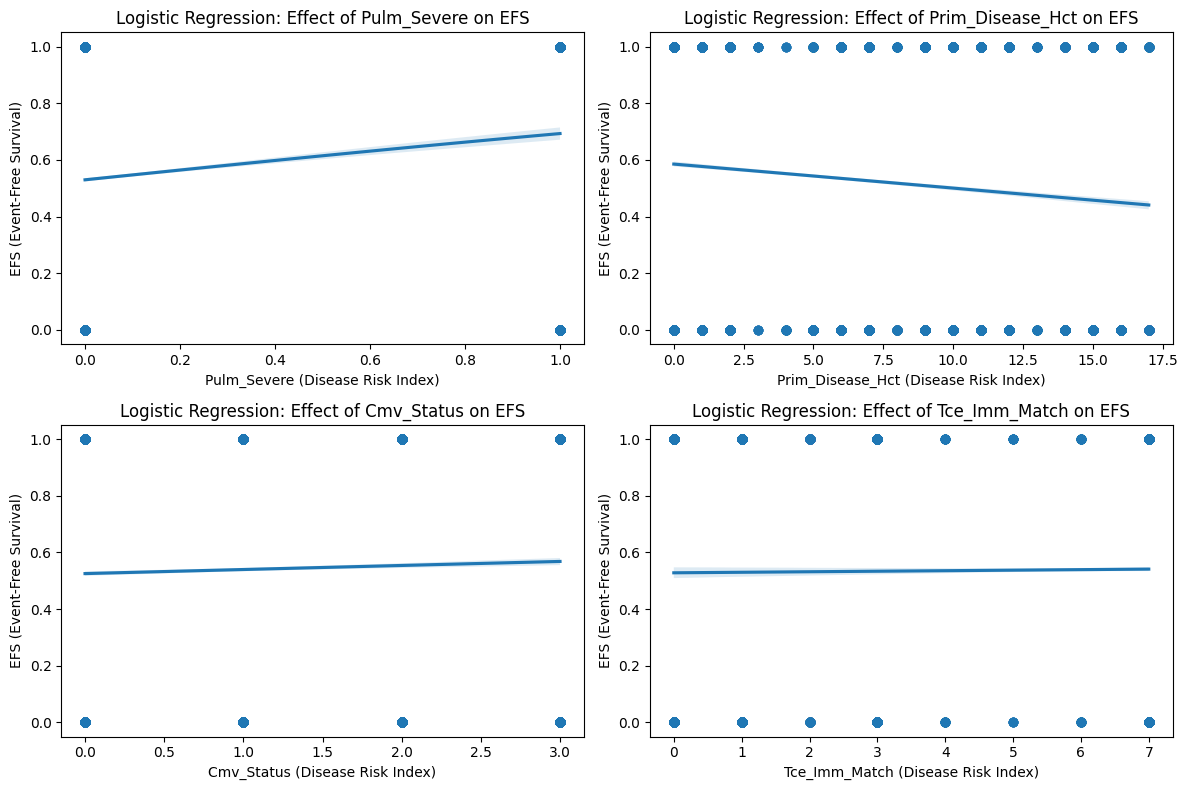

In [91]:
plt.figure(figsize=(12,8))

# First subplot: Logistic regression plot for 'pulm_severe' vs 'efs'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='pulm_severe' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Pulm_Severe on EFS")  # Title of the plot
plt.xlabel("Pulm_Severe (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Second subplot: Logistic regression plot for 'prim_disease_hct' vs 'efs'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='prim_disease_hct' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Prim_Disease_Hct on EFS")  # Title of the plot
plt.xlabel("Prim_Disease_Hct (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'cmv_status' vs 'efs'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='cmv_status' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Cmv_Status on EFS")  # Title of the plot
plt.xlabel("Cmv_Status (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'tce_imm_match' vs 'efs'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='tce_imm_match' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Tce_Imm_Match on EFS")  # Title of the plot
plt.xlabel("Tce_Imm_Match (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

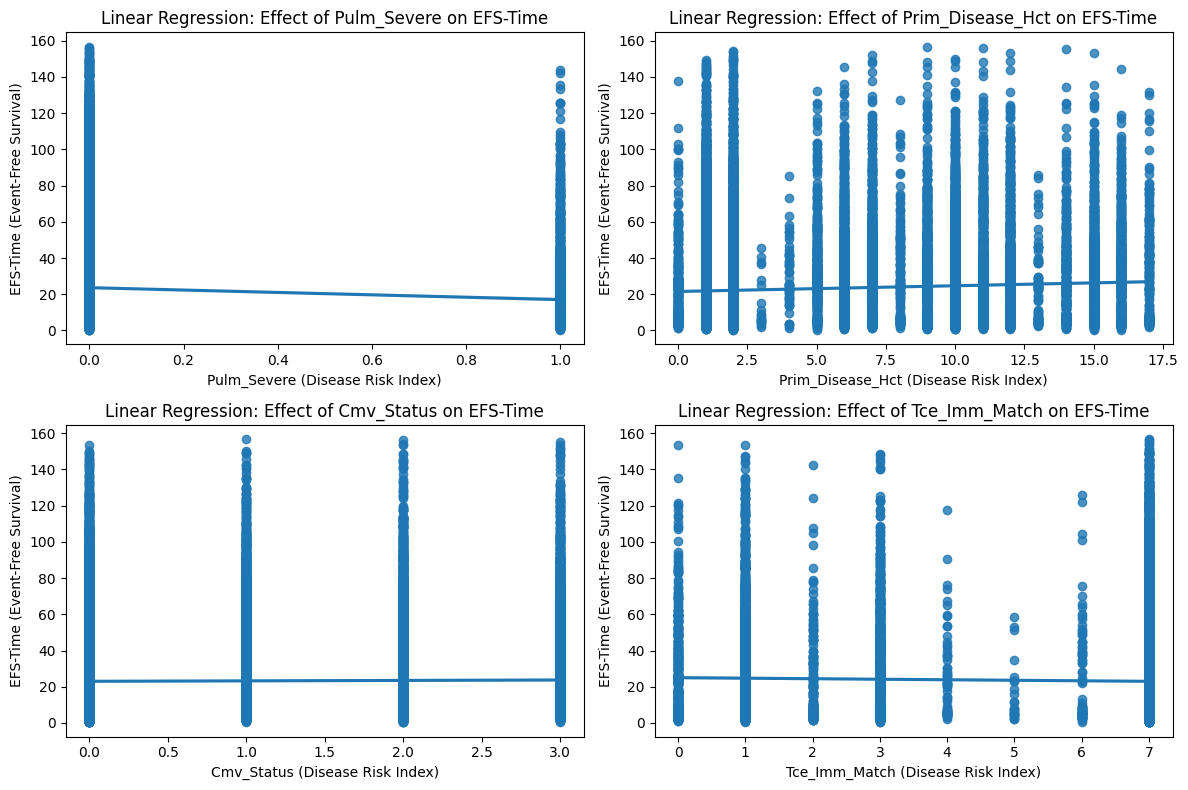

In [92]:
plt.figure(figsize=(12,8))

# First subplot: Linear regression plot for 'pulm_severe' vs 'efs_time'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='pulm_severe' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Pulm_Severe on EFS-Time")  # Title of the plot
plt.xlabel("Pulm_Severe (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Second subplot: Linear regression plot for 'prim_disease_hct' vs 'efs_time'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='prim_disease_hct' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Prim_Disease_Hct on EFS-Time")  # Title of the plot
plt.xlabel("Prim_Disease_Hct (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'cmv_status' vs 'efs_time'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='cmv_status' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Cmv_Status on EFS-Time")  # Title of the plot
plt.xlabel("Cmv_Status (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'tce_imm_match' vs 'efs_time'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='tce_imm_match' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Tce_Imm_Match on EFS-Time")  # Title of the plot
plt.xlabel("Tce_Imm_Match (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

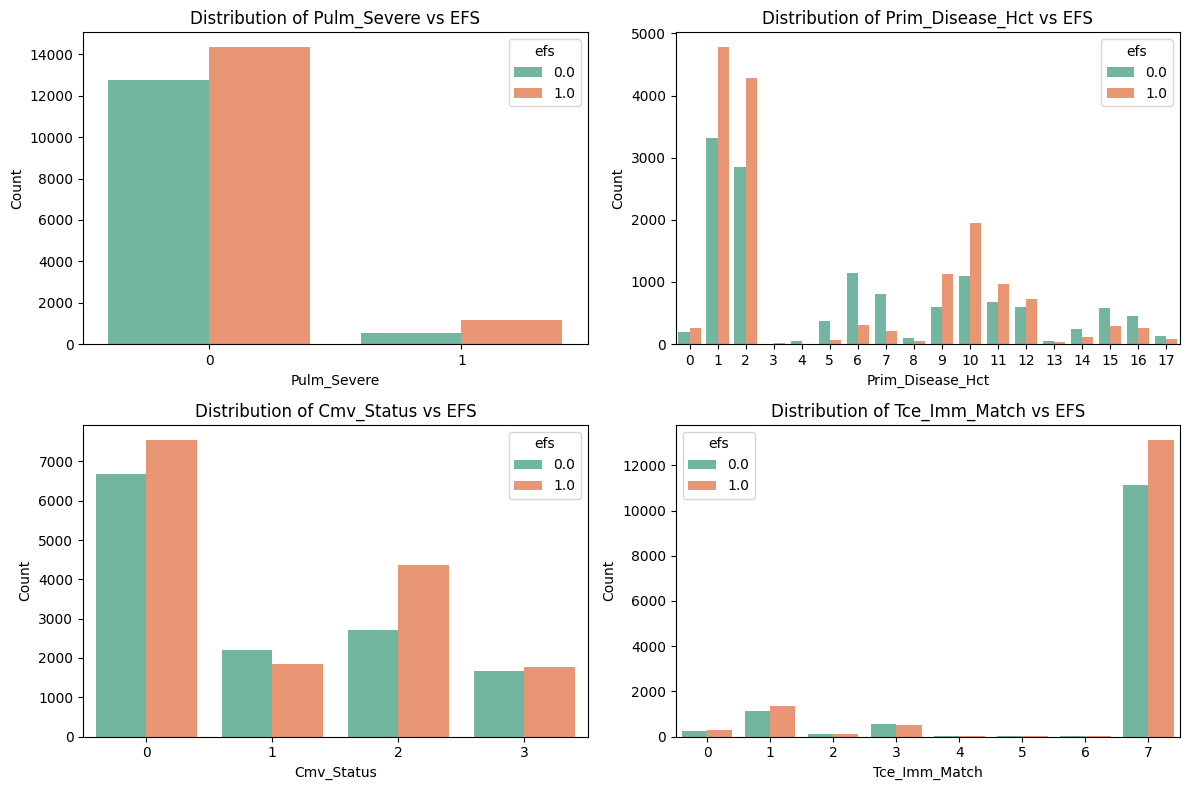

In [93]:
# Set the overall figure size
plt.figure(figsize=(12, 8))

# Plot 1: pulm_severe vs EFS
plt.subplot(2, 2, 1)

sns.countplot(x='pulm_severe', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Pulm_Severe vs EFS")  # Add title for the plot
plt.xlabel("Pulm_Severe")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 2: prim_disease_hct vs EFS
plt.subplot(2, 2, 2)

sns.countplot(x='prim_disease_hct', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Prim_Disease_Hct vs EFS")  # Add title for the plot
plt.xlabel("Prim_Disease_Hct")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 3: cmv_status vs EFS
plt.subplot(2, 2, 3)

sns.countplot(x='cmv_status', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Cmv_Status vs EFS")  # Add title for the plot
plt.xlabel("Cmv_Status")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: tce_imm_match vs EFS
plt.subplot(2, 2, 4)

sns.countplot(x='tce_imm_match', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Tce_Imm_Match vs EFS")  # Add title for the plot
plt.xlabel("Tce_Imm_Match")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()

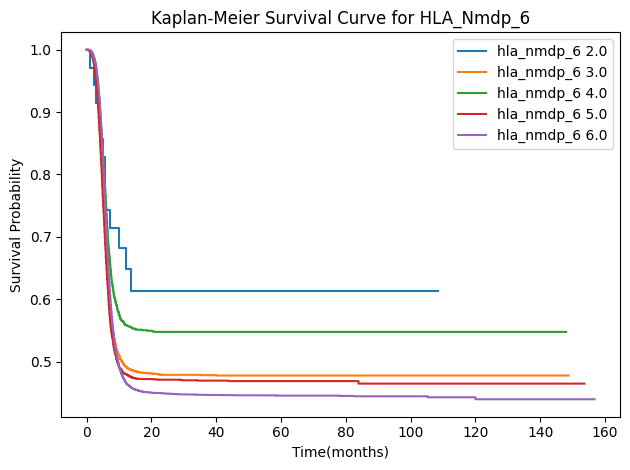

In [94]:
# 11-  Is there a relationship between the 'hla_nmdp_6' column and 'hla_match_b_low' 
#and 'hla_match_a_low' and 'hla_match_dqb1_low' and  the 'efs' or 'efs_time' columns?

# Plot Kaplan-Meier curve for 'hla_nmdp_6' column
plot_kaplan_meier('hla_nmdp_6', 'Kaplan-Meier Survival Curve for HLA_Nmdp_6')

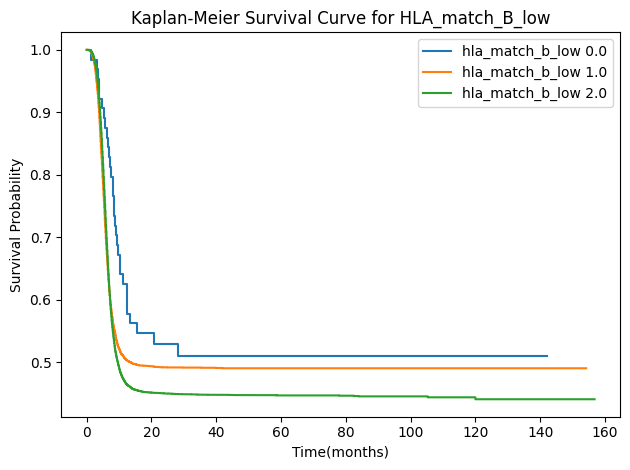

In [95]:
# Plot Kaplan-Meier curve for 'hla_match_b_low' column
plot_kaplan_meier('hla_match_b_low', 'Kaplan-Meier Survival Curve for HLA_match_B_low')

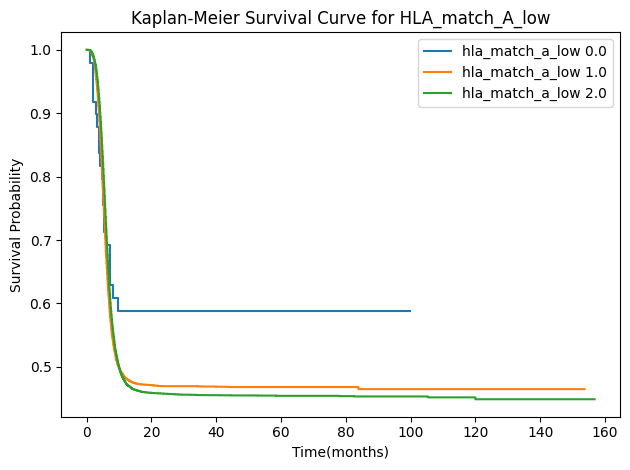

In [96]:
# plot Kaplan-Meier curve for 'hla_match_a_low' column
plot_kaplan_meier('hla_match_a_low' , 'Kaplan-Meier Survival Curve for HLA_match_A_low')

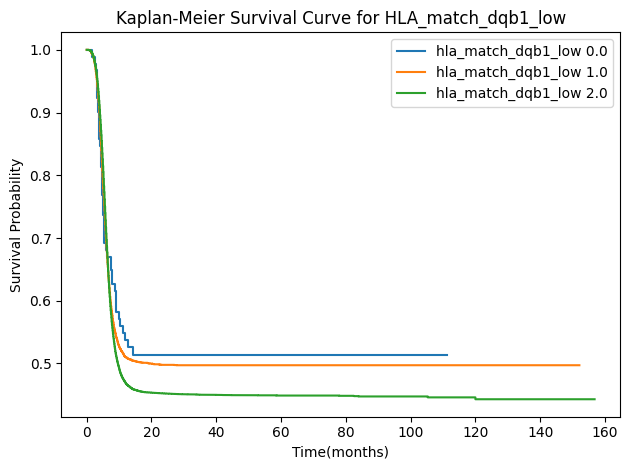

In [97]:
# plot Kaplan-Meier curve for 'hla_match_dqb1_low' column
plot_kaplan_meier('hla_match_dqb1_low' , 'Kaplan-Meier Survival Curve for HLA_match_dqb1_low')

In [98]:
# Logistic Regression Model using the Logit function ?
# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(hla_nmdp_6) + C(hla_match_b_low) + C(hla_match_a_low) + C(hla_match_dqb1_low)' , data=data_train).fit()

# Print the Model Logistic results
print(model_logistic.summary()) 

Optimization terminated successfully.
         Current function value: 0.688181
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28789
Method:                           MLE   Df Model:                           10
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                0.002714
Time:                        20:33:59   Log-Likelihood:                -19820.
converged:                       True   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                 1.427e-18
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.3976      0.563     -2.484      0.013

In [99]:
# Regression Model using the OLS function ?
model_ols = ols(formula='efs_time ~ C(hla_nmdp_6) + C(hla_match_b_low) + C(hla_match_a_low) + (hla_match_dqb1_low)' , data=data_train).fit()

# print the model OLS results
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     11.96
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           4.77e-19
Time:                        20:34:00   Log-Likelihood:            -1.3328e+05
No. Observations:               28800   AIC:                         2.666e+05
Df Residuals:                   28790   BIC:                         2.667e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

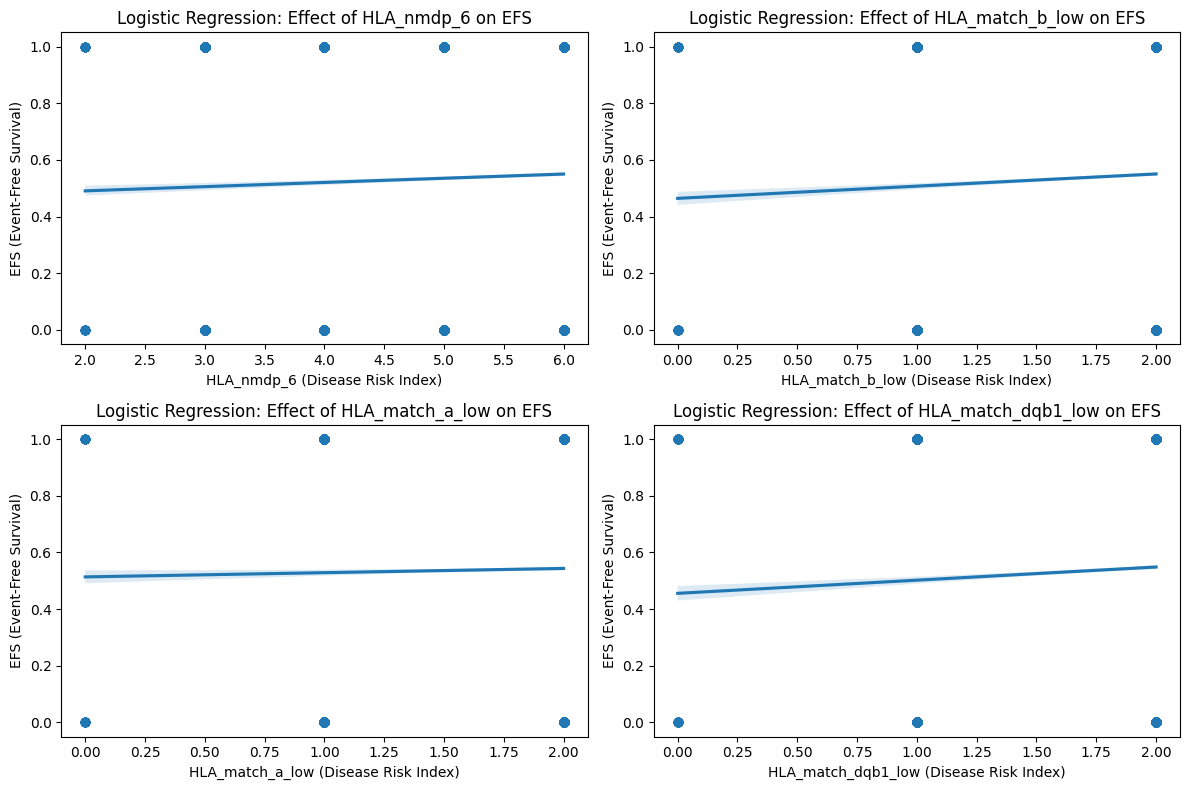

In [100]:

plt.figure(figsize=(12,8))

# First subplot: Logistic regression plot for 'hla_nmdp_6' vs 'efs'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='hla_nmdp_6' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_nmdp_6 on EFS")  # Title of the plot
plt.xlabel("HLA_nmdp_6 (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Second subplot: Logistic regression plot for 'hla_match_b_low' vs 'efs'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='hla_match_b_low' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_match_b_low on EFS")  # Title of the plot
plt.xlabel("HLA_match_b_low (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'hla_match_a_low' vs 'efs'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='hla_match_a_low' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_match_a_low on EFS")  # Title of the plot
plt.xlabel("HLA_match_a_low (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'hla_match_dqb1_low' vs 'efs'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='hla_match_dqb1_low' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_match_dqb1_low on EFS")  # Title of the plot
plt.xlabel("HLA_match_dqb1_low (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

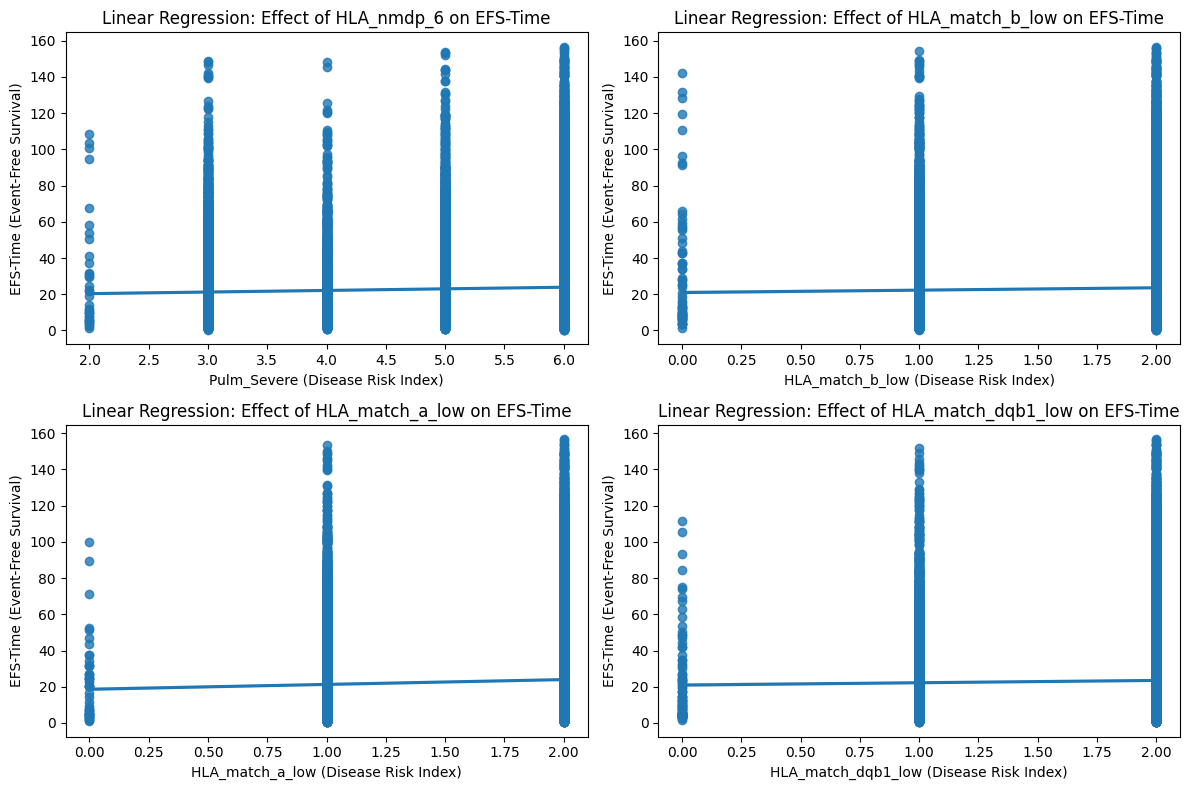

In [101]:
plt.figure(figsize=(12,8))

# First subplot: Linear regression plot for 'hla_nmdp_6' vs 'efs_time'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='hla_nmdp_6' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_nmdp_6 on EFS-Time")  # Title of the plot
plt.xlabel("Pulm_Severe (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Second subplot: Linear regression plot for 'hla_match_b_low' vs 'efs_time'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='hla_match_b_low' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_match_b_low on EFS-Time")  # Title of the plot
plt.xlabel("HLA_match_b_low (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'hla_match_a_low' vs 'efs_time'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='hla_match_a_low' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_match_a_low on EFS-Time")  # Title of the plot
plt.xlabel("HLA_match_a_low (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'hla_match_dqb1_low' vs 'efs_time'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='hla_match_dqb1_low' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_match_dqb1_low on EFS-Time")  # Title of the plot
plt.xlabel("HLA_match_dqb1_low (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

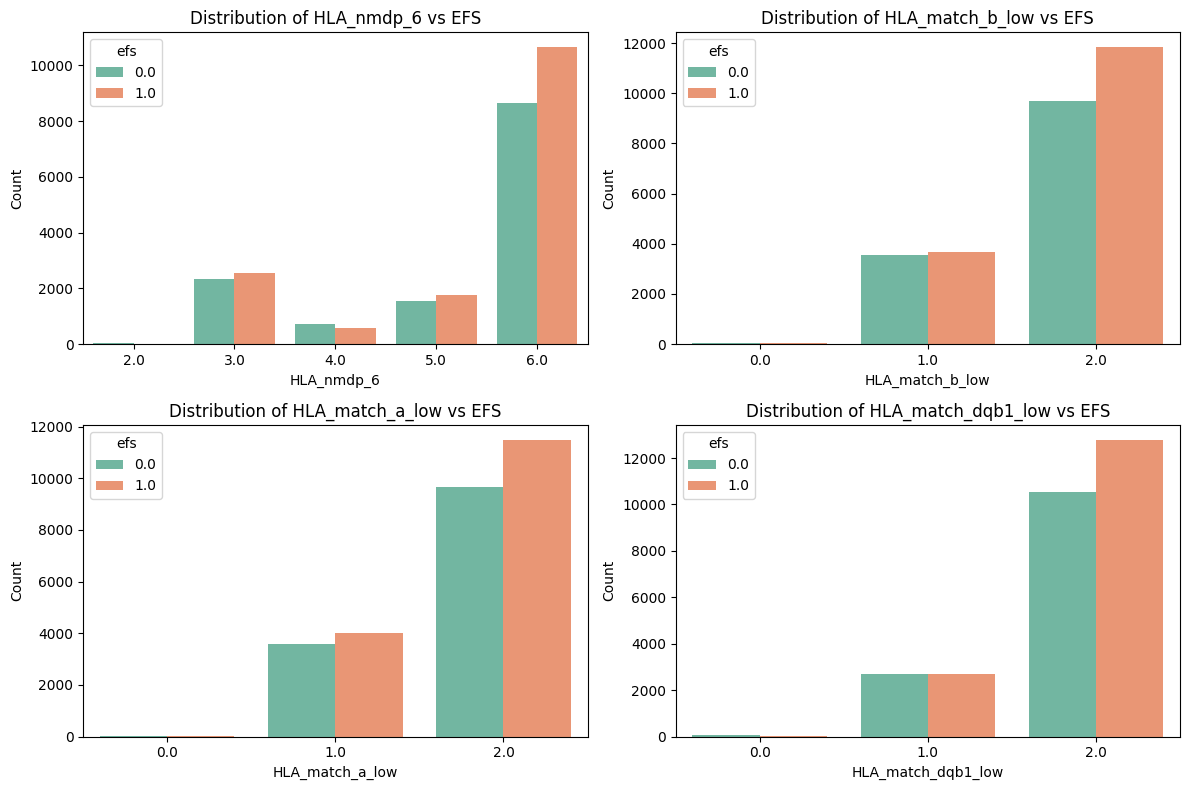

In [102]:

# Set the overall figure size
plt.figure(figsize=(12, 8))

# Plot 1: hla_nmdp_6 vs EFS
plt.subplot(2, 2, 1)

sns.countplot(x='hla_nmdp_6', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_nmdp_6 vs EFS")  # Add title for the plot
plt.xlabel("HLA_nmdp_6")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 2: hla_match_b_low vs EFS
plt.subplot(2, 2, 2)

sns.countplot(x='hla_match_b_low', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_match_b_low vs EFS")  # Add title for the plot
plt.xlabel("HLA_match_b_low")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 3: hla_match_a_low vs EFS
plt.subplot(2, 2, 3)

sns.countplot(x='hla_match_a_low', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_match_a_low vs EFS")  # Add title for the plot
plt.xlabel("HLA_match_a_low")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: hla_match_dqb1_low vs EFS
plt.subplot(2, 2, 4)

sns.countplot(x='hla_match_dqb1_low', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_match_dqb1_low vs EFS")  # Add title for the plot
plt.xlabel("HLA_match_dqb1_low")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()

In [103]:
# 12- Is there a relationship between the 'rituximab' column and 'prod_type' 
# and 'conditioning_intensity' and 'ethnicity ' the 'efs' or 'efs_time' columns?

# Test the function with 'rituximab' as the first variable and 'efs' as the second variable.
# This checks if there's a significant association between these two categorical variables.
chi2_contingency_test('rituximab', 'efs')

Title: rituximab
Chi2: 0.7091039276695599
P-value: 0.39974144676761836
Degrees of Freedom: 1
Expected Frequencies: [[12982.83013889 15198.16986111]
 [  285.16986111   333.83013889]]
Cramér's V: 0.004962022184069016


In [104]:
# Test the function with 'prod_type' as the first variable and 'efs' as the second variable.
chi2_contingency_test('prod_type' , 'efs')

Title: prod_type
Chi2: 1437.8636001376108
P-value: 0.0
Degrees of Freedom: 1
Expected Frequencies: [[ 3878.58652778  4540.41347222]
 [ 9389.41347222 10991.58652778]]
Cramér's V: 0.22344086342749078


In [105]:
# Test the function with 'conditioning_intensity' as the first variable and 'efs' as the second variable.
chi2_contingency_test('conditioning_intensity' , 'efs')

Title: conditioning_intensity
Chi2: 1094.6938920223417
P-value: 1.9509298818733797e-238
Degrees of Freedom: 2
Expected Frequencies: [[8107.76152778 9491.23847222]
 [1602.75597222 1876.24402778]
 [3557.4825     4164.5175    ]]
Cramér's V: 0.19496205934516872


In [106]:
# Test the function with 'ethnicity' as the first variable and 'efs' as the second variable.
chi2_contingency_test('ethnicity' , 'efs')

Title: ethnicity
Chi2: 53.84930792350081
P-value: 2.026615487632393e-12
Degrees of Freedom: 2
Expected Frequencies: [[ 1541.94430556  1805.05569444]
 [  176.90666667   207.09333333]
 [11549.14902778 13519.85097222]]
Cramér's V: 0.043240809847095454


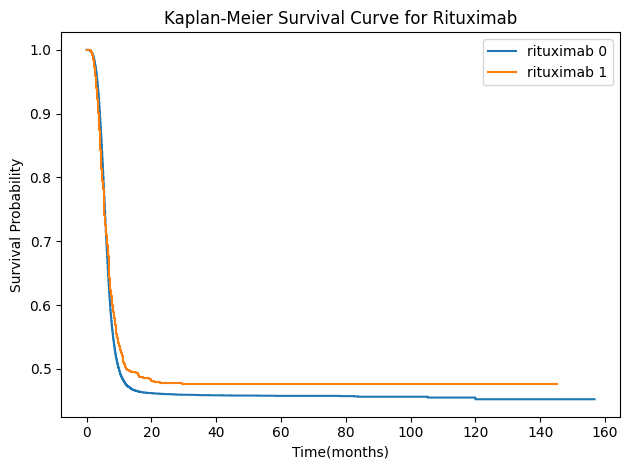

In [107]:
# Plot Kaplan-Meier curve for 'rituximab' column
plot_kaplan_meier('rituximab', 'Kaplan-Meier Survival Curve for Rituximab')

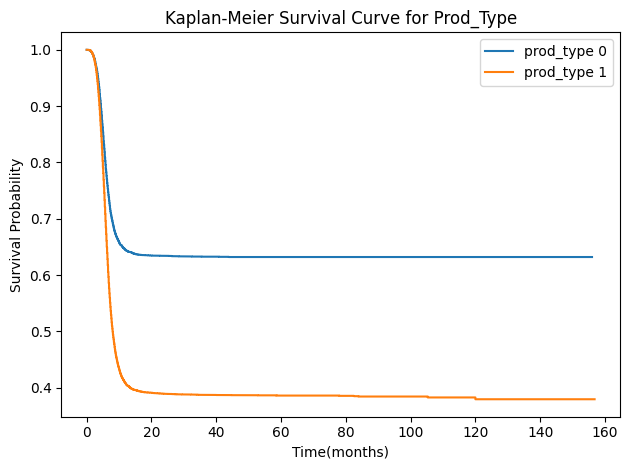

In [108]:
# Plot Kaplan-Meier curve for 'prod_type' column
plot_kaplan_meier('prod_type', 'Kaplan-Meier Survival Curve for Prod_Type')

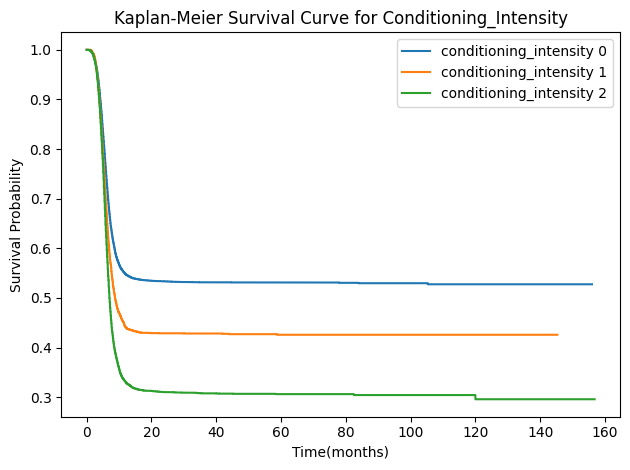

In [109]:
# plot Kaplan-Meier curve for 'conditioning_intensity' column
plot_kaplan_meier('conditioning_intensity' , 'Kaplan-Meier Survival Curve for Conditioning_Intensity')

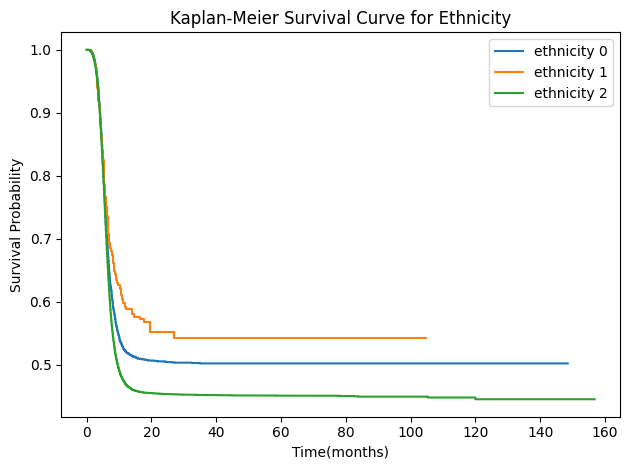

In [110]:

# plot Kaplan-Meier curve for 'hla_match_dqb1_low' column
plot_kaplan_meier('ethnicity' , 'Kaplan-Meier Survival Curve for Ethnicity')

In [111]:
# Logistic Regression Model using the Logit function ?
# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(rituximab) + C(prod_type) + C(conditioning_intensity) + C(ethnicity)' , data=data_train).fit()

# Print the Model Logistic results
print(model_logistic.summary()) 

Optimization terminated successfully.
         Current function value: 0.654127
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28793
Method:                           MLE   Df Model:                            6
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                 0.05206
Time:                        20:35:39   Log-Likelihood:                -18839.
converged:                       True   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.6839      0.040    -17.170     

In [112]:
# Regression Model using the OLS function ?
model_ols = ols(formula='efs_time ~ C(rituximab) + C(prod_type) + C(conditioning_intensity) + (ethnicity)' , data=data_train).fit()

# print the model OLS results
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     211.7
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          1.62e-222
Time:                        20:35:39   Log-Likelihood:            -1.3282e+05
No. Observations:               28800   AIC:                         2.656e+05
Df Residuals:                   28794   BIC:                         2.657e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

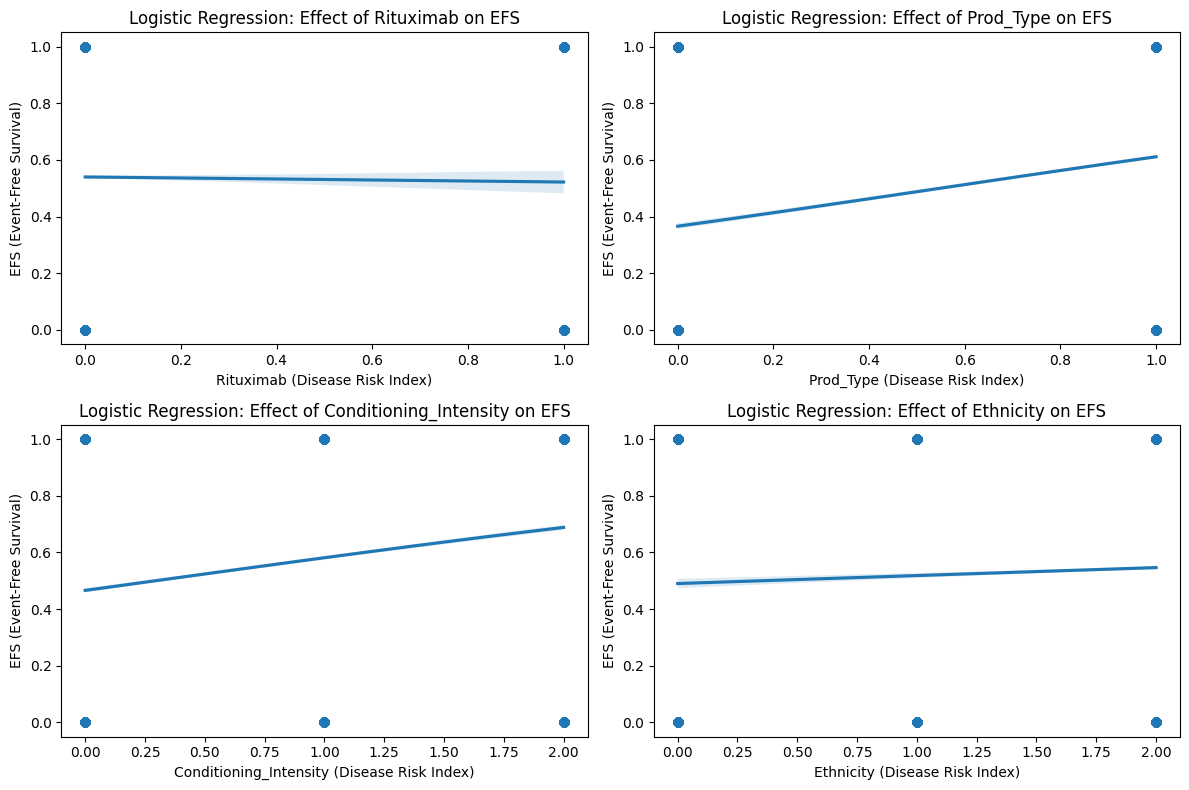

In [113]:

plt.figure(figsize=(12,8))

# First subplot: Logistic regression plot for 'rituximab' vs 'efs'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='rituximab' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Rituximab on EFS")  # Title of the plot
plt.xlabel("Rituximab (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Second subplot: Logistic regression plot for 'prod_type' vs 'efs'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='prod_type' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Prod_Type on EFS")  # Title of the plot
plt.xlabel("Prod_Type (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'conditioning_intensity' vs 'efs'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='conditioning_intensity' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Conditioning_Intensity on EFS")  # Title of the plot
plt.xlabel("Conditioning_Intensity (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'ethnicity' vs 'efs'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='ethnicity' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Ethnicity on EFS")  # Title of the plot
plt.xlabel("Ethnicity (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

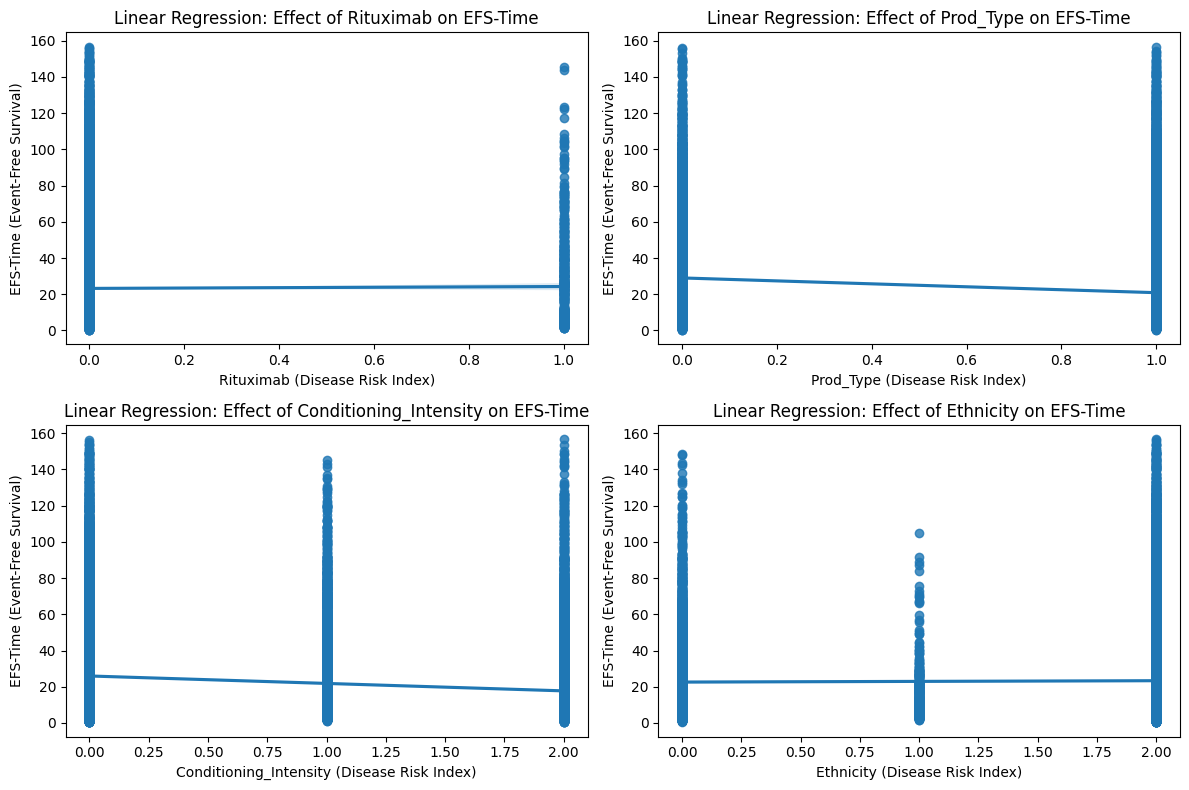

In [114]:
plt.figure(figsize=(12,8))

# First subplot: Linear regression plot for 'rituximab' vs 'efs_time'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='rituximab' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Rituximab on EFS-Time")  # Title of the plot
plt.xlabel("Rituximab (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Second subplot: Linear regression plot for 'prod_type' vs 'efs_time'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='prod_type' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Prod_Type on EFS-Time")  # Title of the plot
plt.xlabel("Prod_Type (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'conditioning_intensity' vs 'efs_time'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='conditioning_intensity' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Conditioning_Intensity on EFS-Time")  # Title of the plot
plt.xlabel("Conditioning_Intensity (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'ethnicity' vs 'efs_time'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='ethnicity' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Ethnicity on EFS-Time")  # Title of the plot
plt.xlabel("Ethnicity (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

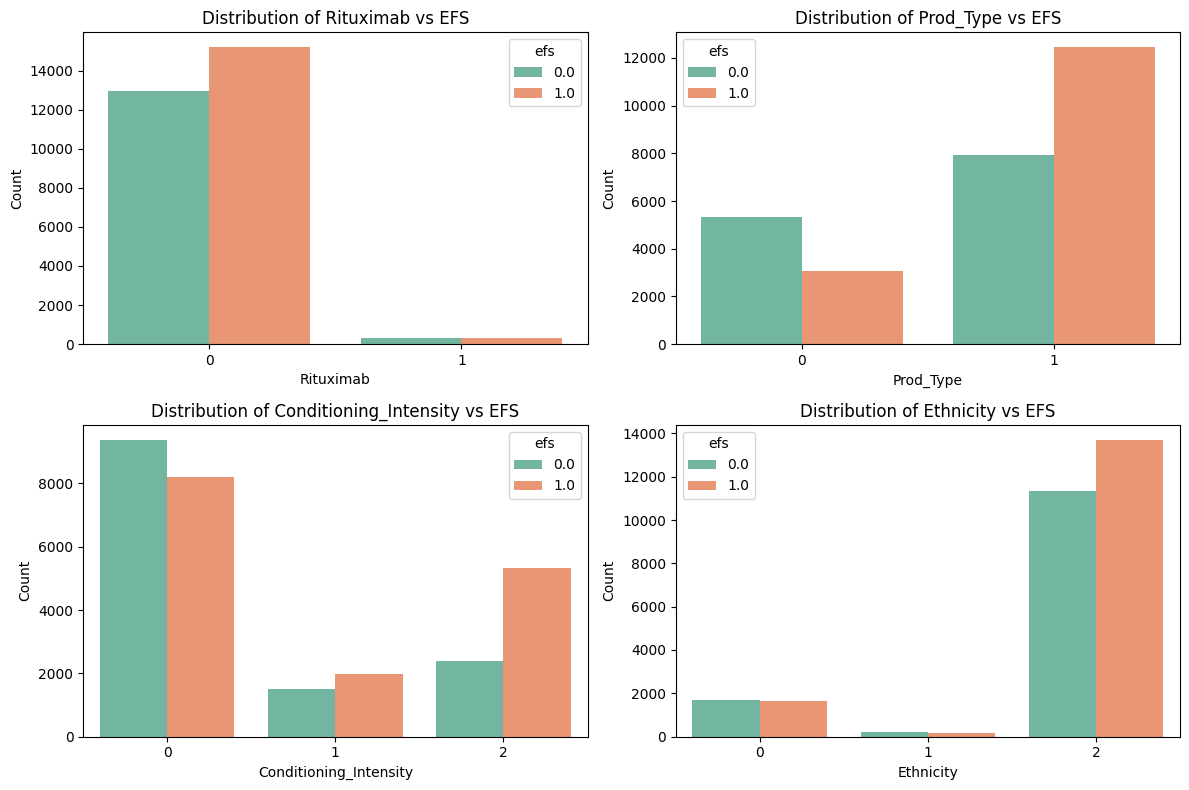

In [115]:
# Set the overall figure size
plt.figure(figsize=(12, 8))

# Plot 1: rituximab vs EFS
plt.subplot(2, 2, 1)

sns.countplot(x='rituximab', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Rituximab vs EFS")  # Add title for the plot
plt.xlabel("Rituximab")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 2: prod_type vs EFS
plt.subplot(2, 2, 2)

sns.countplot(x='prod_type', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Prod_Type vs EFS")  # Add title for the plot
plt.xlabel("Prod_Type")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 3: conditioning_intensity vs EFS
plt.subplot(2, 2, 3)

sns.countplot(x='conditioning_intensity', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Conditioning_Intensity vs EFS")  # Add title for the plot
plt.xlabel("Conditioning_Intensity")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: ethnicity vs EFS
plt.subplot(2, 2, 4)

sns.countplot(x='ethnicity', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Ethnicity vs EFS")  # Add title for the plot
plt.xlabel("Ethnicity")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()

In [116]:
# 14- Is there a relationship between the 'year_hct' column and 'obesity' and 
# 'mrd_hct' and 'in_vivo_tcd'  the 'efs' or 'efs_time' columns?

# Test the function with 'year_hct' as the first variable and 'efs' as the second variable.
# This checks if there's a significant association between these two categorical variables.
chi2_contingency_test('year_hct', 'efs')

Title: year_hct
Chi2: 592.1690943382763
P-value: 4.981769073006999e-119
Degrees of Freedom: 12
Expected Frequencies: [[1.17200667e+03 1.37199333e+03]
 [2.31729306e+02 2.71270694e+02]
 [1.74142500e+02 2.03857500e+02]
 [2.75955972e+02 3.23044028e+02]
 [7.23750972e+02 8.47249028e+02]
 [8.61959306e+02 1.00904069e+03]
 [5.05842500e+02 5.92157500e+02]
 [1.03333764e+03 1.20966236e+03]
 [2.32604625e+03 2.72295375e+03]
 [2.22515417e+03 2.60484583e+03]
 [3.37965444e+03 3.95634556e+03]
 [3.56577500e+02 4.17422500e+02]
 [1.84277778e+00 2.15722222e+00]]
Cramér's V: 0.1433925621737254


In [117]:
# Test the function with 'obesity' as the first variable and 'efs' as the second variable.
chi2_contingency_test('obesity' , 'efs')

Title: obesity
Chi2: 47.31415616642831
P-value: 6.047389640518537e-12
Degrees of Freedom: 1
Expected Frequencies: [[12448.42458333 14572.57541667]
 [  819.57541667   959.42458333]]
Cramér's V: 0.04053211867972916


In [118]:
# Test the function with 'mrd_hct' as the first variable and 'efs' as the second variable.
chi2_contingency_test('mrd_hct' , 'efs')

Title: mrd_hct
Chi2: 11.24567586024163
P-value: 0.0007980872708528377
Degrees of Freedom: 1
Expected Frequencies: [[11363.02847222 13301.97152778]
 [ 1904.97152778  2230.02847222]]
Cramér's V: 0.019760436641390034


In [119]:
# Test the function with 'in_vivo_tcd' as the first variable and 'efs' as the second variable.
chi2_contingency_test('in_vivo_tcd' , 'efs')

Title: in_vivo_tcd
Chi2: 756.6747806205956
P-value: 1.419294288285399e-166
Degrees of Freedom: 1
Expected Frequencies: [[8207.73222222 9608.26777778]
 [5060.26777778 5923.73222222]]
Cramér's V: 0.16209080752053637


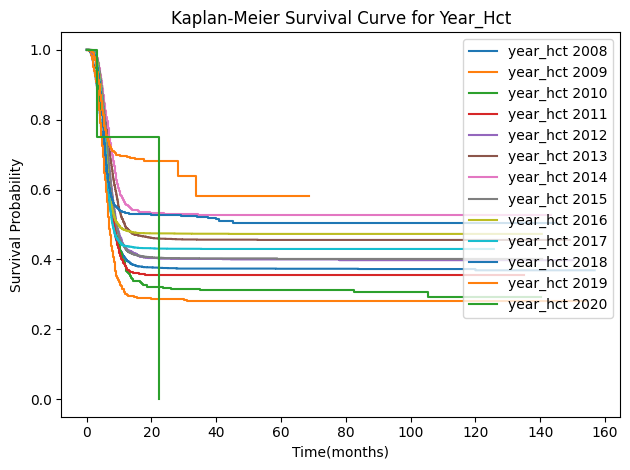

In [120]:
# Plot Kaplan-Meier curve for 'year_hct' column
plot_kaplan_meier('year_hct', 'Kaplan-Meier Survival Curve for Year_Hct')

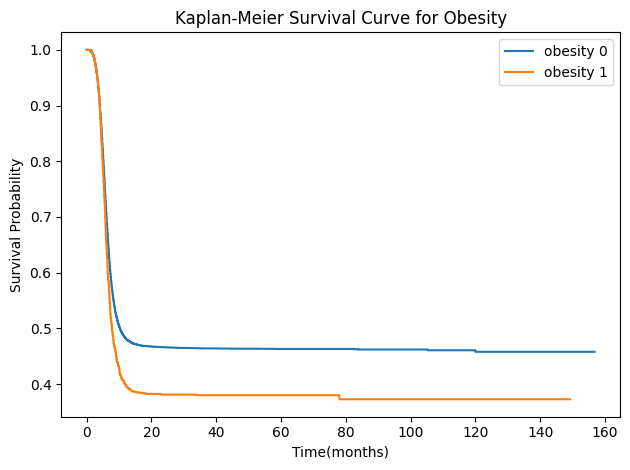

In [121]:
# Plot Kaplan-Meier curve for 'obesity' column
plot_kaplan_meier('obesity', 'Kaplan-Meier Survival Curve for Obesity')

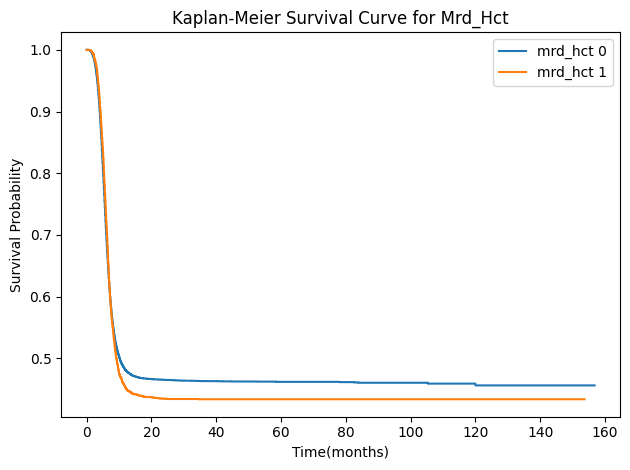

In [122]:
# plot Kaplan-Meier curve for 'mrd_hct' column
plot_kaplan_meier('mrd_hct' , 'Kaplan-Meier Survival Curve for Mrd_Hct')

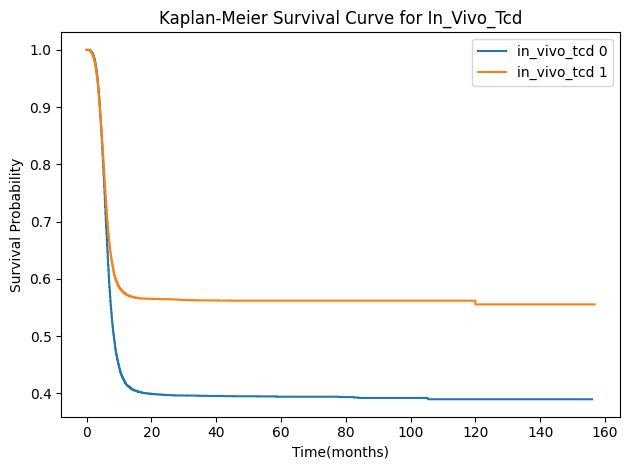

In [123]:
# plot Kaplan-Meier curve for 'in_vivo_tcd' column
plot_kaplan_meier('in_vivo_tcd' , 'Kaplan-Meier Survival Curve for In_Vivo_Tcd')

In [124]:
# Logistic Regression Model using the Logit function ?
# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(obesity) + C(mrd_hct) + C(year_hct) + C(in_vivo_tcd)' , data=data_train).fit()

# Print the Model Logistic results
print(model_logistic.summary()) 

Optimization terminated successfully.
         Current function value: 0.664756
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28784
Method:                           MLE   Df Model:                           15
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                 0.03666
Time:                        20:37:17   Log-Likelihood:                -19145.
converged:                       True   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                8.198e-302
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8419      0.044     19.233      0.000       0.756       0.928
C(

In [125]:
# Regression Model using the OLS function ?
model_ols = ols(formula='efs_time ~ C(obesity) + C(mrd_hct) + C(year_hct) + (in_vivo_tcd)' , data=data_train).fit()

# print the model OLS results
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     197.9
Date:                Wed, 05 Mar 2025   Prob (F-statistic):               0.00
Time:                        20:37:18   Log-Likelihood:            -1.3192e+05
No. Observations:               28800   AIC:                         2.639e+05
Df Residuals:                   28784   BIC:                         2.640e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              32.5481    

In [126]:
# 15- Why do the years 2015 to 2019 see a decrease in efs_time compared to other years?

# Function to compare the distribution of data between two columns
def compare_distribution(column1, column2):
    # Returns the distribution of data between two columns as a pivot table.
    disease_distribution = data_train.groupby([column1, column2]).size().unstack(fill_value=0)
    return disease_distribution

In [127]:
# Comparing the distribution of data between 'year_hct' and 'prim_disease_hct' columns
column_prim_disease_hct = compare_distribution('year_hct', 'prim_disease_hct')

# Comparing the distribution of data between 'year_hct' and 'conditioning_intensity' columns
column_conditioning_intensity = compare_distribution('year_hct', 'conditioning_intensity')

# Comparing the distribution of data between 'year_hct' and 'tbi_status' columns
column_tbi_status = compare_distribution('year_hct', 'tbi_status')

# Comparing the distribution of data between 'year_hct' and 'rituximab' columns
column_rituximab = compare_distribution('year_hct', 'rituximab')

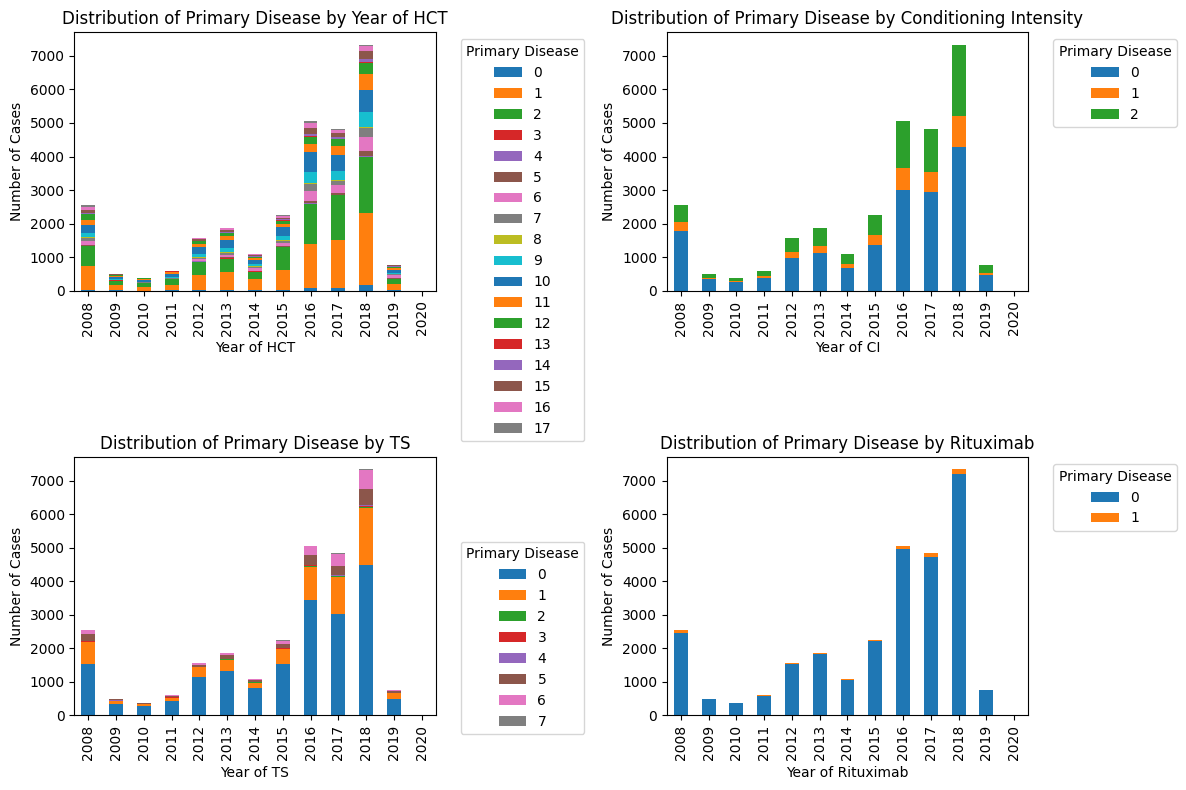

In [128]:

# Create a figure and axes for 2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 1 row, 2 columns

# Plot the first graph on the first axis
column_prim_disease_hct.plot(kind='bar', stacked=True, ax=axes[0,0])

# Set the title and labels for the first subplot
axes[0,0].set_title('Distribution of Primary Disease by Year of HCT')
axes[0,0].set_xlabel('Year of HCT')
axes[0,0].set_ylabel('Number of Cases')
axes[0,0].legend(title='Primary Disease', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot the second graph on the second axis
column_conditioning_intensity.plot(kind='bar', stacked=True, ax=axes[0,1])

# Set the title and labels for the second subplot
axes[0,1].set_title('Distribution of Primary Disease by Conditioning Intensity')
axes[0,1].set_xlabel('Year of CI')
axes[0,1].set_ylabel('Number of Cases')
axes[0,1].legend(title='Primary Disease', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot the second graph on the second axis
column_tbi_status.plot(kind='bar' , stacked=True , ax=axes[1,0])

# Set the title and labels for the second subplot
axes[1,0].set_title('Distribution of Primary Disease by TS')
axes[1,0].set_xlabel('Year of TS')
axes[1,0].set_ylabel('Number of Cases')
axes[1,0].legend(title='Primary Disease', bbox_to_anchor=(1.05, 0.70), loc='upper left')

# Plot the second graph on the second axis
column_rituximab.plot(kind='bar' , stacked=True , ax=axes[1,1])

# Set the title and labels for the second subplot
axes[1,1].set_title('Distribution of Primary Disease by Rituximab')
axes[1,1].set_xlabel('Year of Rituximab')
axes[1,1].set_ylabel('Number of Cases')
axes[1,1].legend(title='Primary Disease', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout to prevent overlap
plt.tight_layout()
# Show the plot
plt.show()

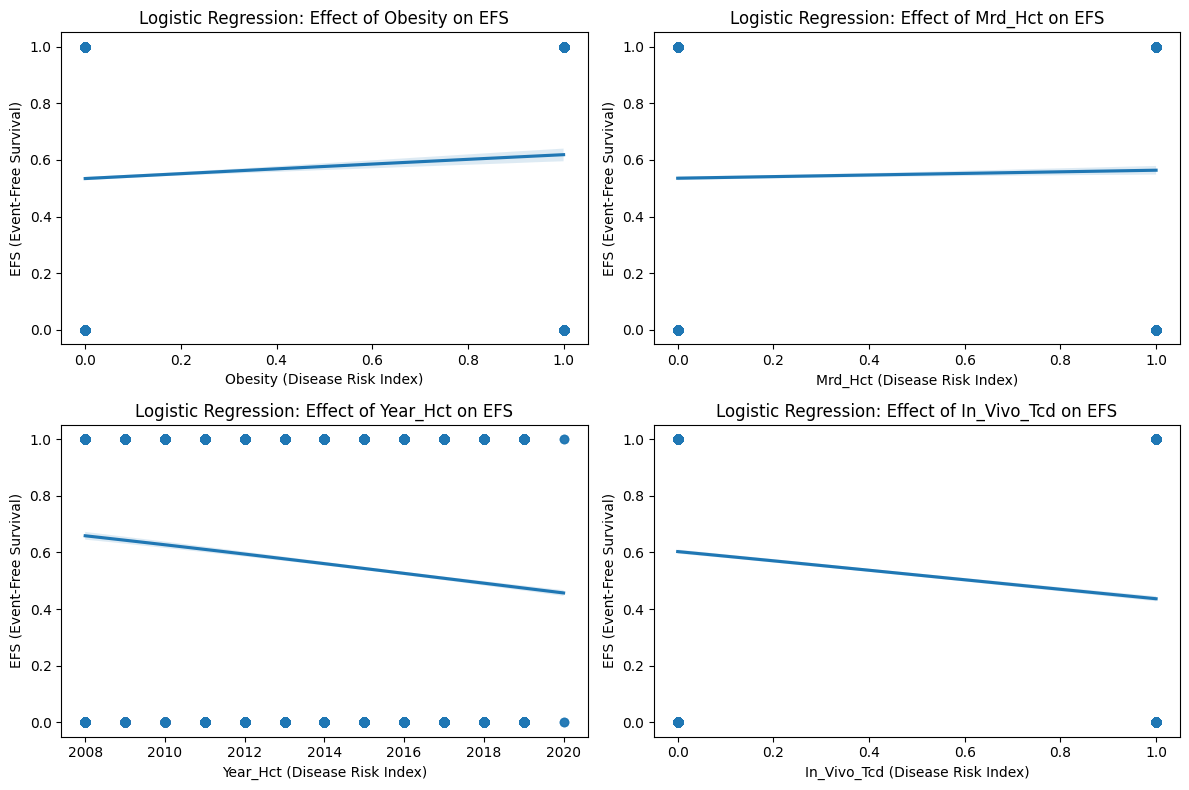

In [129]:
plt.figure(figsize=(12,8))

# First subplot: Logistic regression plot for 'obesity' vs 'efs'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='obesity' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Obesity on EFS")  # Title of the plot
plt.xlabel("Obesity (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Second subplot: Logistic regression plot for 'mrd_hct' vs 'efs'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='mrd_hct' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Mrd_Hct on EFS")  # Title of the plot
plt.xlabel("Mrd_Hct (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'year_hct' vs 'efs'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='year_hct' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Year_Hct on EFS")  # Title of the plot
plt.xlabel("Year_Hct (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'in_vivo_tcd' vs 'efs'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='in_vivo_tcd' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of In_Vivo_Tcd on EFS")  # Title of the plot
plt.xlabel("In_Vivo_Tcd (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()


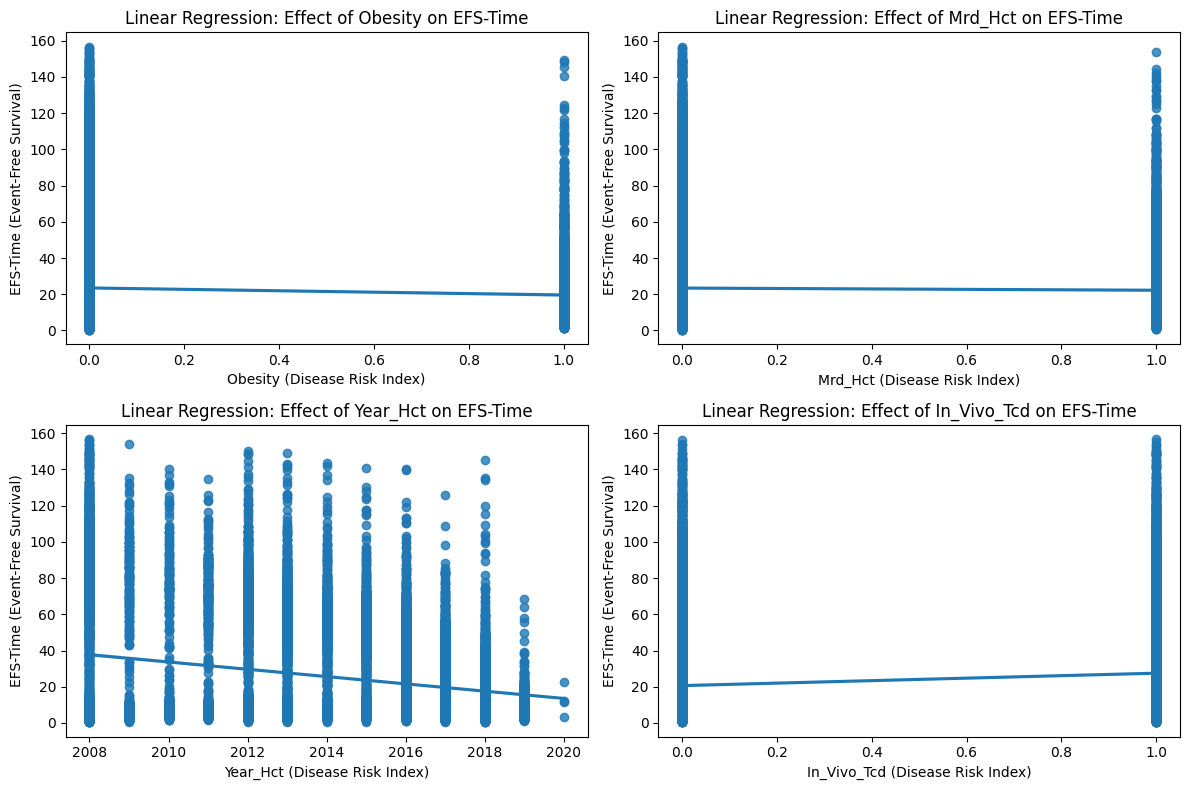

In [130]:
plt.figure(figsize=(12,8))

# First subplot: Linear regression plot for 'obesity' vs 'efs_time'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='obesity' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Obesity on EFS-Time")  # Title of the plot
plt.xlabel("Obesity (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Second subplot: Linear regression plot for 'mrd_hct' vs 'efs_time'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='mrd_hct' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Mrd_Hct on EFS-Time")  # Title of the plot
plt.xlabel("Mrd_Hct (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'year_hct' vs 'efs_time'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='year_hct' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Year_Hct on EFS-Time")  # Title of the plot
plt.xlabel("Year_Hct (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'in_vivo_tcd' vs 'efs_time'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='in_vivo_tcd' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of In_Vivo_Tcd on EFS-Time")  # Title of the plot
plt.xlabel("In_Vivo_Tcd (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

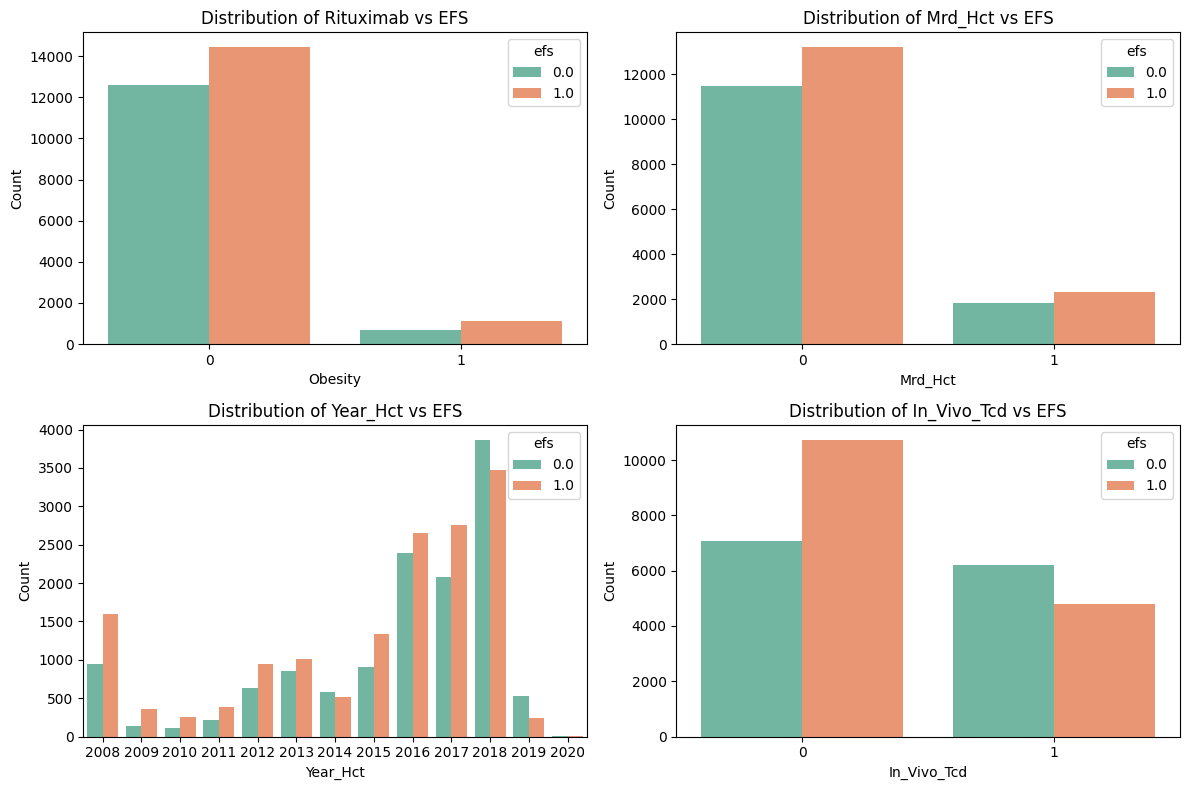

In [131]:
# Set the overall figure size
plt.figure(figsize=(12, 8))

# Plot 1: obesity vs EFS
plt.subplot(2, 2, 1)

sns.countplot(x='obesity', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Rituximab vs EFS")  # Add title for the plot
plt.xlabel("Obesity")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 2: mrd_hct vs EFS
plt.subplot(2, 2, 2)

sns.countplot(x='mrd_hct', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Mrd_Hct vs EFS")  # Add title for the plot
plt.xlabel("Mrd_Hct")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 3: year_hct vs EFS
plt.subplot(2, 2, 3)

sns.countplot(x='year_hct', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Year_Hct vs EFS")  # Add title for the plot
plt.xlabel("Year_Hct")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: in_vivo_tcd vs EFS
plt.subplot(2, 2, 4)

sns.countplot(x='in_vivo_tcd', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of In_Vivo_Tcd vs EFS")  # Add title for the plot
plt.xlabel("In_Vivo_Tcd")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()

In [132]:
# 16- Is there a relationship between the 'cyto_score_detail' column and 'tce_match'
# and 'hepatic_severe' and 'prior_tumor'  the 'efs' or 'efs_time' columns?


# Logistic Regression Model using the Logit function ?
# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(cyto_score_detail) + C(tce_match) + C(hepatic_severe) + C(prior_tumor)' , data=data_train).fit()

# Print the Model Logistic results
print(model_logistic.summary()) 

Optimization terminated successfully.
         Current function value: 0.673272
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28792
Method:                           MLE   Df Model:                            7
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                 0.02432
Time:                        20:38:57   Log-Likelihood:                -19390.
converged:                       True   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                1.923e-204
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.4318      0.086      5.009      0.000       0.

In [133]:
# Regression Model using the OLS function ?
model_ols = ols(formula='efs_time ~ C(cyto_score_detail) + C(tce_match) + C(hepatic_severe) + (prior_tumor)' , data=data_train).fit()

# print the model OLS results
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     75.07
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          2.69e-108
Time:                        20:38:58   Log-Likelihood:            -1.3308e+05
No. Observations:               28800   AIC:                         2.662e+05
Df Residuals:                   28792   BIC:                         2.662e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

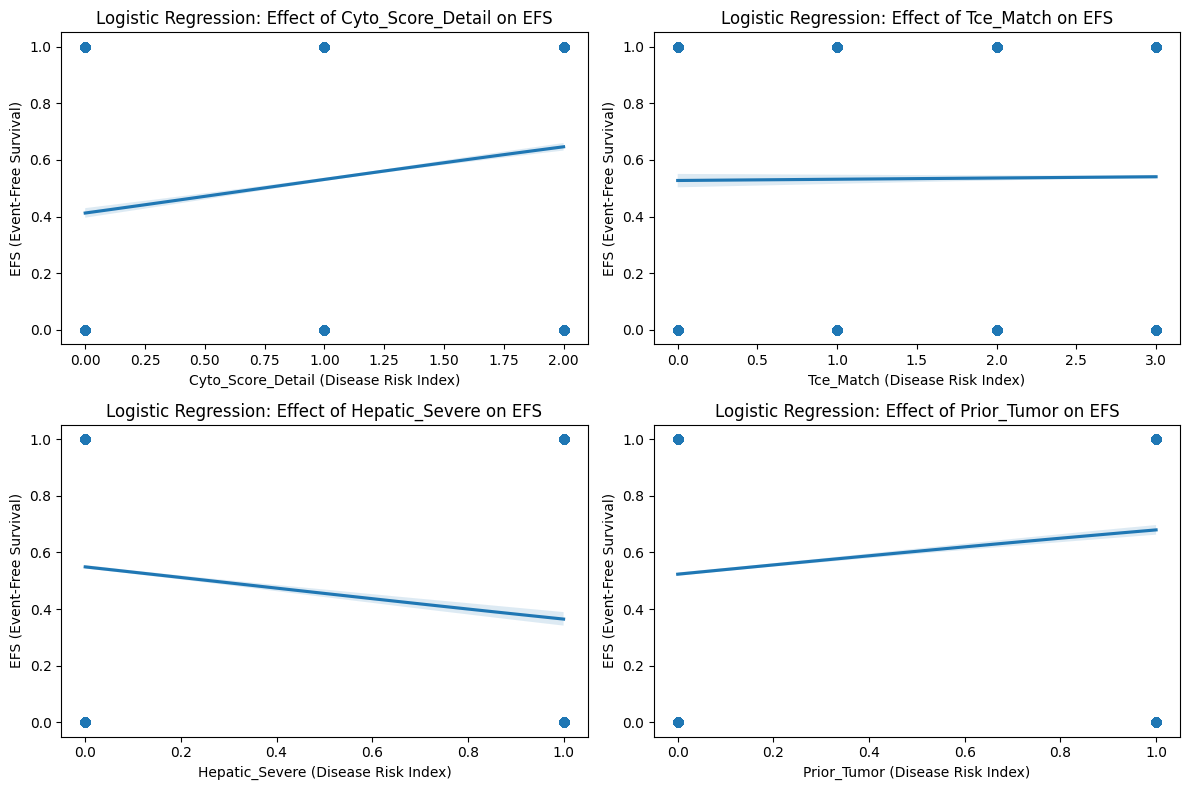

In [134]:
plt.figure(figsize=(12,8))

# First subplot: Logistic regression plot for 'cyto_score_detail' vs 'efs'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='cyto_score_detail' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Cyto_Score_Detail on EFS")  # Title of the plot
plt.xlabel("Cyto_Score_Detail (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Second subplot: Logistic regression plot for 'tce_match' vs 'efs'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='tce_match' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Tce_Match on EFS")  # Title of the plot
plt.xlabel("Tce_Match (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'hepatic_severe' vs 'efs'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='hepatic_severe' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Hepatic_Severe on EFS")  # Title of the plot
plt.xlabel("Hepatic_Severe (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'prior_tumor' vs 'efs'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='prior_tumor' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Prior_Tumor on EFS")  # Title of the plot
plt.xlabel("Prior_Tumor (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

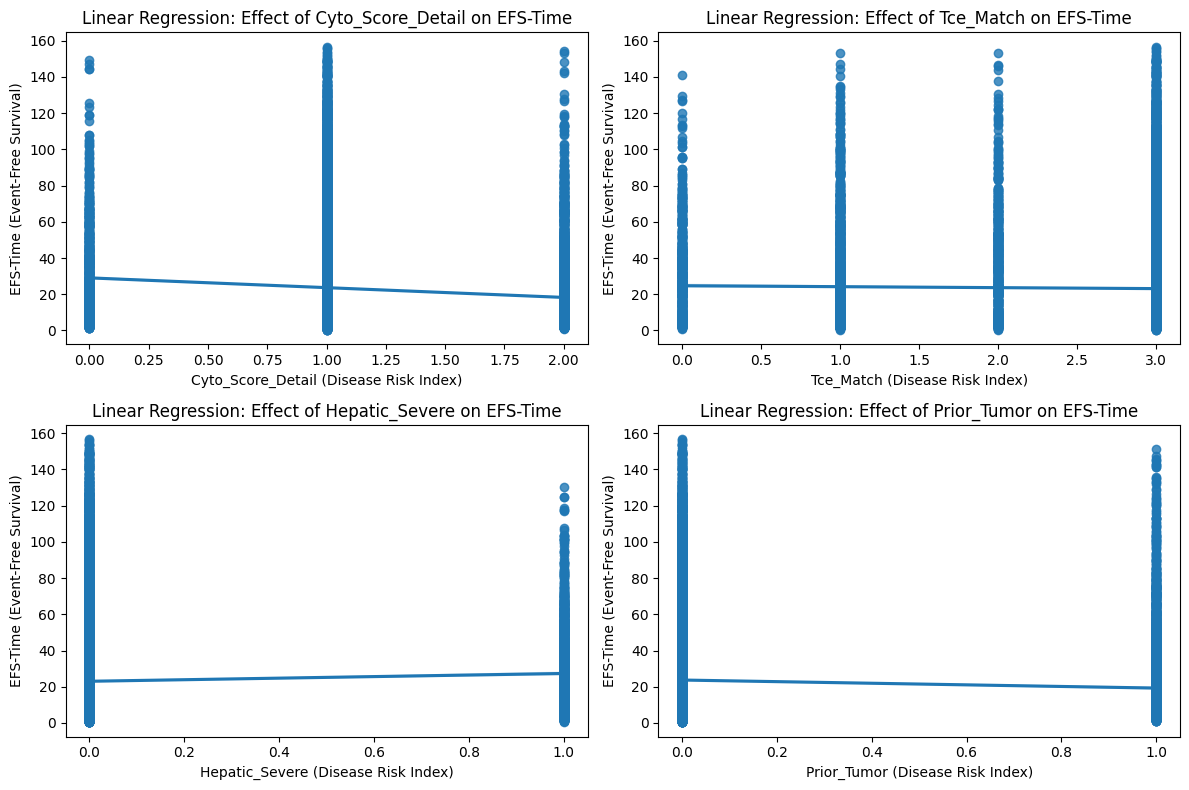

In [135]:
plt.figure(figsize=(12,8))

# First subplot: Linear regression plot for 'cyto_score_detail' vs 'efs_time'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='cyto_score_detail' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Cyto_Score_Detail on EFS-Time")  # Title of the plot
plt.xlabel("Cyto_Score_Detail (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Second subplot: Linear regression plot for 'tce_match' vs 'efs_time'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='tce_match' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Tce_Match on EFS-Time")  # Title of the plot
plt.xlabel("Tce_Match (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'hepatic_severe' vs 'efs_time'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='hepatic_severe' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Hepatic_Severe on EFS-Time")  # Title of the plot
plt.xlabel("Hepatic_Severe (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'prior_tumor' vs 'efs_time'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='prior_tumor' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Prior_Tumor on EFS-Time")  # Title of the plot
plt.xlabel("Prior_Tumor (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()


In [136]:
# Test the function with 'cyto_score_detail' as the first variable and 'efs' as the second variable.
# This checks if there's a significant association between these two categorical variables.
chi2_contingency_test('cyto_score_detail', 'efs')

Title: cyto_score_detail
Chi2: 582.0589077511411
P-value: 4.050551054382715e-127
Degrees of Freedom: 2
Expected Frequencies: [[  556.51888889   651.48111111]
 [11180.59347222 13088.40652778]
 [ 1530.88763889  1792.11236111]]
Cramér's V: 0.142163211631417


In [137]:
# Test the function with 'tce_match' as the first variable and 'efs' as the second variable.
chi2_contingency_test('tce_match' , 'efs')

Title: tce_match
Chi2: 6.294587942765598
P-value: 0.09812514550903373
Degrees of Freedom: 3
Expected Frequencies: [[  487.87541667   571.12458333]
 [  739.41458333   865.58541667]
 [  399.88277778   468.11722222]
 [11640.82722222 13627.17277778]]
Cramér's V: 0.01478384528280879


In [138]:
# Test the function with 'hepatic_severe' as the first variable and 'efs' as the second variable.
chi2_contingency_test('hepatic_severe' , 'efs')

Title: hepatic_severe
Chi2: 191.01875780404504
P-value: 1.9052908029780444e-43
Degrees of Freedom: 1
Expected Frequencies: [[12585.71152778 14733.28847222]
 [  682.28847222   798.71152778]]
Cramér's V: 0.08144074997864949


In [139]:
# Test the function with 'prior_tumor' as the first variable and 'efs' as the second variable.
chi2_contingency_test('prior_tumor' , 'efs')

Title: prior_tumor
Chi2: 264.3993297124865
P-value: 1.8862428593670024e-59
Degrees of Freedom: 1
Expected Frequencies: [[11881.77041667 13909.22958333]
 [ 1386.22958333  1622.77041667]]
Cramér's V: 0.09581509422676346


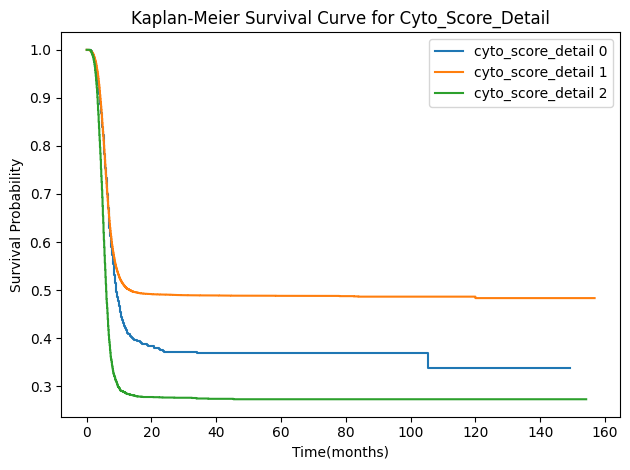

In [140]:
# Plot Kaplan-Meier curve for 'cyto_score_detail' column
plot_kaplan_meier('cyto_score_detail', 'Kaplan-Meier Survival Curve for Cyto_Score_Detail')


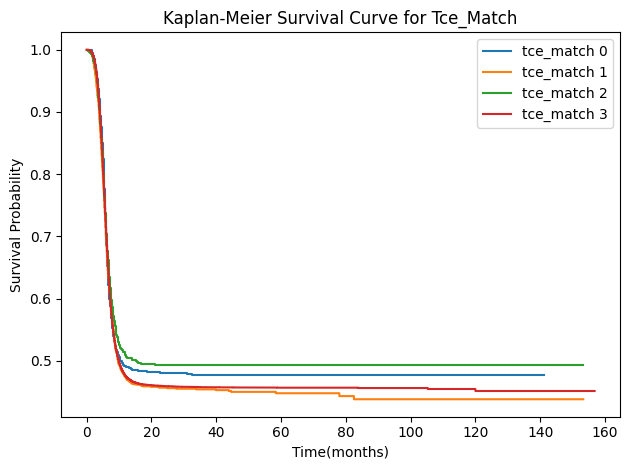

In [141]:
# Plot Kaplan-Meier curve for 'tce_match' column
plot_kaplan_meier('tce_match', 'Kaplan-Meier Survival Curve for Tce_Match')

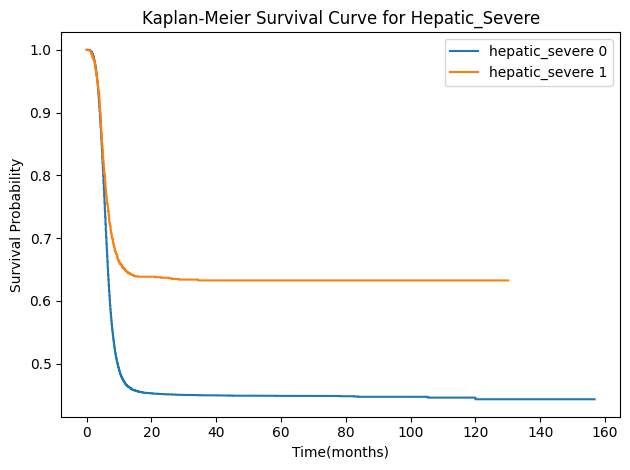

In [142]:
# plot Kaplan-Meier curve for 'hepatic_severe' column
plot_kaplan_meier('hepatic_severe' , 'Kaplan-Meier Survival Curve for Hepatic_Severe')

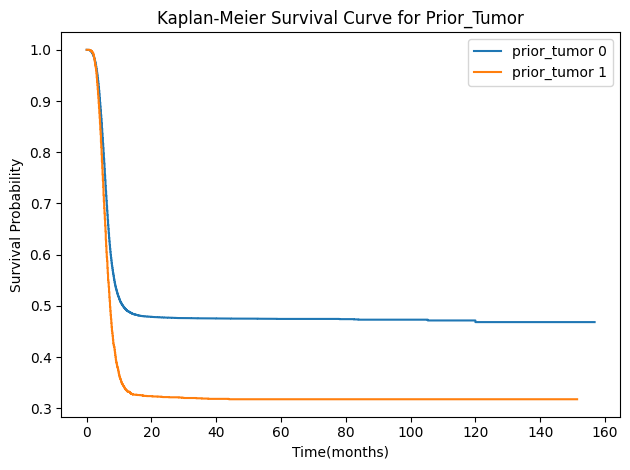

In [143]:
# plot Kaplan-Meier curve for 'prior_tumor' column
plot_kaplan_meier('prior_tumor' , 'Kaplan-Meier Survival Curve for Prior_Tumor')

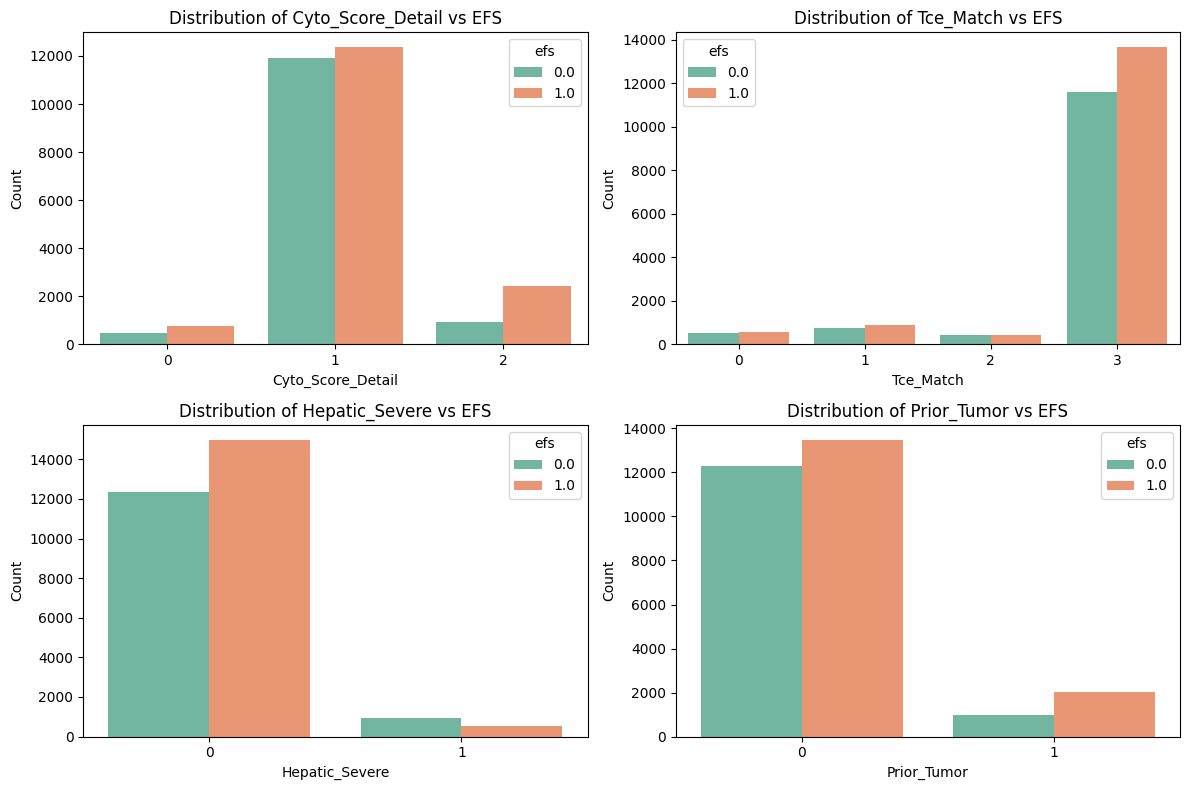

In [144]:
# Set the overall figure size
plt.figure(figsize=(12, 8))

# Plot 1: cyto_score_detail vs EFS
plt.subplot(2, 2, 1)

sns.countplot(x='cyto_score_detail', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Cyto_Score_Detail vs EFS")  # Add title for the plot
plt.xlabel("Cyto_Score_Detail")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 2: tce_match vs EFS
plt.subplot(2, 2, 2)

sns.countplot(x='tce_match', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Tce_Match vs EFS")  # Add title for the plot
plt.xlabel("Tce_Match")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 3: hepatic_severe vs EFS
plt.subplot(2, 2, 3)

sns.countplot(x='hepatic_severe', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Hepatic_Severe vs EFS")  # Add title for the plot
plt.xlabel("Hepatic_Severe")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: prior_tumor vs EFS
plt.subplot(2, 2, 4)

sns.countplot(x='prior_tumor', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Prior_Tumor vs EFS")  # Add title for the plot
plt.xlabel("Prior_Tumor")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()

In [145]:
#17- Is there a relationship between the 'donor_age' column and 'age_at_hct' and 'peptic_ulcer' 
# and 'gvhd_proph'  the 'efs' or 'efs_time' columns?

# Logistic Regression Model using the Logit function ?
# Build a logistic regression model
model_logistic = logit(formula='efs ~ + C(peptic_ulcer) + C(gvhd_proph)' , data=data_train).fit()

# Print the Model Logistic results
print(model_logistic.summary()) 

         Current function value: 0.674870
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28782
Method:                           MLE   Df Model:                           17
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                 0.02200
Time:                        20:40:38   Log-Likelihood:                -19436.
converged:                      False   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                5.631e-175
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.6391      0.284     -2.254      0.024      -1.195      -0.083
C(peptic_ulcer)[T.1]    -0.3314    

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [146]:
# Regression Model using the OLS function ?
model_ols = ols(formula='efs_time ~ C(peptic_ulcer) + (gvhd_proph)' , data=data_train).fit()

# print the model OLS results
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.714
Date:                Wed, 05 Mar 2025   Prob (F-statistic):              0.180
Time:                        20:40:39   Log-Likelihood:            -1.3334e+05
No. Observations:               28800   AIC:                         2.667e+05
Df Residuals:                   28797   BIC:                         2.667e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               23.0462 

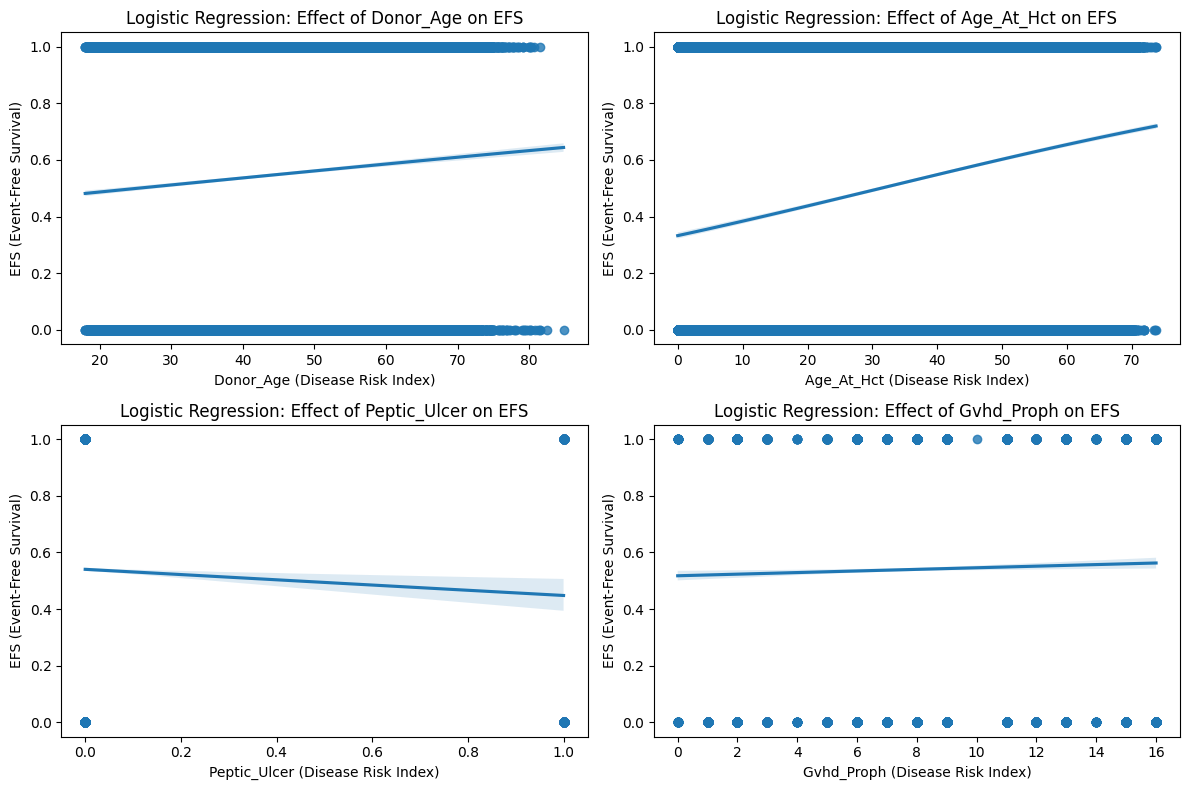

In [147]:
plt.figure(figsize=(12,8))

# First subplot: Logistic regression plot for 'donor_age' vs 'efs'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='donor_age' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Donor_Age on EFS")  # Title of the plot
plt.xlabel("Donor_Age (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Second subplot: Logistic regression plot for 'age_at_hct' vs 'efs'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='age_at_hct' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Age_At_Hct on EFS")  # Title of the plot
plt.xlabel("Age_At_Hct (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'peptic_ulcer' vs 'efs'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='peptic_ulcer' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Peptic_Ulcer on EFS")  # Title of the plot
plt.xlabel("Peptic_Ulcer (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'gvhd_proph' vs 'efs'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='gvhd_proph' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Gvhd_Proph on EFS")  # Title of the plot
plt.xlabel("Gvhd_Proph (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

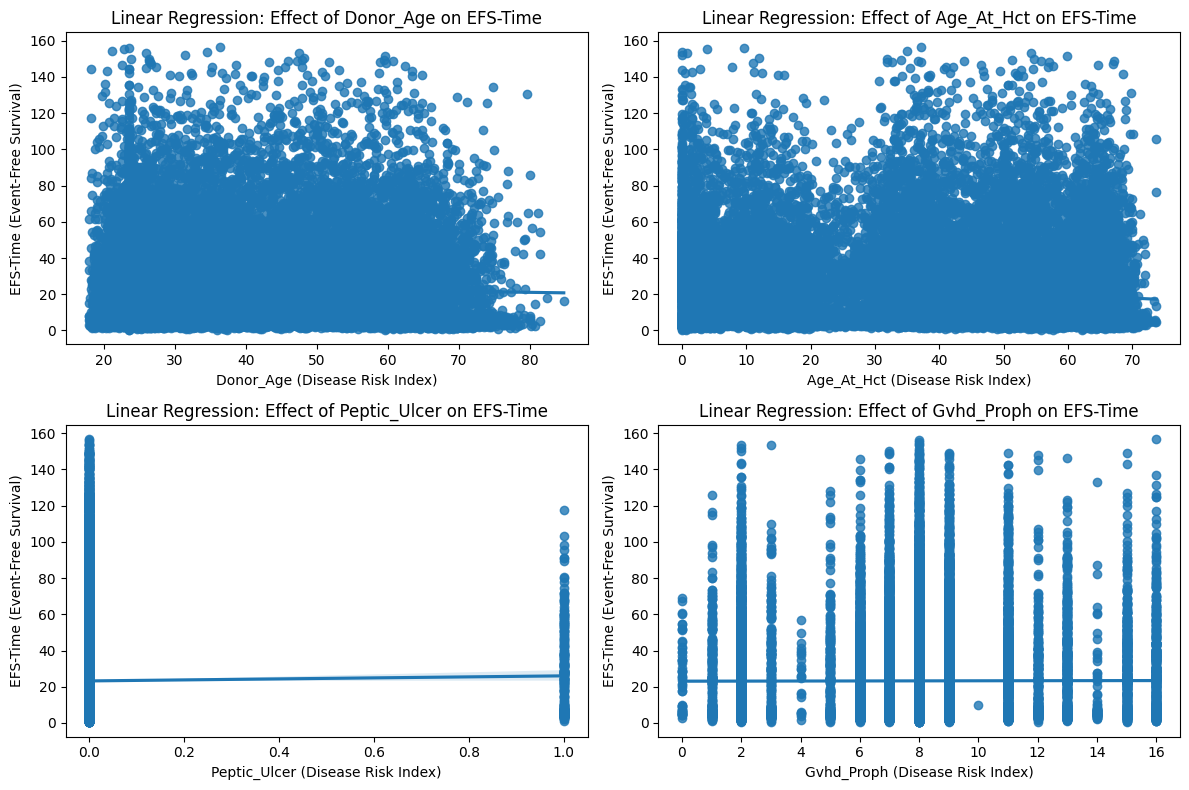

In [148]:
plt.figure(figsize=(12,8))

# First subplot: Linear regression plot for 'donor_age' vs 'efs_time'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='donor_age' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Donor_Age on EFS-Time")  # Title of the plot
plt.xlabel("Donor_Age (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Second subplot: Linear regression plot for 'age_at_hct' vs 'efs_time'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='age_at_hct' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Age_At_Hct on EFS-Time")  # Title of the plot
plt.xlabel("Age_At_Hct (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'peptic_ulcer' vs 'efs_time'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='peptic_ulcer' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Peptic_Ulcer on EFS-Time")  # Title of the plot
plt.xlabel("Peptic_Ulcer (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'gvhd_proph' vs 'efs_time'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='gvhd_proph' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Gvhd_Proph on EFS-Time")  # Title of the plot
plt.xlabel("Gvhd_Proph (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

In [149]:
# Test the function with 'peptic_ulcer' as the first variable and 'efs' as the second variable.
chi2_contingency_test('peptic_ulcer' , 'efs')

Title: peptic_ulcer
Chi2: 8.425733848230701
P-value: 0.003699473056594174
Degrees of Freedom: 1
Expected Frequencies: [[13148.68013889 15392.31986111]
 [  119.31986111   139.68013889]]
Cramér's V: 0.017104391338588053


In [150]:
# Test the function with 'gvhd_proph' as the first variable and 'efs' as the second variable.
chi2_contingency_test('gvhd_proph' , 'efs')

Title: gvhd_proph
Chi2: 862.8115498565986
P-value: 2.4644017249526e-173
Degrees of Freedom: 16
Expected Frequencies: [[2.53381944e+01 2.96618056e+01]
 [1.15634306e+02 1.35365694e+02]
 [1.04946194e+03 1.22853806e+03]
 [1.03195556e+02 1.20804444e+02]
 [1.05959722e+01 1.24040278e+01]
 [9.85886111e+01 1.15411389e+02]
 [1.09138514e+03 1.27761486e+03]
 [2.42785972e+03 2.84214028e+03]
 [4.91330625e+03 5.75169375e+03]
 [1.96347972e+03 2.29852028e+03]
 [4.60694444e-01 5.39305556e-01]
 [5.66654167e+02 6.63345833e+02]
 [1.20701944e+02 1.41298056e+02]
 [2.53381944e+02 2.96618056e+02]
 [2.85630556e+01 3.34369444e+01]
 [2.48314306e+02 2.90685694e+02]
 [2.51078472e+02 2.93921528e+02]]
Cramér's V: 0.17308591615154822


In [151]:
# Create a copy of the data to avoid modifying the original dataset
my_data = data_train.copy()
# Define a function to categorize a numerical column into age groups based on bins
def categorize_age_group(bins , labels , column_name):
    # Use pd.cut to discretize the continuous values into specified age groups
    my_data[column_name] = pd.cut(my_data[column_name] , bins=bins, labels=labels)
    return my_data

In [152]:
# Define the bins (ranges) for the age groups
bins = [0,10,20,30,40,50,60,70] # The start and end points of the age ranges
# Define the labels for each age group
labels = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70'] # Corresponding labels for the bins

# Apply the function to categorize the 'age_at_hct' column into age groups
column_age_at_hct = categorize_age_group(bins , labels , 'age_at_hct')

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


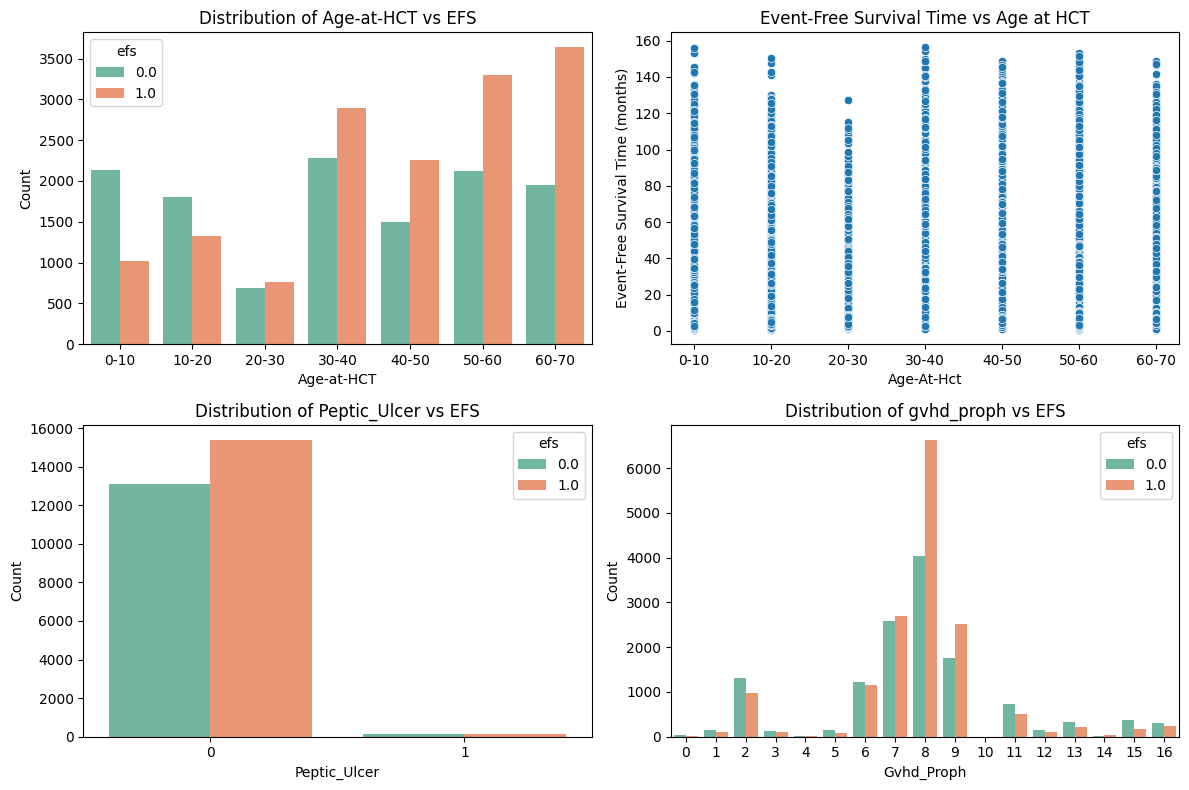

In [153]:

# Set the overall figure size
plt.figure(figsize=(12, 8))

# plot 1: donogr-age
plt.subplot(2,2,1)
# countplot
sns.countplot(x='age_at_hct', hue='efs',data=my_data, palette='Set2')  # Create a count plot
plt.title("Distribution of Age-at-HCT vs EFS")  # Add title for the plot
plt.xlabel("Age-at-HCT")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis


# Plot 2: age_at_hct vs EFS
plt.subplot(2, 2, 2)

sns.scatterplot(x='age_at_hct', y='efs_time', data=my_data)  # Create a count plot
plt.title("Event-Free Survival Time vs Age at HCT")  # Add title for the plot
plt.xlabel("Age-At-Hct")  # Label for the x-axis
plt.ylabel("Event-Free Survival Time (months)")  # Label for the y-axis

# Plot 3: peptic_ulcer vs EFS
plt.subplot(2, 2, 3)

sns.countplot(x='peptic_ulcer', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Peptic_Ulcer vs EFS")  # Add title for the plot
plt.xlabel("Peptic_Ulcer")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: gvhd_proph vs EFS
plt.subplot(2, 2, 4)

sns.countplot(x='gvhd_proph', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of gvhd_proph vs EFS")  # Add title for the plot
plt.xlabel("Gvhd_Proph")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()

In [154]:
# Define age bins and corresponding labels
bins = [18, 30, 40, 50, 60, 70, 85]  # Represents age ranges as boundaries for grouping
labels = ["18-30", "30-40", "40-50", "50-60", "60-70", "70-85"]  # Labels for each age group

# Further categorize or process the 'donor_age' column using the categorize_age_group function
column_donor_age = categorize_age_group(bins, labels, 'donor_age')


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_

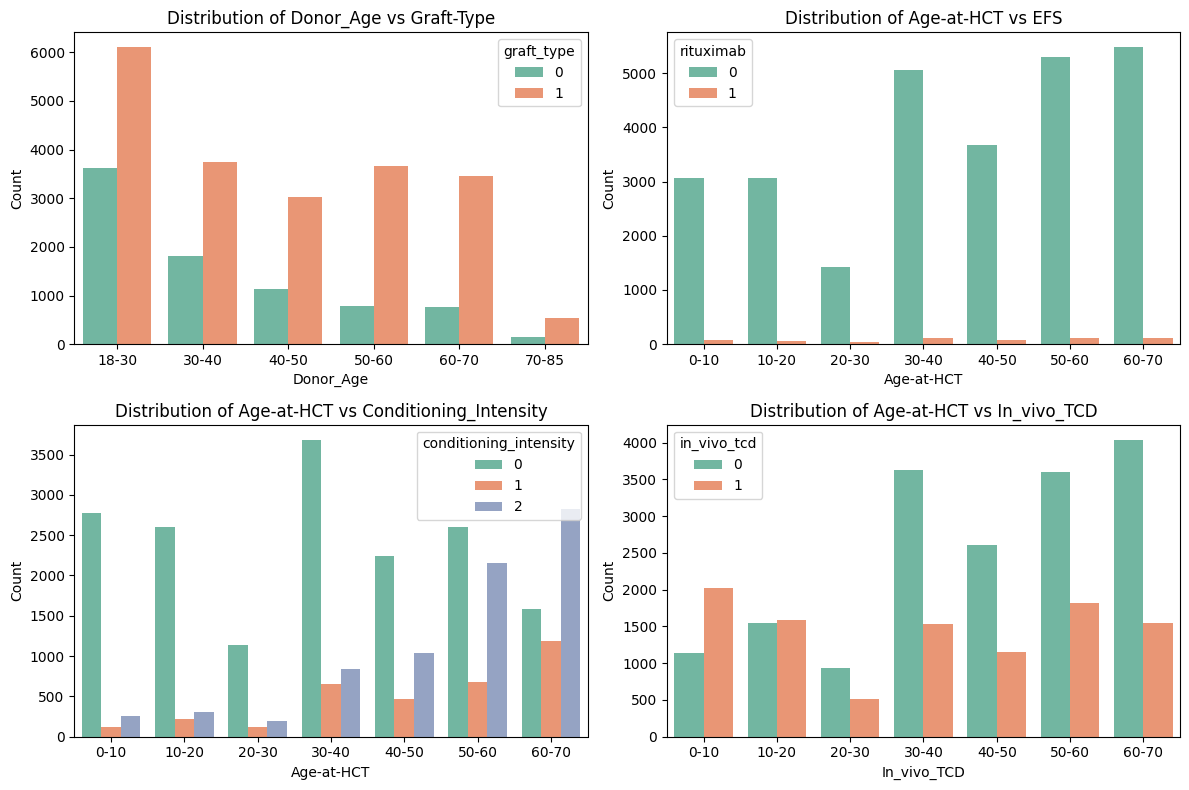

In [155]:
# Set the overall figure size
plt.figure(figsize=(12, 8))

# Plot 4: donor-age vs graft_type
plt.subplot(2, 2, 1)

sns.countplot(x='donor_age', hue='graft_type', data=my_data, palette='Set2')  # Create a count plot
plt.title("Distribution of Donor_Age vs Graft-Type")  # Add title for the plot
plt.xlabel("Donor_Age")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: age-at-hct vs rituximab
plt.subplot(2, 2, 2)

sns.countplot(x='age_at_hct', hue='rituximab', data=my_data, palette='Set2')  # Create a count plot
plt.title("Distribution of Age-at-HCT vs EFS")  # Add title for the plot
plt.xlabel("Age-at-HCT")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 3: age_at_hct vs conditioning_intensity:
plt.subplot(2, 2, 3)

sns.countplot(x='age_at_hct', hue='conditioning_intensity', data=my_data, palette='Set2')  # Create a count plot
plt.title("Distribution of Age-at-HCT vs Conditioning_Intensity")  # Add title for the plot
plt.xlabel("Age-at-HCT")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: age-at-hct vs in_vivo_tcd 
plt.subplot(2, 2, 4)

sns.countplot(x='age_at_hct', hue='in_vivo_tcd', data=my_data, palette='Set2')  # Create a count plot
plt.title("Distribution of Age-at-HCT vs In_vivo_TCD")  # Add title for the plot
plt.xlabel("In_vivo_TCD")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

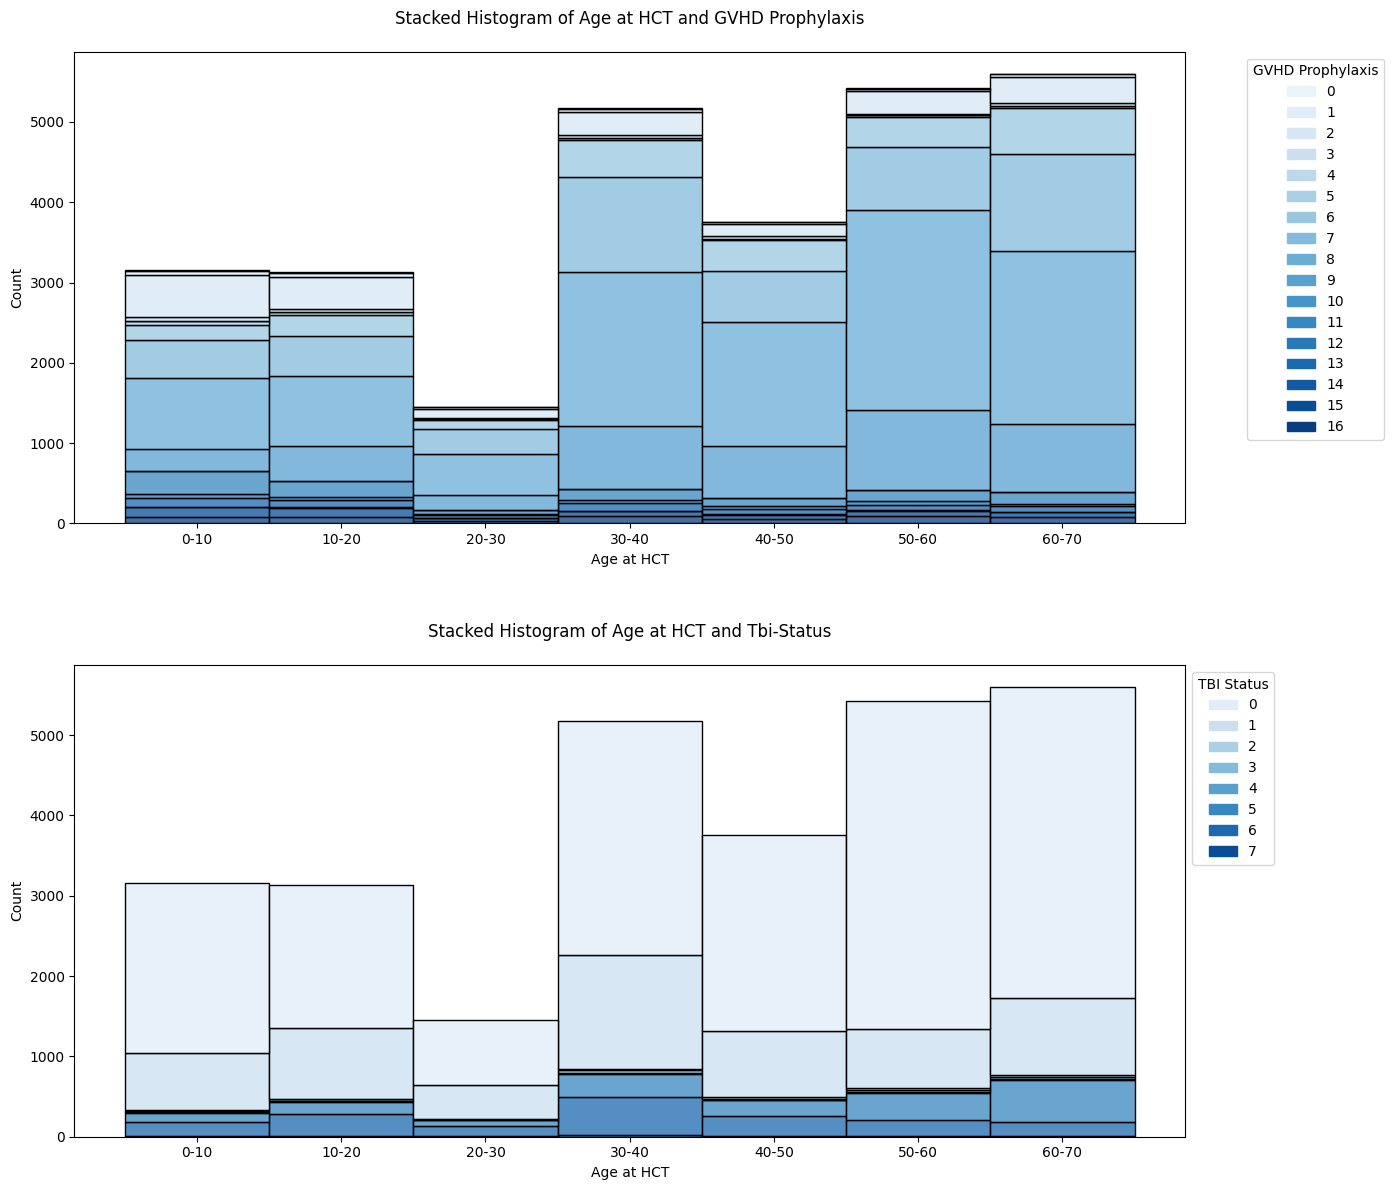

In [156]:
# Create figure with 2 vertical subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(14, 12))  # Increased height for vertical spacing

# -----------------------------------------------------------------
# Plot 1: Top plot (age_at_hct vs gvhd_proph)
# -----------------------------------------------------------------
hue_categories_1 = sorted(my_data['gvhd_proph'].unique())
palette_1 = sns.color_palette("Blues", n_colors=len(hue_categories_1))

sns.histplot(data=my_data,x='age_at_hct',hue='gvhd_proph',multiple='stack',palette=palette_1,ax=axes[0],legend=False)
axes[0].set_title("Stacked Histogram of Age at HCT and GVHD Prophylaxis", pad=20)
axes[0].set_xlabel("Age at HCT")
axes[0].set_ylabel("Count")

# Legend for top plot (right side)
legend_patches_1 = [Patch(color=color, label=label) for color, label in zip(palette_1, hue_categories_1)]
axes[0].legend(handles=legend_patches_1,bbox_to_anchor=(1.05, 1),loc='upper left',title='GVHD Prophylaxis')

# -----------------------------------------------------------------
# Plot 2: Bottom plot (age_at_hct vs tbi_status)
# -----------------------------------------------------------------
hue_categories_2 = sorted(my_data['tbi_status'].unique())
palette_2 = sns.color_palette("Blues", n_colors=len(hue_categories_2))

sns.histplot(data=my_data,x='age_at_hct',hue='tbi_status',multiple='stack',palette=palette_2,ax=axes[1],legend=False)

axes[1].set_title("Stacked Histogram of Age at HCT and Tbi-Status", pad=20)
axes[1].set_xlabel("Age at HCT")
axes[1].set_ylabel("Count")

# Legend for bottom plot (right side)
legend_patches_2 = [Patch(color=color, label=label) for color, label in zip(palette_2, hue_categories_2)]
axes[1].legend(handles=legend_patches_2,bbox_to_anchor=(1.0, 1),loc='upper left',title='TBI Status')

# -----------------------------------------------------------------
# Final layout adjustments
# -----------------------------------------------------------------
plt.tight_layout()
plt.subplots_adjust(hspace=0.3,right=0.85)

plt.show()

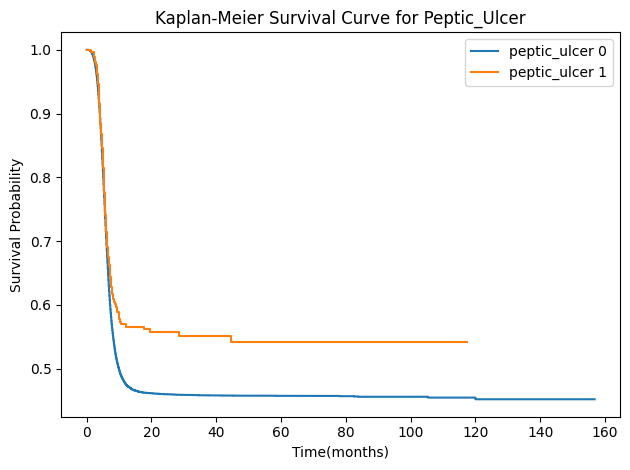

In [157]:
# plot Kaplan-Meier curve for 'peptic_ulcer' column
plot_kaplan_meier('peptic_ulcer' , 'Kaplan-Meier Survival Curve for Peptic_Ulcer')

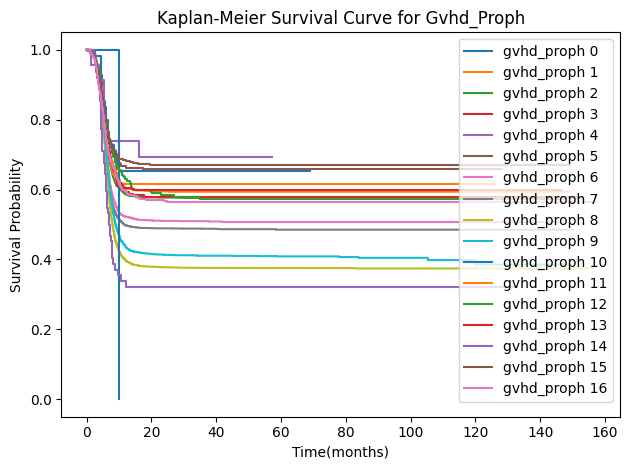

In [158]:
# plot Kaplan-Meier curve for 'gvhd_proph' column
plot_kaplan_meier('gvhd_proph' , 'Kaplan-Meier Survival Curve for Gvhd_Proph')

In [159]:
# 18- Is there a relationship between the 'hla_match_b_high' column and 'hla_low_res_8' 
# and 'hla_low_res_10' and 'hla_match_drb1_high'  the 'efs' or 'efs_time' columns?

# Logistic Regression Model using the Logit function ?
# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(hla_match_b_high) + C(hla_low_res_8) + C(hla_low_res_10) + (hla_match_drb1_high)' , data=data_train).fit()

# Print the Model Logistic results
print(model_logistic.summary()) 

         Current function value: 0.686747
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28784
Method:                           MLE   Df Model:                           15
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                0.004792
Time:                        20:42:21   Log-Likelihood:                -19778.
converged:                      False   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                 1.823e-32
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     15.7079   3607.048      0.004      0.997   -7053.976    7085.392
C(hla_match_b_hig

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [160]:
# Regression Model using the OLS function ?
model_ols = ols(formula='efs_time ~ C(hla_match_b_high) + C(hla_low_res_8) + C(hla_low_res_10) + (hla_match_drb1_high)' , data=data_train).fit()

# print the model OLS results
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     6.340
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           1.16e-13
Time:                        20:42:22   Log-Likelihood:            -1.3329e+05
No. Observations:               28800   AIC:                         2.666e+05
Df Residuals:                   28784   BIC:                         2.667e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

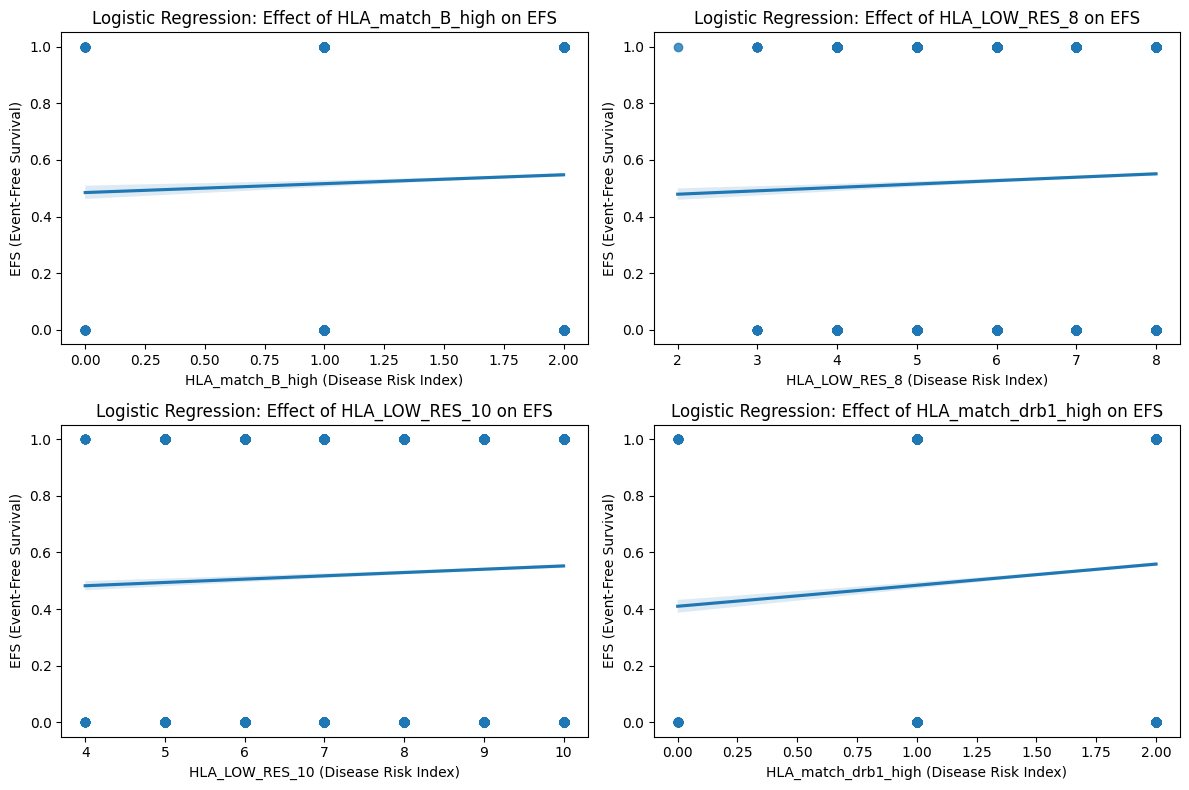

In [161]:
plt.figure(figsize=(12,8))

# First subplot: Logistic regression plot for 'hla_match_b_high' vs 'efs'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='hla_match_b_high' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_match_B_high on EFS")  # Title of the plot
plt.xlabel("HLA_match_B_high (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Second subplot: Logistic regression plot for 'hla_low_res_8' vs 'efs'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='hla_low_res_8' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_LOW_RES_8 on EFS")  # Title of the plot
plt.xlabel("HLA_LOW_RES_8 (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'hla_low_res_10' vs 'efs'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='hla_low_res_10' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_LOW_RES_10 on EFS")  # Title of the plot
plt.xlabel("HLA_LOW_RES_10 (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'hla_match_drb1_high' vs 'efs'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='hla_match_drb1_high' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of HLA_match_drb1_high on EFS")  # Title of the plot
plt.xlabel("HLA_match_drb1_high (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

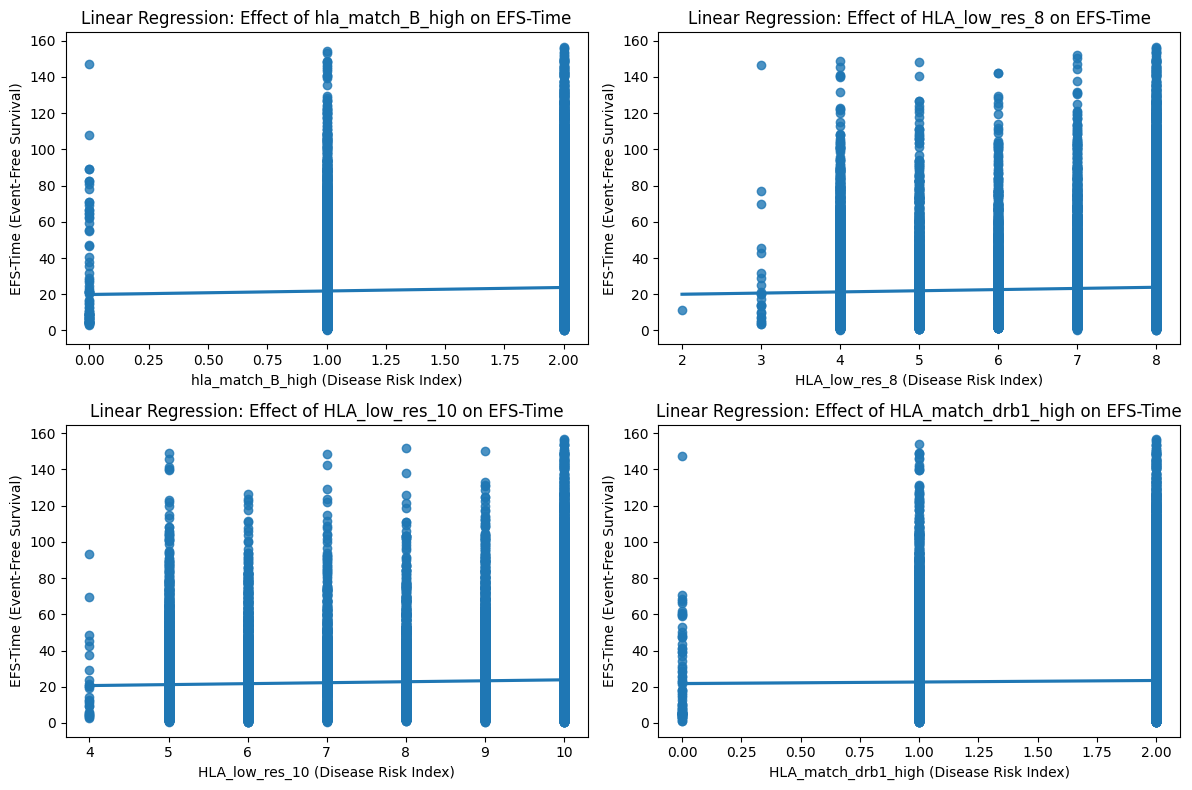

In [162]:
plt.figure(figsize=(12,8))

# First subplot: Linear regression plot for 'hla_match_b_high' vs 'efs_time'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='hla_match_b_high' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of hla_match_B_high on EFS-Time")  # Title of the plot
plt.xlabel("hla_match_B_high (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Second subplot: Linear regression plot for 'hla_low_res_8' vs 'efs_time'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='hla_low_res_8' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_low_res_8 on EFS-Time")  # Title of the plot
plt.xlabel("HLA_low_res_8 (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'hla_low_res_10' vs 'efs_time'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='hla_low_res_10' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_low_res_10 on EFS-Time")  # Title of the plot
plt.xlabel("HLA_low_res_10 (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'hla_match_drb1_high' vs 'efs_time'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='hla_match_drb1_high' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of HLA_match_drb1_high on EFS-Time")  # Title of the plot
plt.xlabel("HLA_match_drb1_high (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

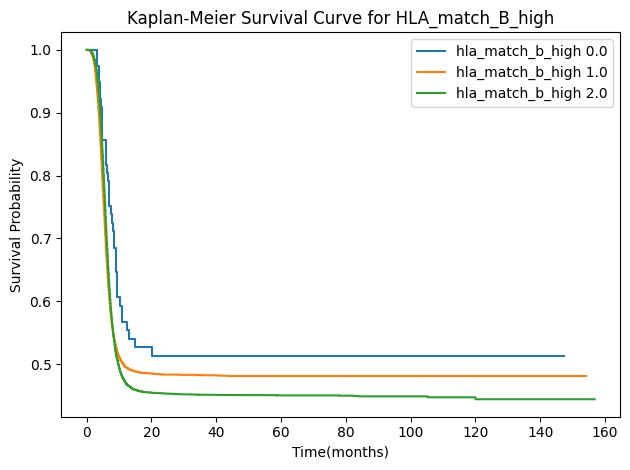

In [163]:
# plot Kaplan-Meier curve for 'hla_match_b_high' column
plot_kaplan_meier('hla_match_b_high' , 'Kaplan-Meier Survival Curve for HLA_match_B_high')

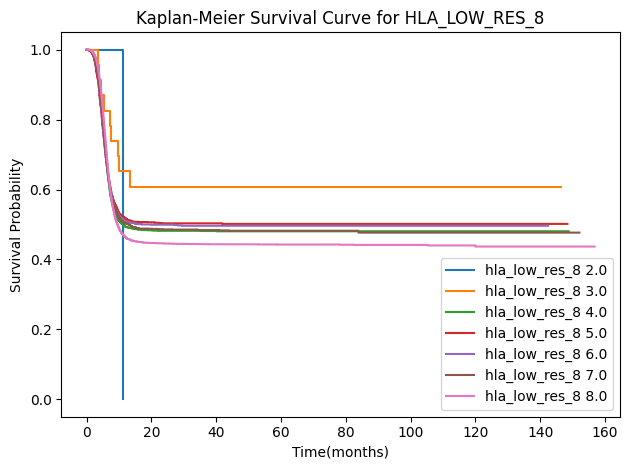

In [164]:
# plot Kaplan-Meier curve for 'hla_low_res_8' column
plot_kaplan_meier('hla_low_res_8' , 'Kaplan-Meier Survival Curve for HLA_LOW_RES_8')

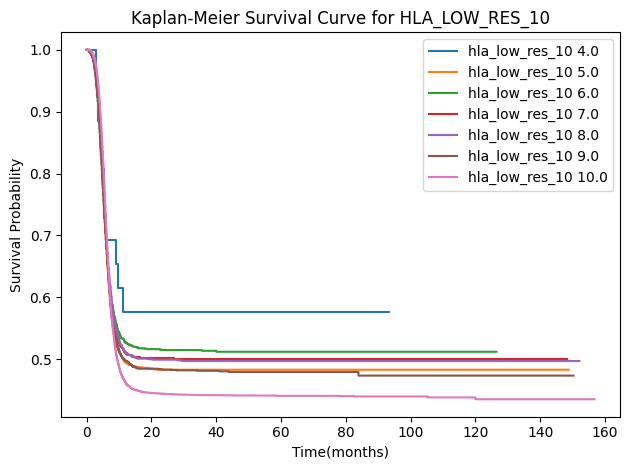

In [165]:
# plot Kaplan-Meier curve for 'hla_low_res_10' column
plot_kaplan_meier('hla_low_res_10' , 'Kaplan-Meier Survival Curve for HLA_LOW_RES_10')

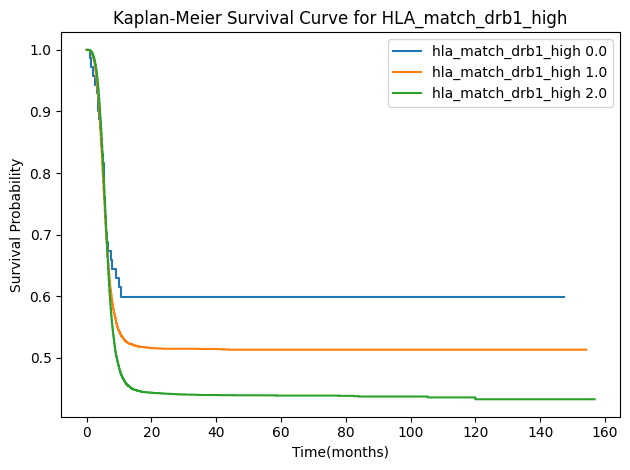

In [166]:
# plot Kaplan-Meier curve for 'hla_match_drb1_high' column
plot_kaplan_meier('hla_match_drb1_high' , 'Kaplan-Meier Survival Curve for HLA_match_drb1_high')

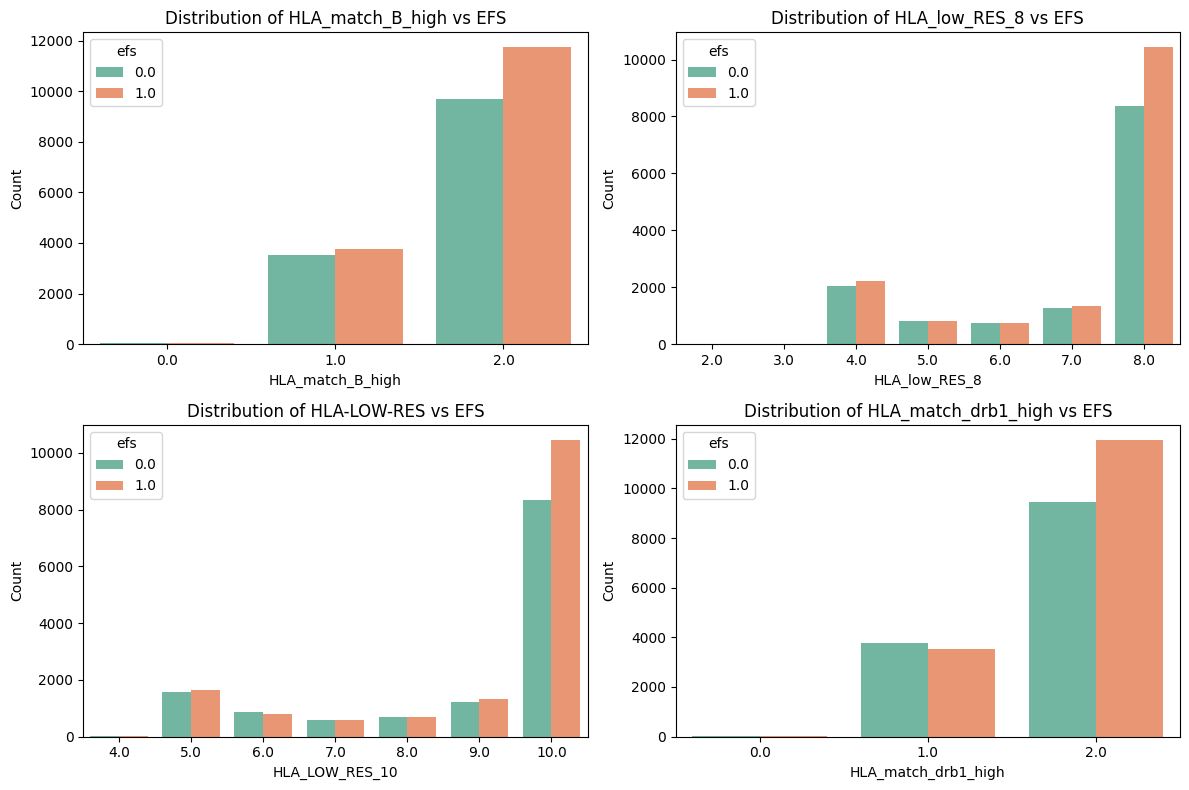

In [167]:
# Set the overall figure size
plt.figure(figsize=(12, 8))

# Plot 1: hla_match_b_high vs EFS
plt.subplot(2, 2, 1)

sns.countplot(x='hla_match_b_high', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_match_B_high vs EFS")  # Add title for the plot
plt.xlabel("HLA_match_B_high")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 2: hla_low_res_8 vs EFS
plt.subplot(2, 2, 2)

sns.countplot(x='hla_low_res_8', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_low_RES_8 vs EFS")  # Add title for the plot
plt.xlabel("HLA_low_RES_8")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 3: hla_low_res_10 vs EFS
plt.subplot(2, 2, 3)

sns.countplot(x='hla_low_res_10', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA-LOW-RES vs EFS")  # Add title for the plot
plt.xlabel("HLA_LOW_RES_10")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: hla_match_drb1_high vs EFS
plt.subplot(2, 2, 4)

sns.countplot(x='hla_match_drb1_high', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of HLA_match_drb1_high vs EFS")  # Add title for the plot
plt.xlabel("HLA_match_drb1_high")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()

In [168]:
# Logistic Regression Model using the Logit function ?
# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(rheum_issue) + C(sex_match) + C(tce_div_match) + (race_group)' , data=data_train).fit()

# Print the Model Logistic results
print(model_logistic.summary()) 

Optimization terminated successfully.
         Current function value: 0.685022
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28791
Method:                           MLE   Df Model:                            8
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                0.007292
Time:                        20:44:03   Log-Likelihood:                -19729.
converged:                       True   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                 6.006e-58
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.5302      0.088     -6.013      0.000      -0.703      -0.

In [169]:
# 19- Is there a relationship between the 'rheum_issue' column and 'sex_match' 
# and 'tce_div_match' and 'race_group'  the 'efs' or 'efs_time' columns?


# Logistic Regression Model using the Logit function ?
# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(rheum_issue) + C(sex_match) + C(tce_div_match) + (race_group)' , data=data_train).fit()

# Print the Model Logistic results
print(model_logistic.summary())

Optimization terminated successfully.
         Current function value: 0.685022
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28791
Method:                           MLE   Df Model:                            8
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                0.007292
Time:                        20:44:03   Log-Likelihood:                -19729.
converged:                       True   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                 6.006e-58
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.5302      0.088     -6.013      0.000      -0.703      -0.

In [170]:
# Regression Model using the OLS function ?
model_ols = ols(formula='efs_time ~ C(rheum_issue) + C(sex_match) + C(tce_div_match) + (race_group)' , data=data_train).fit()

# print the model OLS results
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     25.57
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           9.65e-40
Time:                        20:44:04   Log-Likelihood:            -1.3324e+05
No. Observations:               28800   AIC:                         2.665e+05
Df Residuals:                   28791   BIC:                         2.666e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                30.17

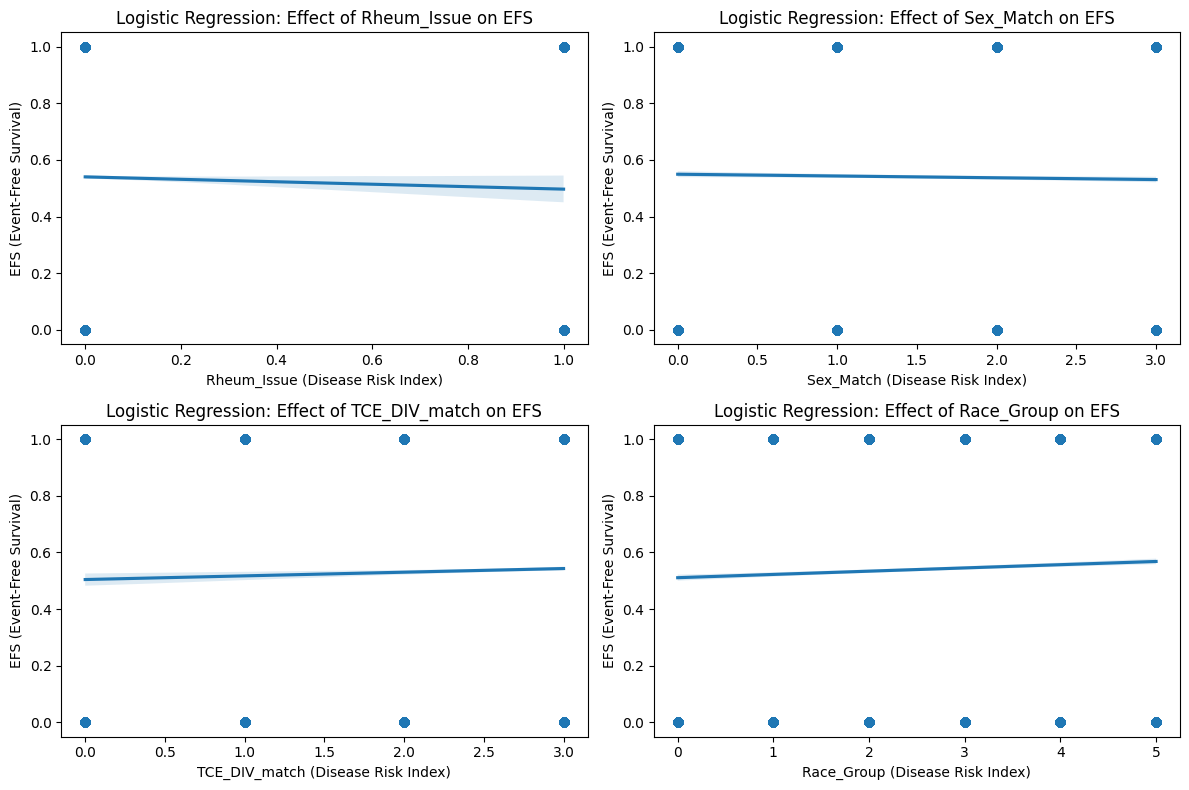

In [171]:
plt.figure(figsize=(12,8))

# First subplot: Logistic regression plot for 'rheum_issue' vs 'efs'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='rheum_issue' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Rheum_Issue on EFS")  # Title of the plot
plt.xlabel("Rheum_Issue (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Second subplot: Logistic regression plot for 'sex_match' vs 'efs'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='sex_match' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Sex_Match on EFS")  # Title of the plot
plt.xlabel("Sex_Match (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'tce_div_match' vs 'efs'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='tce_div_match' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of TCE_DIV_match on EFS")  # Title of the plot
plt.xlabel("TCE_DIV_match (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'race_group' vs 'efs'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='race_group' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Race_Group on EFS")  # Title of the plot
plt.xlabel("Race_Group (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()



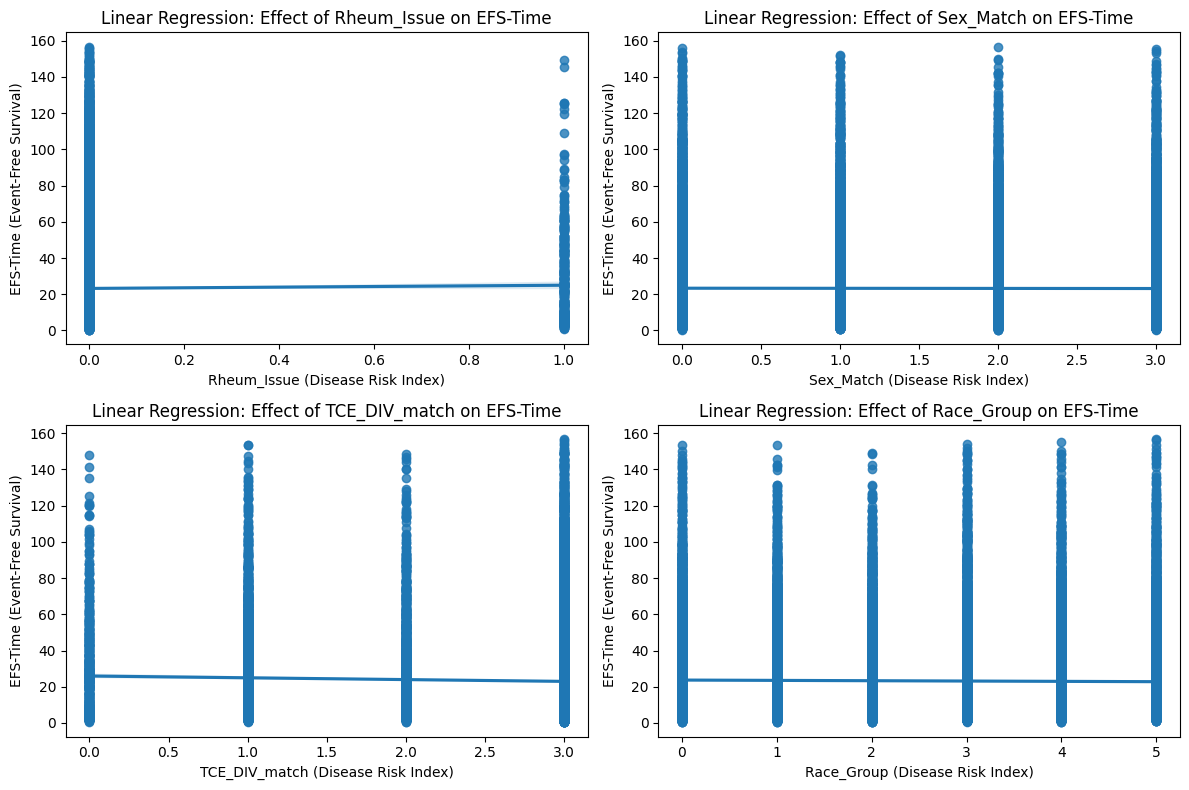

In [172]:
plt.figure(figsize=(12,8))

# First subplot: Linear regression plot for 'rheum_issue' vs 'efs_time'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='rheum_issue' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Rheum_Issue on EFS-Time")  # Title of the plot
plt.xlabel("Rheum_Issue (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Second subplot: Linear regression plot for 'sex_match' vs 'efs_time'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='sex_match' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Sex_Match on EFS-Time")  # Title of the plot
plt.xlabel("Sex_Match (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'tce_div_match' vs 'efs_time'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='tce_div_match' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of TCE_DIV_match on EFS-Time")  # Title of the plot
plt.xlabel("TCE_DIV_match (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'race_group' vs 'efs_time'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='race_group' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Race_Group on EFS-Time")  # Title of the plot
plt.xlabel("Race_Group (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()


In [173]:

# Test the function with 'rheum_issue' as the first variable and 'efs' as the second variable.
# This checks if there's a significant association between these two categorical variables.
chi2_contingency_test('rheum_issue', 'efs')

Title: rheum_issue
Chi2: 3.2179563674097666
P-value: 0.07283450861906463
Degrees of Freedom: 1
Expected Frequencies: [[13057.46263889 15285.53736111]
 [  210.53736111   246.46263889]]
Cramér's V: 0.01057045865091089


In [174]:
# Test the function with 'sex_match' as the first variable and 'efs' as the second variable.
chi2_contingency_test('sex_match' , 'efs')

Title: sex_match
Chi2: 211.11182080110473
P-value: 1.6745174380676516e-45
Degrees of Freedom: 3
Expected Frequencies: [[2774.30194444 3247.69805556]
 [3603.55194444 4218.44805556]
 [3093.56319444 3621.43680556]
 [3796.58291667 4444.41708333]]
Cramér's V: 0.0856170050608751


In [175]:
# Test the function with 'tce_div_match' as the first variable and 'efs' as the second variable.
chi2_contingency_test('tce_div_match' , 'efs')

Title: tce_div_match
Chi2: 22.669996834351
P-value: 4.731121610331195e-05
Degrees of Freedom: 3
Expected Frequencies: [[  273.19180556   319.80819444]
 [ 1132.38694444  1325.61305556]
 [  652.80402778   764.19597222]
 [11209.61722222 13122.38277778]]
Cramér's V: 0.0280562411569941


In [176]:
# Test the function with 'race_group' as the first variable and 'efs' as the second variable.
chi2_contingency_test('race_group' , 'efs')

Title: race_group
Chi2: 280.8346638335839
P-value: 1.3172052971466758e-58
Degrees of Freedom: 5
Expected Frequencies: [[2206.72638889 2583.27361111]
 [2226.07555556 2605.92444444]
 [2209.02986111 2585.97013889]
 [2232.06458333 2612.93541667]
 [2168.48875    2538.51125   ]
 [2225.61486111 2605.38513889]]
Cramér's V: 0.09874818279509134


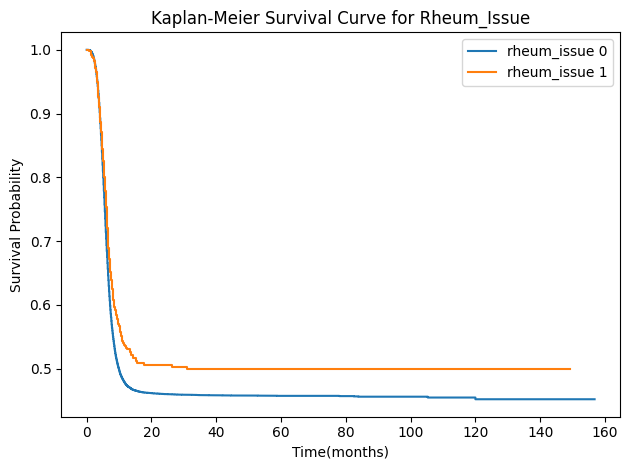

In [177]:
# plot Kaplan-Meier curve for 'rheum_issue' column
plot_kaplan_meier('rheum_issue' , 'Kaplan-Meier Survival Curve for Rheum_Issue')

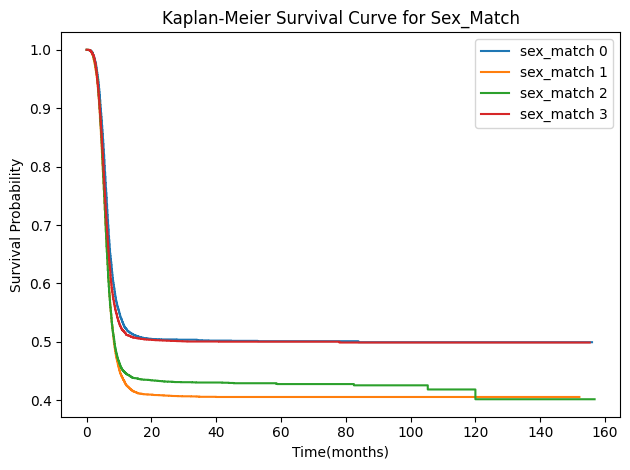

In [178]:
# plot Kaplan-Meier curve for 'sex_match' column
plot_kaplan_meier('sex_match' , 'Kaplan-Meier Survival Curve for Sex_Match')

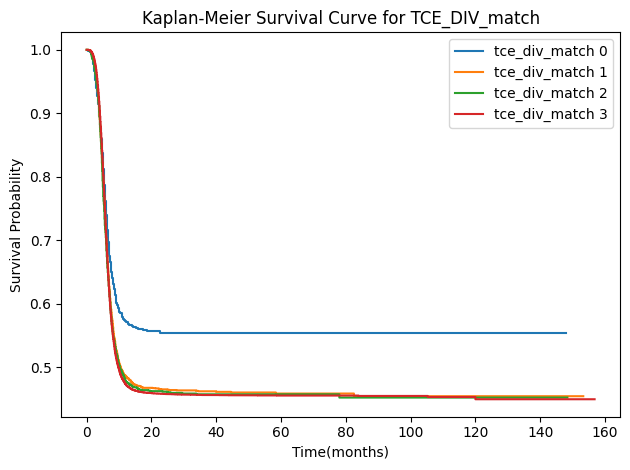

In [179]:
# plot Kaplan-Meier curve for 'tce_div_match' column
plot_kaplan_meier('tce_div_match' , 'Kaplan-Meier Survival Curve for TCE_DIV_match')

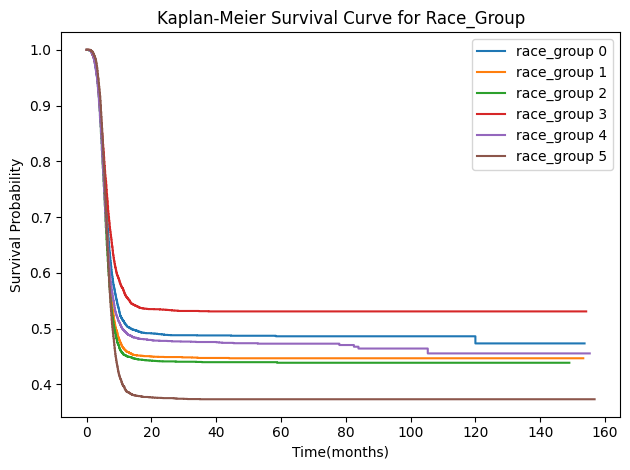

In [180]:
# plot Kaplan-Meier curve for 'race_group' column
plot_kaplan_meier('race_group' , 'Kaplan-Meier Survival Curve for Race_Group')

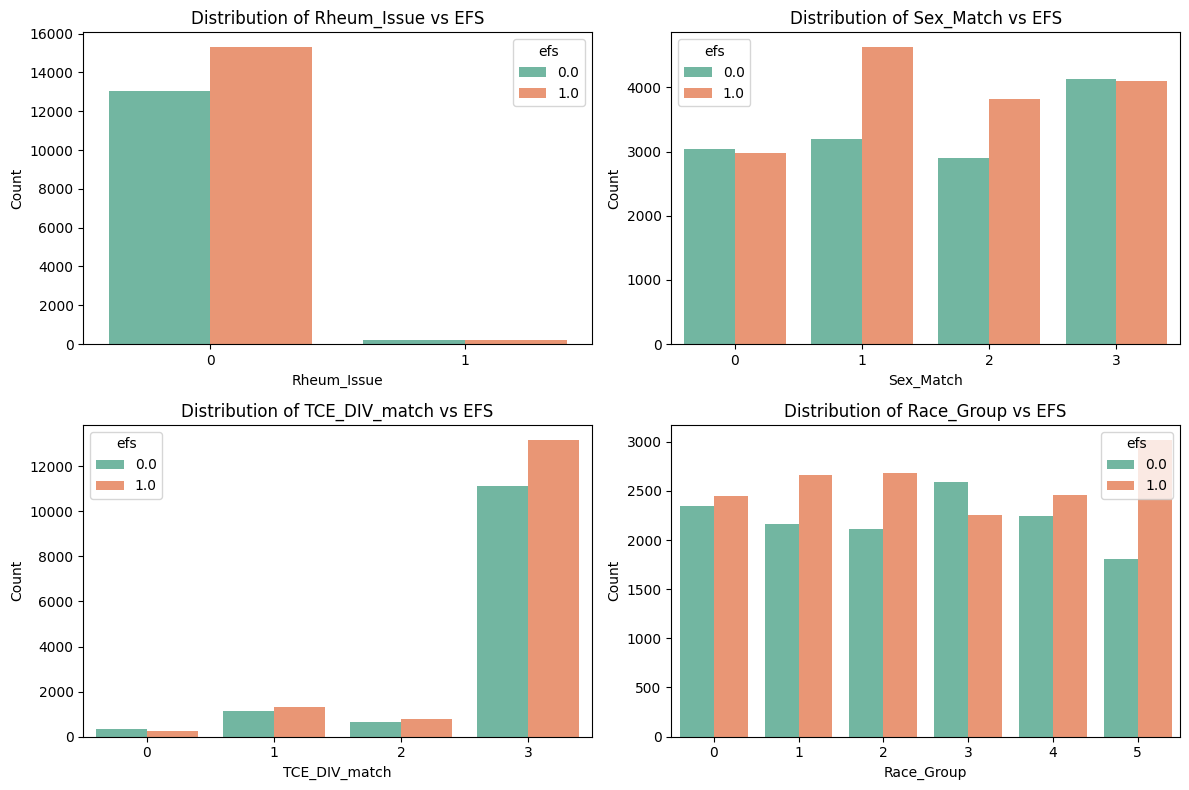

In [181]:
# Set the overall figure size
plt.figure(figsize=(12, 8))

# Plot 1: rheum_issue vs EFS
plt.subplot(2, 2, 1)

sns.countplot(x='rheum_issue', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Rheum_Issue vs EFS")  # Add title for the plot
plt.xlabel("Rheum_Issue")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 2: sex_match vs EFS
plt.subplot(2, 2, 2)

sns.countplot(x='sex_match', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Sex_Match vs EFS")  # Add title for the plot
plt.xlabel("Sex_Match")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 3: tce_div_match vs EFS
plt.subplot(2, 2, 3)

sns.countplot(x='tce_div_match', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of TCE_DIV_match vs EFS")  # Add title for the plot
plt.xlabel("TCE_DIV_match")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: race_group vs EFS
plt.subplot(2, 2, 4)

sns.countplot(x='race_group', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Race_Group vs EFS")  # Add title for the plot
plt.xlabel("Race_Group")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()

In [182]:
# 20- Is there a relationship between the 'comorbidity_score' column and 
# 'karnofsky_score' and 'hepatic_mild' and 'donor_related'  the 'efs' or 'efs_time' columns?

# Logistic Regression Model using the Logit function ?
# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(comorbidity_score) + C(karnofsky_score) + C(hepatic_mild) + C(donor_related)' , data=data_train).fit()

# Print the Model Logistic results
print(model_logistic.summary()) 

Optimization terminated successfully.
         Current function value: 0.673793
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28780
Method:                           MLE   Df Model:                           19
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                 0.02356
Time:                        20:45:45   Log-Likelihood:                -19405.
converged:                       True   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                1.761e-186
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.4016      0.644     -0.624      0.533

In [183]:
# Regression Model using the OLS function ?
model_ols = ols(formula='efs_time ~ C(comorbidity_score) + C(karnofsky_score) + C(hepatic_mild) + C(donor_related)' , data=data_train).fit()

# print the model OLS results
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     44.98
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          1.97e-166
Time:                        20:45:45   Log-Likelihood:            -1.3292e+05
No. Observations:               28800   AIC:                         2.659e+05
Df Residuals:                   28780   BIC:                         2.660e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

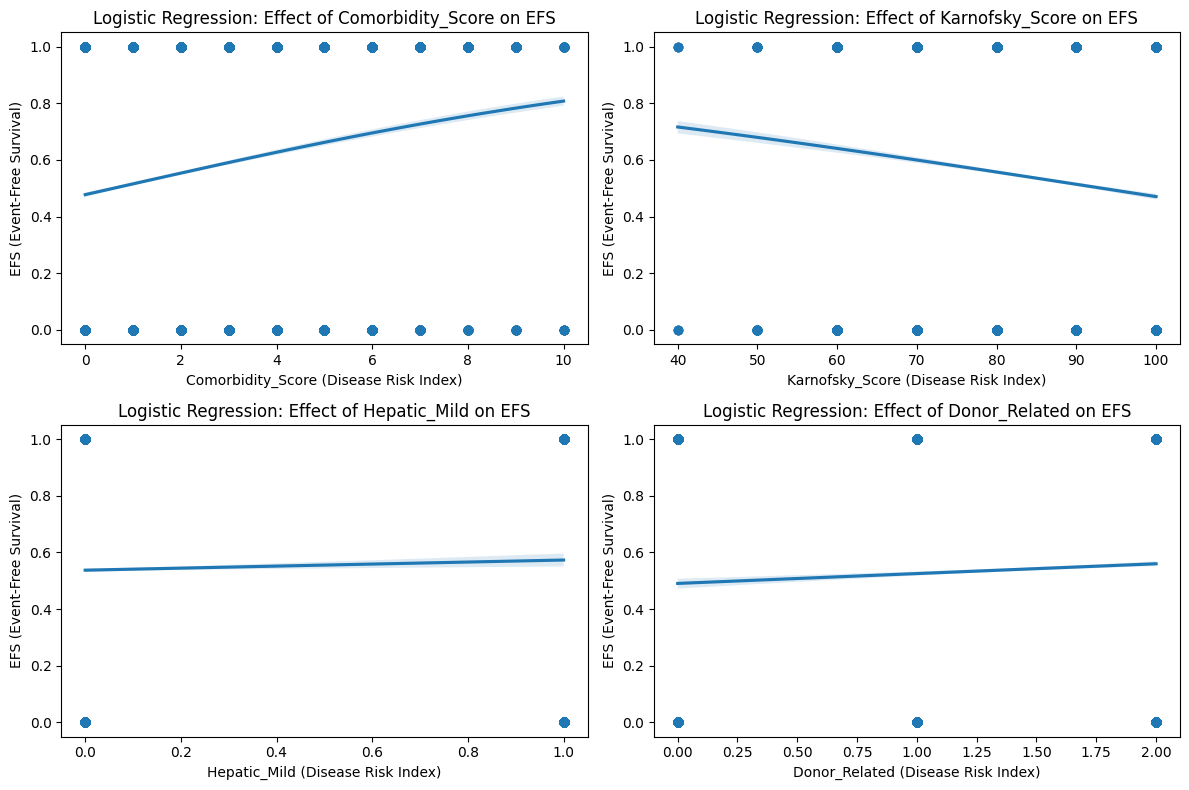

In [184]:
plt.figure(figsize=(12,8))

# First subplot: Logistic regression plot for 'comorbidity_score' vs 'efs'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='comorbidity_score' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Comorbidity_Score on EFS")  # Title of the plot
plt.xlabel("Comorbidity_Score (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Second subplot: Logistic regression plot for 'karnofsky_score' vs 'efs'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='karnofsky_score' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Karnofsky_Score on EFS")  # Title of the plot
plt.xlabel("Karnofsky_Score (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'hepatic_mild' vs 'efs'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='hepatic_mild' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Hepatic_Mild on EFS")  # Title of the plot
plt.xlabel("Hepatic_Mild (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'donor_related' vs 'efs'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='donor_related' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Donor_Related on EFS")  # Title of the plot
plt.xlabel("Donor_Related (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

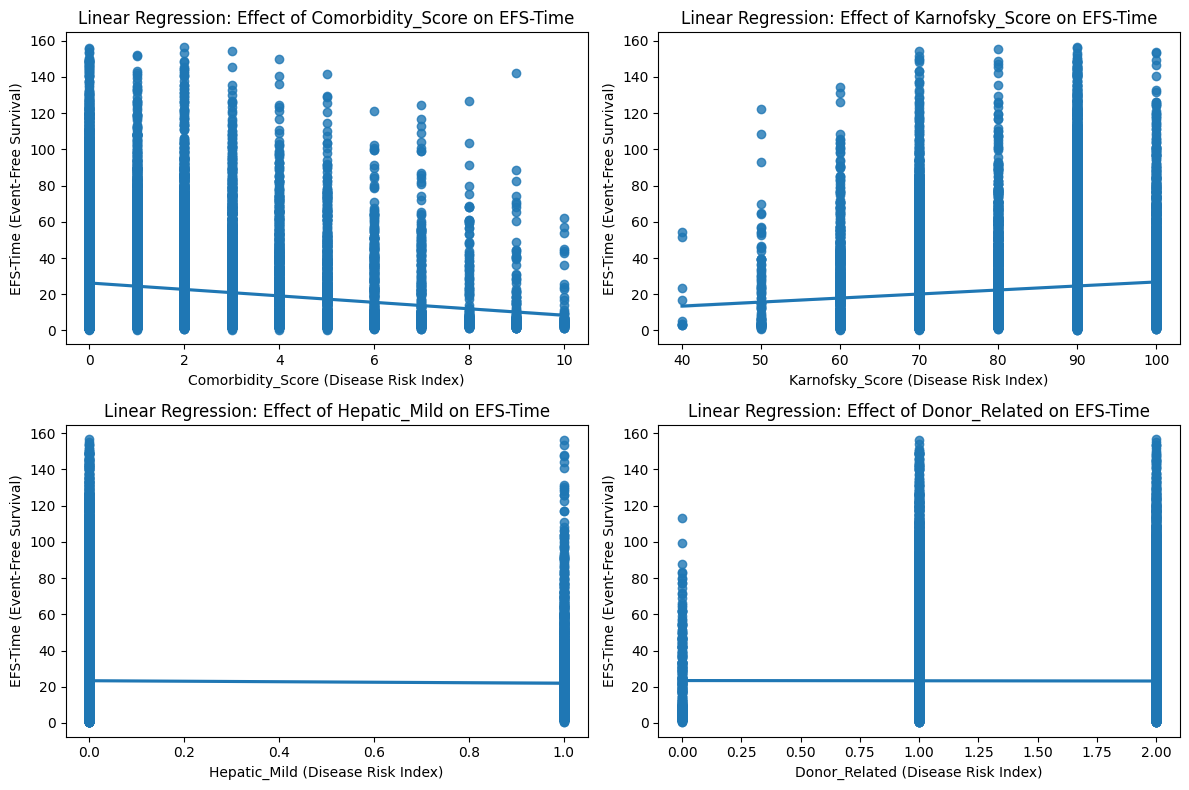

In [185]:
plt.figure(figsize=(12,8))
# First subplot: Linear regression plot for 'comorbidity_score' vs 'efs_time'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='comorbidity_score' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Comorbidity_Score on EFS-Time")  # Title of the plot
plt.xlabel("Comorbidity_Score (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Second subplot: Linear regression plot for 'karnofsky_score' vs 'efs_time'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='karnofsky_score' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Karnofsky_Score on EFS-Time")  # Title of the plot
plt.xlabel("Karnofsky_Score (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'hepatic_mild' vs 'efs_time'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='hepatic_mild' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Hepatic_Mild on EFS-Time")  # Title of the plot
plt.xlabel("Hepatic_Mild (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Fourth subplot: Logistic regression plot for 'donor_related' vs 'efs_time'
# Creates the fourth subplot in the grid
plt.subplot(2,2,4)  

sns.regplot(x='donor_related' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Donor_Related on EFS-Time")  # Title of the plot
plt.xlabel("Donor_Related (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

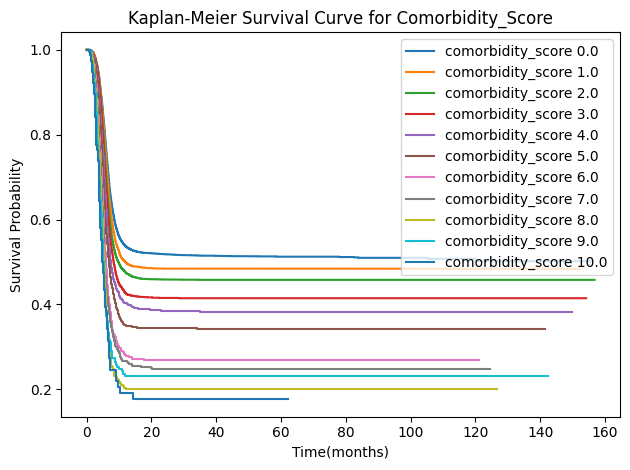

In [186]:
# plot Kaplan-Meier curve for 'comorbidity_score' column
plot_kaplan_meier('comorbidity_score' , 'Kaplan-Meier Survival Curve for Comorbidity_Score')

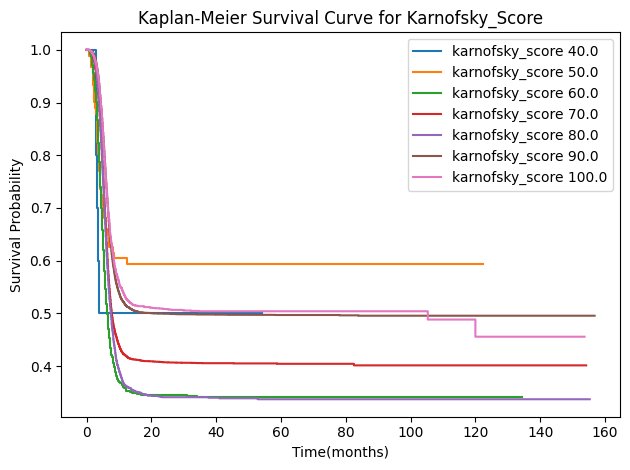

In [187]:
# plot Kaplan-Meier curve for 'karnofsky_score' column
plot_kaplan_meier('karnofsky_score' , 'Kaplan-Meier Survival Curve for Karnofsky_Score')

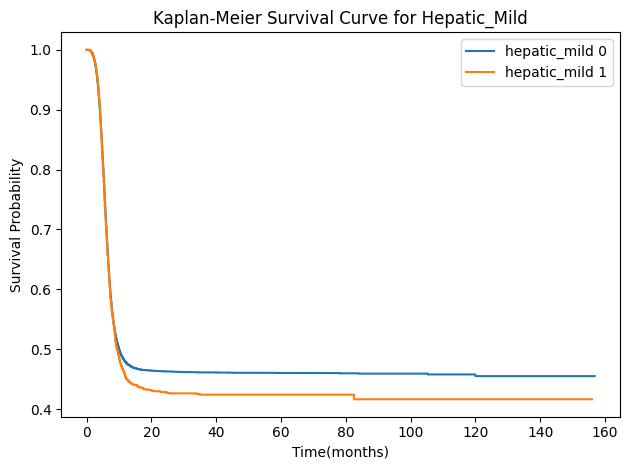

In [188]:
# plot Kaplan-Meier curve for 'hepatic_mild' column
plot_kaplan_meier('hepatic_mild' , 'Kaplan-Meier Survival Curve for Hepatic_Mild')

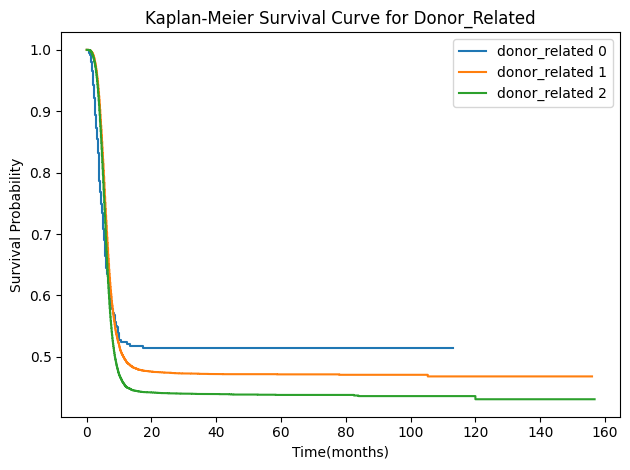

In [189]:
# plot Kaplan-Meier curve for 'donor_related' column
plot_kaplan_meier('donor_related' , 'Kaplan-Meier Survival Curve for Donor_Related')

In [190]:
# Test the function with 'comorbidity_score' as the first variable and 'efs' as the second variable.
# This checks if there's a significant association between these two categorical variables.
chi2_contingency_test('comorbidity_score', 'efs')

Title: comorbidity_score
Chi2: 602.2432760104532
P-value: 5.8220909667387674e-123
Degrees of Freedom: 10
Expected Frequencies: [[5166.68819444 6048.31180556]
 [2235.28944444 2616.71055556]
 [2717.63652778 3181.36347222]
 [1133.30833333 1326.69166667]
 [ 643.12944444  752.87055556]
 [ 561.58652778  657.41347222]
 [ 326.17166667  381.82833333]
 [ 226.66166667  265.33833333]
 [ 134.98347222  158.01652778]
 [  87.53194444  102.46805556]
 [  35.01277778   40.98722222]]
Cramér's V: 0.14460713973201347


In [191]:
# Test the function with 'karnofsky_score' as the first variable and 'efs' as the second variable.
chi2_contingency_test('karnofsky_score' , 'efs')

Title: karnofsky_score
Chi2: 384.6514082358367
P-value: 5.5663280631909006e-80
Degrees of Freedom: 6
Expected Frequencies: [[4.60694444e+00 5.39305556e+00]
 [4.19231944e+01 4.90768056e+01]
 [5.94756528e+02 6.96243472e+02]
 [3.08204583e+03 3.60795417e+03]
 [9.37973889e+02 1.09802611e+03]
 [7.46601417e+03 8.73998583e+03]
 [1.14067944e+03 1.33532056e+03]]
Cramér's V: 0.11556795262898552


In [192]:
# Test the function with 'hepatic_mild' as the first variable and 'efs' as the second variable.
chi2_contingency_test('hepatic_mild' , 'efs')

Title: hepatic_mild
Chi2: 8.378866686468706
P-value: 0.0037960906074636534
Degrees of Freedom: 1
Expected Frequencies: [[12459.94194444 14586.05805556]
 [  808.05805556   945.94194444]]
Cramér's V: 0.017056754411608945


In [193]:
# Test the function with 'donor_related' as the first variable and 'efs' as the second variable.
chi2_contingency_test('donor_related' , 'efs')

Title: donor_related
Chi2: 36.91492068540553
P-value: 9.638885541813235e-09
Degrees of Freedom: 2
Expected Frequencies: [[ 159.40027778  186.59972222]
 [7539.72527778 8826.27472222]
 [5568.87444444 6519.12555556]]
Cramér's V: 0.035801788773109626


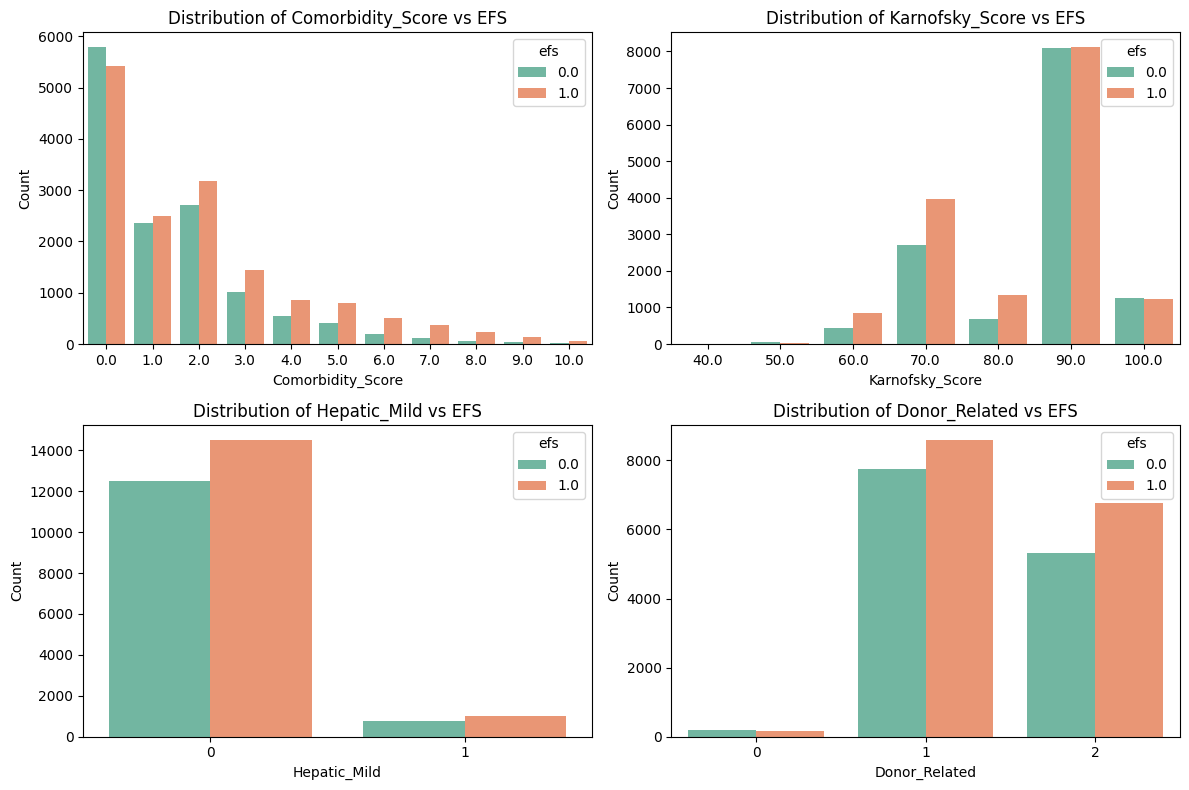

In [194]:
# Set the overall figure size
plt.figure(figsize=(12, 8))

# Plot 1: comorbidity_score vs EFS
plt.subplot(2, 2, 1)

sns.countplot(x='comorbidity_score', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Comorbidity_Score vs EFS")  # Add title for the plot
plt.xlabel("Comorbidity_Score")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 2: karnofsky_score vs EFS
plt.subplot(2, 2, 2)

sns.countplot(x='karnofsky_score', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Karnofsky_Score vs EFS")  # Add title for the plot
plt.xlabel("Karnofsky_Score")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 3: hepatic_mild vs EFS
plt.subplot(2, 2, 3)

sns.countplot(x='hepatic_mild', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Hepatic_Mild vs EFS")  # Add title for the plot
plt.xlabel("Hepatic_Mild")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 4: donor_related vs EFS
plt.subplot(2, 2, 4)

sns.countplot(x='donor_related', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Donor_Related vs EFS")  # Add title for the plot
plt.xlabel("Donor_Related")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()

In [195]:
# 21- Is there a relationship between the 'melphalan_dose' column 
# and 'cardiac' and 'pulm_moderate'  the 'efs' or 'efs_time' columns?


# Logistic Regression Model using the Logit function ?
# Build a logistic regression model
model_logistic = logit(formula='efs ~ C(melphalan_dose) + C(cardiac) + C(pulm_moderate)', data=data_train).fit()

# Print the Model Logistic results
print(model_logistic.summary())

Optimization terminated successfully.
         Current function value: 0.683210
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    efs   No. Observations:                28800
Model:                          Logit   Df Residuals:                    28796
Method:                           MLE   Df Model:                            3
Date:                Wed, 05 Mar 2025   Pseudo R-squ.:                0.009918
Time:                        20:47:26   Log-Likelihood:                -19676.
converged:                       True   LL-Null:                       -19874.
Covariance Type:            nonrobust   LLR p-value:                 3.982e-85
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0784      0.024      3.209      0.001       0.031      

In [196]:
# Regression Model using the OLS function ?
model_ols = ols(formula='efs_time ~ C(melphalan_dose) + C(cardiac) + C(pulm_moderate)' , data=data_train).fit()

# print the model OLS results
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               efs_time   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     81.46
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           1.79e-52
Time:                        20:47:27   Log-Likelihood:            -1.3322e+05
No. Observations:               28800   AIC:                         2.664e+05
Df Residuals:                   28796   BIC:                         2.665e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 23

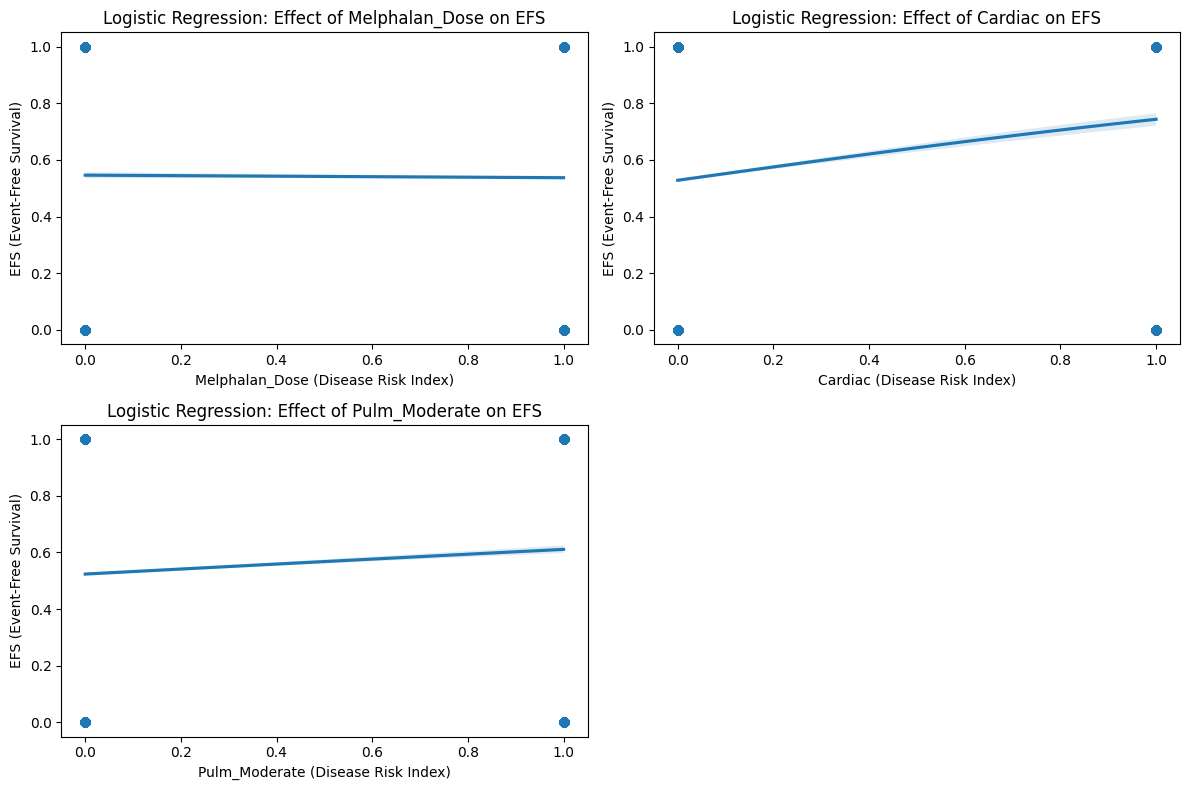

In [197]:
plt.figure(figsize=(12,8))

# First subplot: Logistic regression plot for 'melphalan_dose' vs 'efs'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='melphalan_dose' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Melphalan_Dose on EFS")  # Title of the plot
plt.xlabel("Melphalan_Dose (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Second subplot: Logistic regression plot for 'cardiac' vs 'efs'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='cardiac' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Cardiac on EFS")  # Title of the plot
plt.xlabel("Cardiac (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'pulm_moderate' vs 'efs'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='pulm_moderate' , y='efs' , data=data_train , logistic=True)  # Logistic regression plot
# Set title and axis labels for this plot
plt.title("Logistic Regression: Effect of Pulm_Moderate on EFS")  # Title of the plot
plt.xlabel("Pulm_Moderate (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

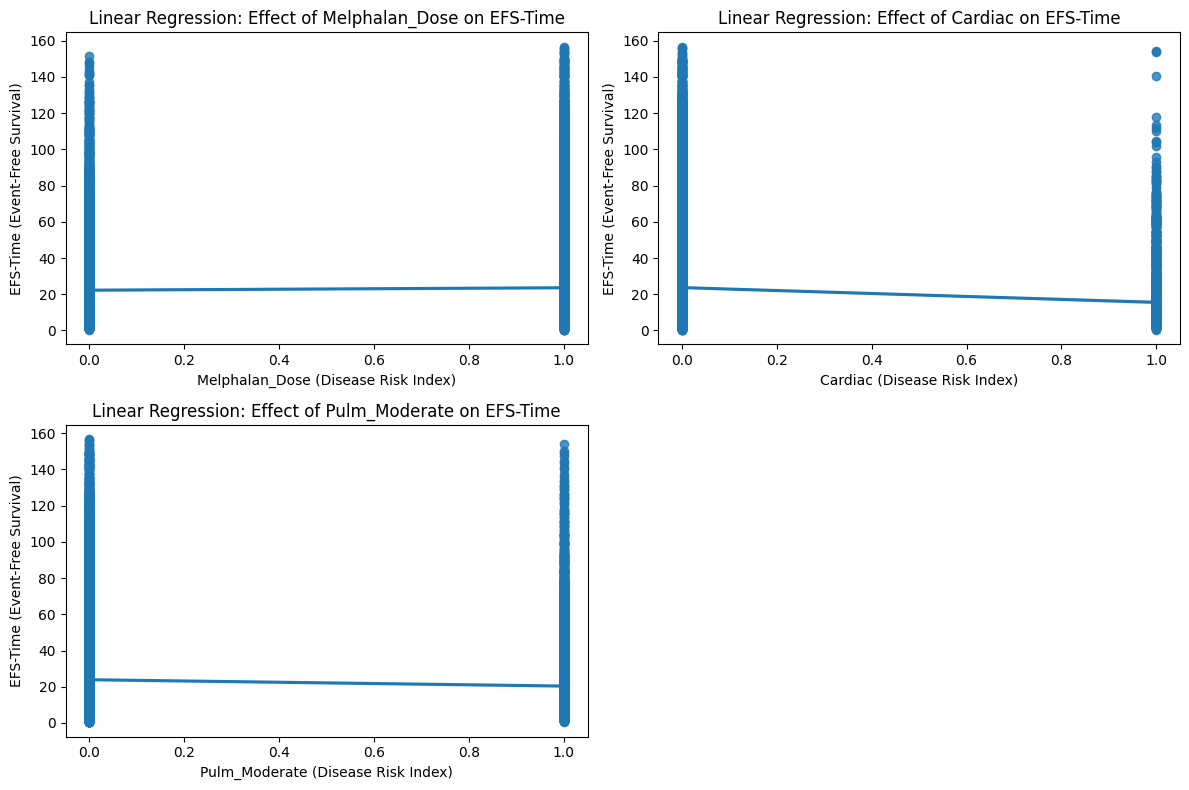

In [198]:
plt.figure(figsize=(12,8))
# First subplot: Linear regression plot for 'melphalan_dose' vs 'efs_time'
# Creates the first subplot in a 2x2 grid
plt.subplot(2,2,1)  

sns.regplot(x='melphalan_dose' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Melphalan_Dose on EFS-Time")  # Title of the plot
plt.xlabel("Melphalan_Dose (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Second subplot: Linear regression plot for 'cardiac' vs 'efs_time'
# Creates the second subplot in the grid
plt.subplot(2,2,2) 

sns.regplot(x='cardiac' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Cardiac on EFS-Time")  # Title of the plot
plt.xlabel("Cardiac (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Third subplot: Logistic regression plot for 'pulm_moderate' vs 'efs_time'
# Creates the third subplot in the grid
plt.subplot(2,2,3)

sns.regplot(x='pulm_moderate' , y='efs_time' , data=data_train , logistic=False)  # Linear regression plot
# Set title and axis labels for this plot
plt.title("Linear Regression: Effect of Pulm_Moderate on EFS-Time")  # Title of the plot
plt.xlabel("Pulm_Moderate (Disease Risk Index)")  # X-axis label
plt.ylabel("EFS-Time (Event-Free Survival)")  # Y-axis label

# Adjust the layout to prevent overlap and ensure the plots fit well
plt.tight_layout()
# Show the complete plot with all four subplots
plt.show()

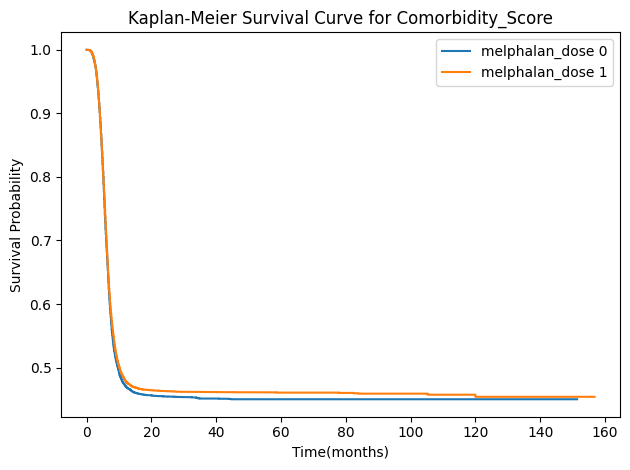

In [199]:
# plot Kaplan-Meier curve for 'melphalan_dose' column
plot_kaplan_meier('melphalan_dose' , 'Kaplan-Meier Survival Curve for Comorbidity_Score')

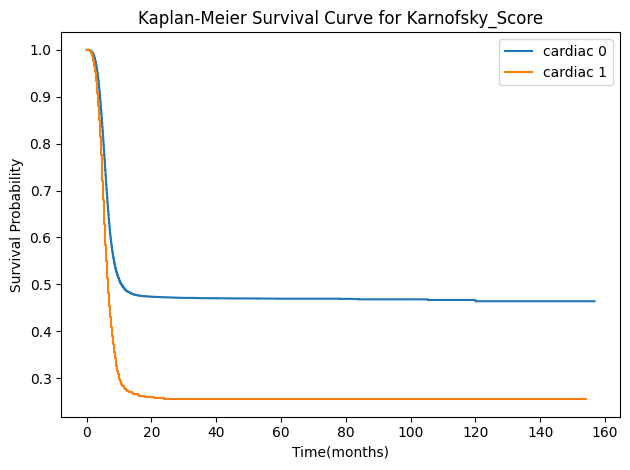

In [200]:
# plot Kaplan-Meier curve for 'cardiac' column
plot_kaplan_meier('cardiac' , 'Kaplan-Meier Survival Curve for Karnofsky_Score')

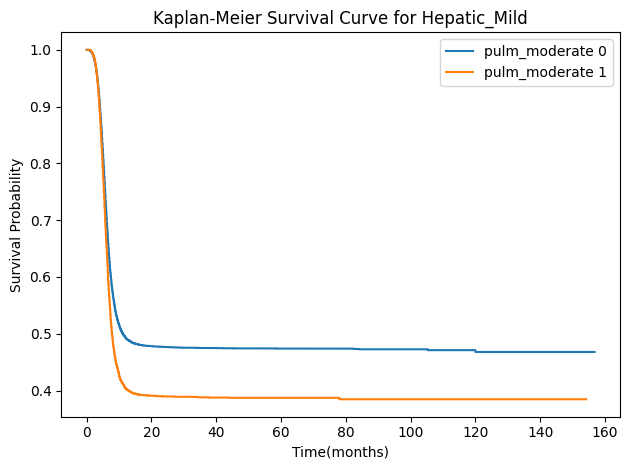

In [201]:
# plot Kaplan-Meier curve for 'pulm_moderate' column
plot_kaplan_meier('pulm_moderate' , 'Kaplan-Meier Survival Curve for Hepatic_Mild')

In [202]:
# Test the function with 'melphalan_dose' as the first variable and 'efs' as the second variable.
# This checks if there's a significant association between these two categorical variables.
chi2_contingency_test('melphalan_dose', 'efs')

Title: melphalan_dose
Chi2: 1.7179263532563804
P-value: 0.18996018777983786
Degrees of Freedom: 1
Expected Frequencies: [[ 3344.64166667  3915.35833333]
 [ 9923.35833333 11616.64166667]]
Cramér's V: 0.007723355527177282


In [203]:
# Test the function with 'cardiac' as the first variable and 'efs' as the second variable.
chi2_contingency_test('cardiac' , 'efs')

Title: cardiac
Chi2: 267.5912866516208
P-value: 3.800899548841865e-60
Degrees of Freedom: 1
Expected Frequencies: [[12568.20513889 14712.79486111]
 [  699.79486111   819.20513889]]
Cramér's V: 0.09639172225791977


In [204]:
# Test the function with 'pulm_moderate' as the first variable and 'efs' as the second variable.
chi2_contingency_test('pulm_moderate' , 'efs')

Title: pulm_moderate
Chi2: 130.9394000632542
P-value: 2.5528173060385327e-30
Degrees of Freedom: 1
Expected Frequencies: [[10849.81486111 12701.18513889]
 [ 2418.18513889  2830.81486111]]
Cramér's V: 0.06742779061070273


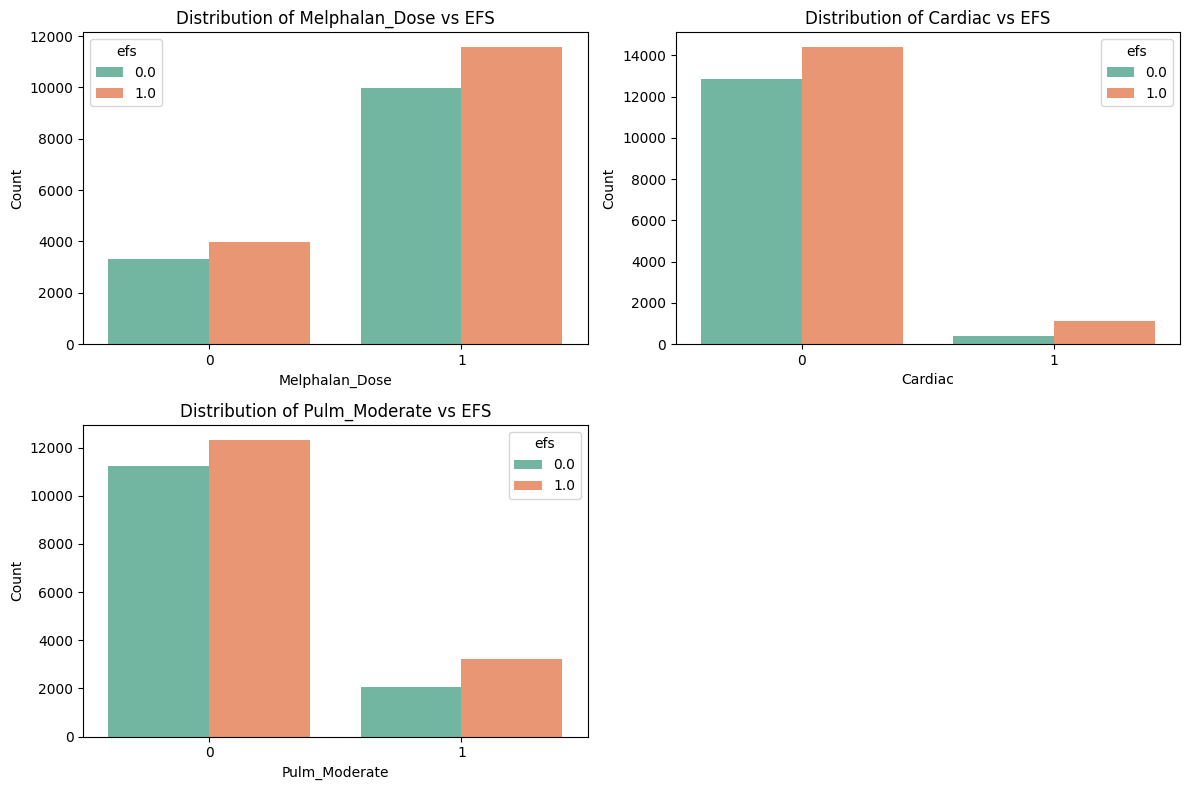

In [205]:
# Set the overall figure size
plt.figure(figsize=(12, 8))

# Plot 1: melphalan_dose vs EFS
plt.subplot(2, 2, 1)

sns.countplot(x='melphalan_dose', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Melphalan_Dose vs EFS")  # Add title for the plot
plt.xlabel("Melphalan_Dose")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 2: cardiac vs EFS
plt.subplot(2, 2, 2)

sns.countplot(x='cardiac', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Cardiac vs EFS")  # Add title for the plot
plt.xlabel("Cardiac")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Plot 3: pulm_moderate vs EFS
plt.subplot(2, 2, 3)

sns.countplot(x='pulm_moderate', hue='efs', data=data_train, palette='Set2')  # Create a count plot
plt.title("Distribution of Pulm_Moderate vs EFS")  # Add title for the plot
plt.xlabel("Pulm_Moderate")  # Label for the x-axis
plt.ylabel("Count")  # Label for the y-axis

# Adjust the layout to prevent overlap and ensure everything fits
plt.tight_layout()
# Display the plot
plt.show()

<p style="background-color: #FFFF; font-family: Times New Roman; 
color: black; font-size: 200%; text-align: center; 
border-radius: 15px 15px; padding: 15px;">
    <strong>Construct</strong>
</p>

In [206]:
# Separates features (X) and target variable (y), with 'efs_combined' as the target.
x = data_train.drop(['efs' , 'efs_time' , 'ID'], axis=1, inplace=False)  # Features (all columns except 'efs' and 'efs_time' and 'ID')
y_target = data_train['efs']

# Step 1: Split data into 70% training and 30% temporary set (which will be further split)
x_train, x_temp, y_train, y_temp = train_test_split(x, y_target, test_size=0.3, stratify=y_target ,random_state=42)

# Step 2: Split the temporary set into 15% validation (dev) and 15% test
x_dev, x_test, y_dev, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp ,random_state=42)

# Print dataset sizes for verification
print(f"X_train: {x_train.shape},X_dev: {x_dev.shape} ,X_test: {x_test.shape}")
print(f"Y_train: {y_train.shape},Y_dev: {y_dev.shape} ,Y_test: {y_test.shape}")

X_train: (20160, 57),X_dev: (4320, 57) ,X_test: (4320, 57)
Y_train: (20160,),Y_dev: (4320,) ,Y_test: (4320,)


In [207]:
# Step 3: Apply standard scaling to the features to standardize the data
scaler = StandardScaler()  # Initialize the scaler
x_train_scaled = scaler.fit_transform(x_train)  # Fit the scaler on the training data and transform it
x_dev_scaled = scaler.transform(x_dev)  # Transform the test data based on the scaler fit on the training data
x_test_scaled = scaler.transform(x_test)  # Transform the test data based on the scaler fit on the training data

In [208]:
# Instantiate the XGBClassifier model
xgb_model = XGBClassifier(n_estimators=1000, colsample_bytree=0.7, objective='binary:logistic')

# Define a grid of hyperparameters for tuning the model  
cv_params = {
    'learning_rate': np.linspace(0.01, 0.3, 5,endpoint=True),                # Learning rate
    'max_depth': np.arange(4, 20, 4),                                        # Depth of trees
    'min_child_weight': np.arange(1,6,1),                                    # Minimum sum of instance weights needed in a child node to control model complexity  
}
# Scoring
scoring = {'accuracy', 'precision', 'recall', 'f1'}

In [209]:
# Initialize GridSearchCV
grid_search = GridSearchCV (
    estimator=xgb_model,             # XGBoost model
    param_grid=cv_params,            # Hyperparameter grid
    scoring=scoring,                 # Evaluation metric: accuracy
    cv=5,                            # Number of cross-validation splits
    verbose=1,                       # Print progress
    refit='f1',
    n_jobs=-1,                       # Use all available CPU cores
)

In [210]:
# Run the search for the best hyperparameter combination
grid_search.fit(
    x_train_scaled, y_train,
    eval_set=[(x_dev_scaled, y_dev)],     # Use validation set to monitor performance
    early_stopping_rounds=50,             # Stop if validation loss doesn't improve for 10 rounds
    eval_metric="logloss",                # Metric to monitor
    verbose=True,                        # Print progress
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[0]	validation_0-logloss:0.68900
[1]	validation_0-logloss:0.68814
[2]	validation_0-logloss:0.68711
[3]	validation_0-logloss:0.68609
[4]	validation_0-logloss:0.68520
[5]	validation_0-logloss:0.68422
[6]	validation_0-logloss:0.68328
[7]	validation_0-logloss:0.68234
[8]	validation_0-logloss:0.68150
[9]	validation_0-logloss:0.68060
[10]	validation_0-logloss:0.67969
[11]	validation_0-logloss:0.67889
[12]	validation_0-logloss:0.67802
[13]	validation_0-logloss:0.67716


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.67635
[15]	validation_0-logloss:0.67551
[16]	validation_0-logloss:0.67474
[17]	validation_0-logloss:0.67399
[18]	validation_0-logloss:0.67326
[19]	validation_0-logloss:0.67250
[20]	validation_0-logloss:0.67174
[21]	validation_0-logloss:0.67098
[22]	validation_0-logloss:0.67022
[23]	validation_0-logloss:0.66950
[24]	validation_0-logloss:0.66877
[25]	validation_0-logloss:0.66817
[26]	validation_0-logloss:0.66752
[27]	validation_0-logloss:0.66685
[28]	validation_0-logloss:0.66622
[29]	validation_0-logloss:0.66555
[30]	validation_0-logloss:0.66489
[31]	validation_0-logloss:0.66423
[32]	validation_0-logloss:0.66358
[33]	validation_0-logloss:0.66296
[34]	validation_0-logloss:0.66231
[35]	validation_0-logloss:0.66169
[36]	validation_0-logloss:0.66110
[37]	validation_0-logloss:0.66053
[38]	validation_0-logloss:0.65995
[39]	validation_0-logloss:0.65936
[40]	validation_0-logloss:0.65881
[41]	validation_0-logloss:0.65829
[42]	validation_0-logloss:0.65774
[43]	validatio

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.7, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01  , 0.0825, 0.155 , 0.2275, 0.3   ]),
                         'max_depth': array([ 4,  8, 12, 16]),
                         'min_child_weight': array([1, 2, 3, 4, 5])},
             refit='f1', scoring={'precision', 'recall', 'accuracy', 'f1'},
             verbose=1)

In [211]:
# Print the best parameters
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best F1-Score: {grid_search.best_score_}")

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 3}
Best F1-Score: 0.7199041882101062


In [212]:
# Store the 'ID' column separately before dropping it
id_column = data_test['ID']

# Drop the 'ID' column from the dataset without modifying the original DataFrame
data_test = data_test.drop(['ID'], axis=1, inplace=False)

In [213]:
# Use the best model found by GridSearchCV
best_model = grid_search.best_estimator_

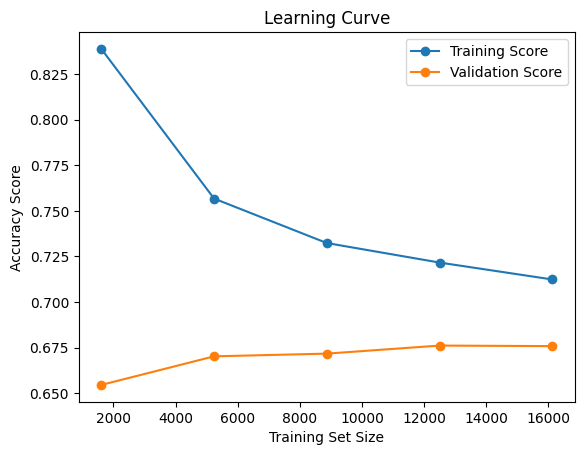

In [214]:
# Compute learning curves for the model
train_sizes, train_scores, test_scores = learning_curve(
    best_model, x_train_scaled, y_train, cv=5, scoring='accuracy')

# Calculate the mean accuracy for training and validation sets
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Plot the learning curves
plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
plt.plot(train_sizes, test_mean, label='Validation Score', marker='o')

# Add labels and title to the plot
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [215]:
# Calculate model accuracy on the training data
train_accuracy = accuracy_score(y_train, best_model.predict(x_train_scaled))

# Calculate model accuracy on the test data
test_accuracy = accuracy_score(y_test, best_model.predict(x_test_scaled))

# Print the training and testing accuracy scores
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.7062003968253968
Testing Accuracy: 0.6925925925925925


In [216]:
# Make predictions on the test set
y_pred = best_model.predict(x_test_scaled)

# Predict
print(y_pred)

[0 0 0 ... 1 0 1]


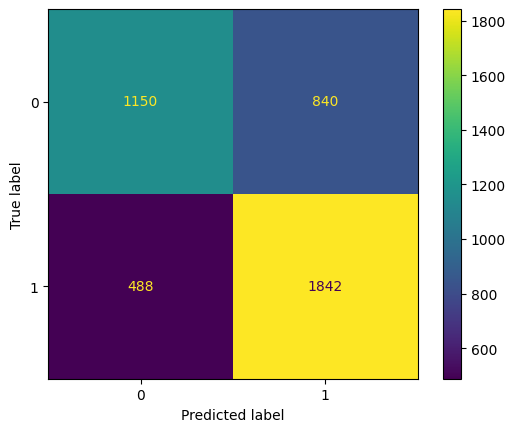

In [217]:
# Calculate and print the Confusion_matrix (CM) to evaluate model performance.
cm = confusion_matrix(y_test , y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

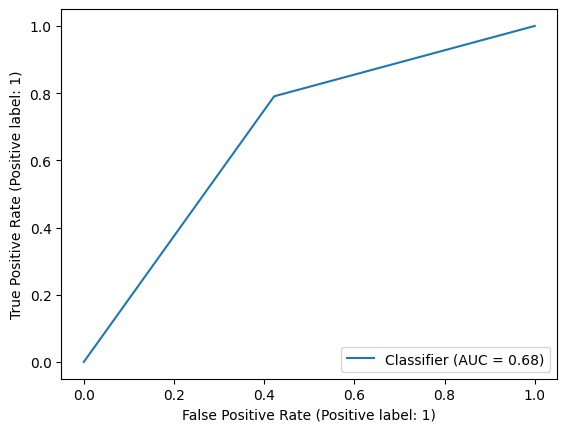

In [218]:
# Generate and display the ROC curve using the predicted probabilities
RocCurveDisplay.from_predictions(y_test, y_pred)

# Show the plot
plt.show()

In [219]:
# Generate a classification report for the model's predictions
# The report includes key metrics such as precision, recall, F1-score, and support
# This helps evaluate the model's performance in more detail.
report = classification_report(y_test , y_pred)

# Print the generated classification report
print(f"Report: {report}")

Report:               precision    recall  f1-score   support

         0.0       0.70      0.58      0.63      1990
         1.0       0.69      0.79      0.74      2330

    accuracy                           0.69      4320
   macro avg       0.69      0.68      0.68      4320
weighted avg       0.69      0.69      0.69      4320



In [220]:
# Make predictions on the data test set
y_pred_data_test = best_model.predict(data_test)

# Predict
print(y_pred_data_test)

[0 1 1]


In [221]:
# Create a DataFrame for submission with columns 'ID' and 'Prediction'
submission = pd.DataFrame(columns=['ID', 'prediction'])

# Assign the values of id_column to the 'ID' column
submission['ID'] = id_column

# Assign the predicted values (y_pred) to the 'Prediction' column
submission['prediction'] = y_pred_data_test

# Save the submission DataFrame as a CSV file named 'submission.csv' without the index
submission.to_csv('submission.csv', index=False)

<p style="background-color: #FFFF; font-family: Times New Roman; 
color: black; font-size: 200%; text-align: center; 
border-radius: 15px 15px; padding: 15px;">
    <strong>Execute</strong>
</p>

In [222]:
# Display the first few rows of the submission DataFrame
submission.head()

ID  prediction
0  28800           0
1  28801           1
2  28802           1